### Imports

In [1]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear, LazyLinear, Sequential, BatchNorm1d, ReLU

import torch_geometric.transforms as T
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import SAGEConv, to_hetero, LightGCN

import pathlib
import os
import sys
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))
from utils.Neo4jMovieLensMetaData import Neo4jMovieLensMetaData
from utils.gnn_simple import Model
from utils.visualize import plot_loss, plot_test
from utils.EarlyStopper import EarlyStopper
import matplotlib.pyplot as plt


### Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = osp.join(osp.dirname(osp.abspath('')), '../../data/MovieLensNeo4jMetaData')
dataset = Neo4jMovieLensMetaData(
    path,
    model_name='all-MiniLM-L6-v2',
    database_url="bolt://localhost:7687",
    database_username="neo4j",
    database_password="admin",
    force_pre_process=True,
    force_db_restore=False,
    text_features=["title", "original_title"],
    list_features=[],
    fastRP_features=[],
    numeric_features=[],
    node2vec_features=[],
    SAGE_features=[],
)

# path = osp.join('../../data/MovieLens')
# dataset = MovieLens(path, model_name='all-MiniLM-L6-v2')
data = dataset[0].to(device)

data = dataset[0].to(device)
# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

Processing...


Movies have features...
Encoding title...
Encoding original_title...
[torch.Size([3485, 384]), torch.Size([3485, 384])]


Done!


### Train test functions

In [6]:
latest_predictions = []
losses_ = {}

def train_test(model, epochs, train_data, test_data, val_data, logging_step, lr=0.01, use_weighted_loss=False):

    # Due to lazy initialization, we need to run one model step so the number
    # of parameters can be inferred:
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    weight = None
    if use_weighted_loss:
        weight = torch.bincount(train_data['user', 'movie'].edge_label)
        weight = weight.max() / weight

    def weighted_rmse_loss(pred, target, weight=None):
        weight = 1. if weight is None else weight[target].to(pred.dtype)
        # return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()
        return (weight * (pred - target.to(pred.dtype)).pow(2)).mean().sqrt()
    
    def train(log=False):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.x_dict, train_data.edge_index_dict,
                        train_data['user', 'movie'].edge_label_index)
        # print(pred[:10])
        target = train_data['user', 'movie'].edge_label

        loss = weighted_rmse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)

    @torch.no_grad()
    def test(data, log=False):
        model.eval()
        pred = model(data.x_dict, data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        # print(pred[:10])
        pred = pred.clamp(min=0, max=5)

        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        if log:
            predictions = pred.detach().numpy()
            plt.hist(predictions, range=[0, 5])
            plt.show()
        return float(rmse)
    
    early_stopper = EarlyStopper(patience=30, min_delta=0.01)
    losses = []
    for epoch in range(1, epochs+1):
        # add learning rate decay to optimizer
        optimizer.param_groups[0]['lr'] = lr / (1 + 0.05 * epoch)

        loss = train(log=not(epoch%20))
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data, log=not(epoch%10))
        losses.append((loss, train_rmse, val_rmse, test_rmse))
        if (logging_step and not epoch%logging_step) or (not logging_step):
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
        if epoch > 30 and early_stopper.early_stop(val_rmse):
            print("Early stopping...")
            break
    
    last_losses = losses[-1]
    losses = losses + [last_losses] * (epochs - len(losses))

    losses_["LIGHT"] = losses

### Experiments

### GIN

GIN
Aggregation: None
Epoch: 005, Loss: 3.5932, Train: 3.5561, Val: 3.5648, Test: 3.5594


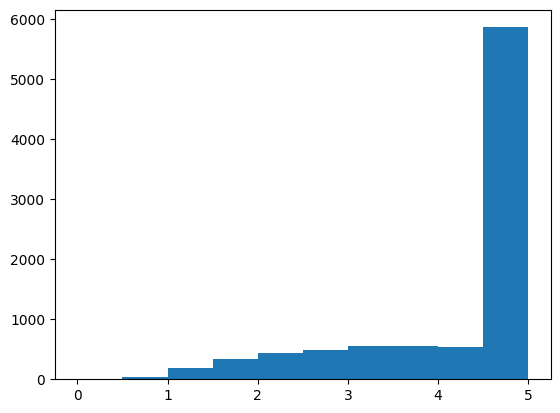

Epoch: 010, Loss: 2.2254, Train: 1.6736, Val: 1.6428, Test: 1.6922
Epoch: 015, Loss: 2.9600, Train: 3.0260, Val: 3.0413, Test: 2.9632


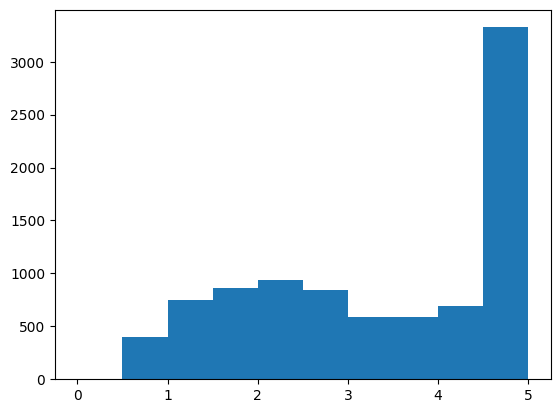

Epoch: 020, Loss: 2.2913, Train: 1.9839, Val: 1.9620, Test: 1.9186
Epoch: 025, Loss: 2.4842, Train: 2.4502, Val: 2.4564, Test: 2.3062


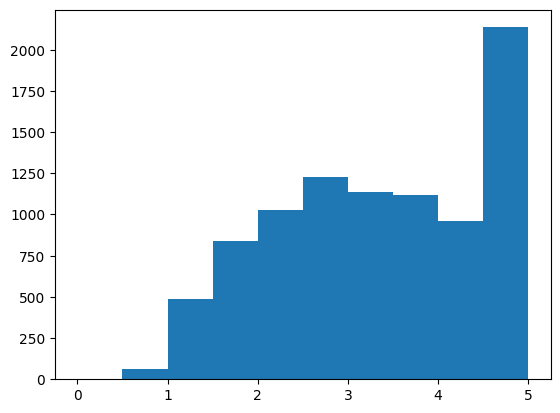

Epoch: 030, Loss: 1.9673, Train: 1.6773, Val: 1.6653, Test: 1.6444
Epoch: 035, Loss: 1.8279, Train: 1.7275, Val: 1.7529, Test: 1.5758


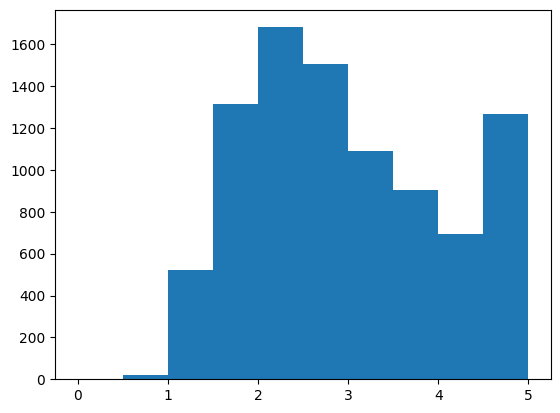

Epoch: 040, Loss: 1.8175, Train: 1.5961, Val: 1.6095, Test: 1.5074
Epoch: 045, Loss: 1.7143, Train: 1.6348, Val: 1.6603, Test: 1.5163


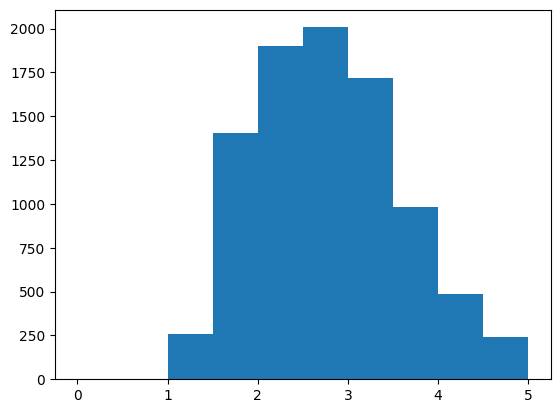

Epoch: 050, Loss: 1.6548, Train: 1.5773, Val: 1.5817, Test: 1.4544
Epoch: 055, Loss: 1.6220, Train: 1.5268, Val: 1.5170, Test: 1.4157


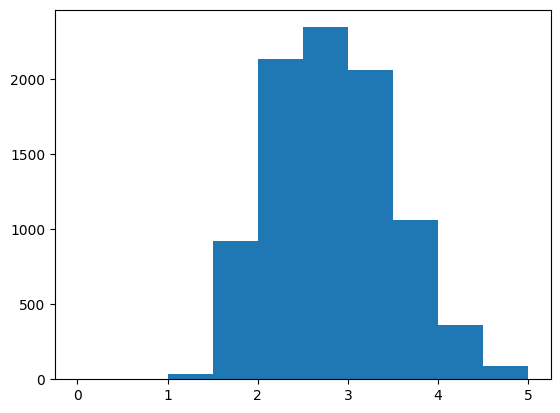

Epoch: 060, Loss: 1.5242, Train: 1.5056, Val: 1.4908, Test: 1.3849
Epoch: 065, Loss: 1.4814, Train: 1.4191, Val: 1.4360, Test: 1.3285


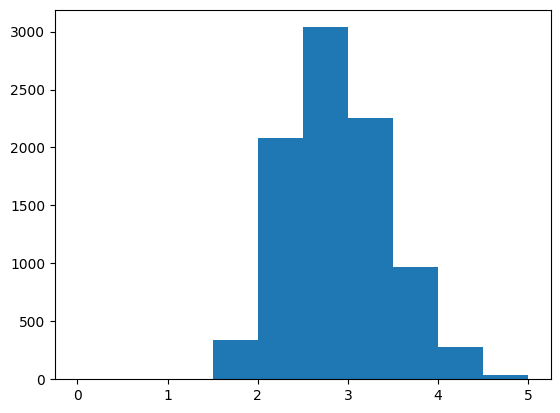

Epoch: 070, Loss: 1.4457, Train: 1.3980, Val: 1.3984, Test: 1.3023
Epoch: 075, Loss: 1.3926, Train: 1.3416, Val: 1.3379, Test: 1.2616


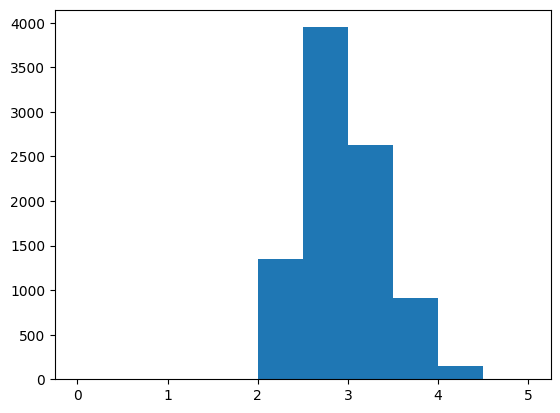

Epoch: 080, Loss: 1.3435, Train: 1.3141, Val: 1.3169, Test: 1.2326
Epoch: 085, Loss: 1.3009, Train: 1.2360, Val: 1.2289, Test: 1.1802


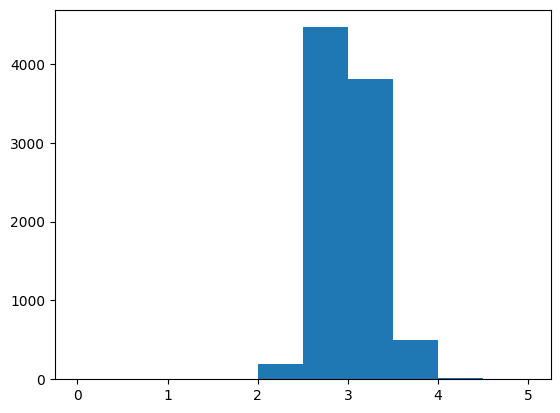

Epoch: 090, Loss: 1.2655, Train: 1.2254, Val: 1.2185, Test: 1.1685
Epoch: 095, Loss: 1.2329, Train: 1.1551, Val: 1.1458, Test: 1.1099


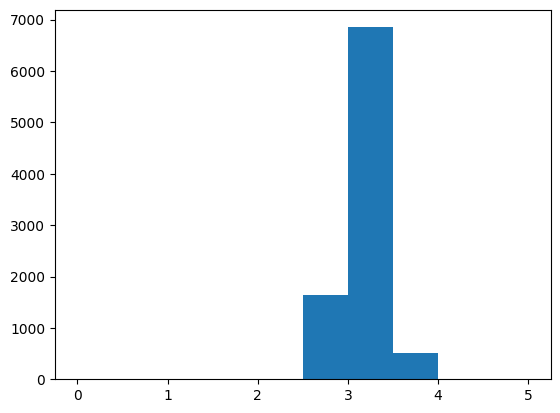

Epoch: 100, Loss: 1.2062, Train: 1.1396, Val: 1.1347, Test: 1.1053
Epoch: 105, Loss: 1.1910, Train: 1.1147, Val: 1.1017, Test: 1.0847


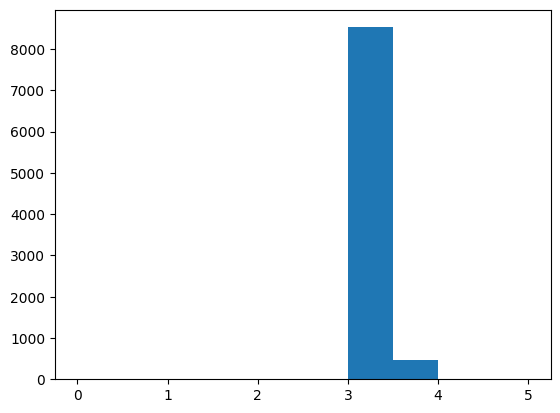

Epoch: 110, Loss: 1.1766, Train: 1.1027, Val: 1.0911, Test: 1.0808
Epoch: 115, Loss: 1.1703, Train: 1.0956, Val: 1.0842, Test: 1.0762


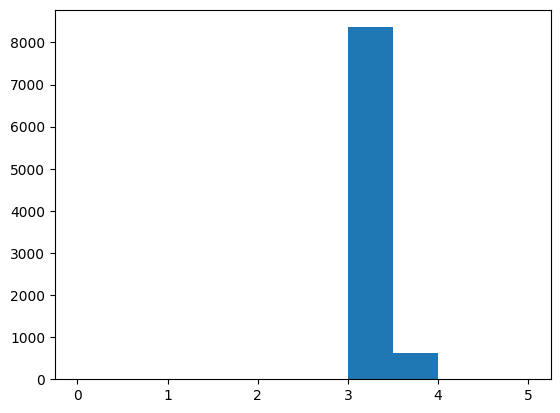

Epoch: 120, Loss: 1.1628, Train: 1.0894, Val: 1.0760, Test: 1.0694
Epoch: 125, Loss: 1.1573, Train: 1.0885, Val: 1.0747, Test: 1.0676


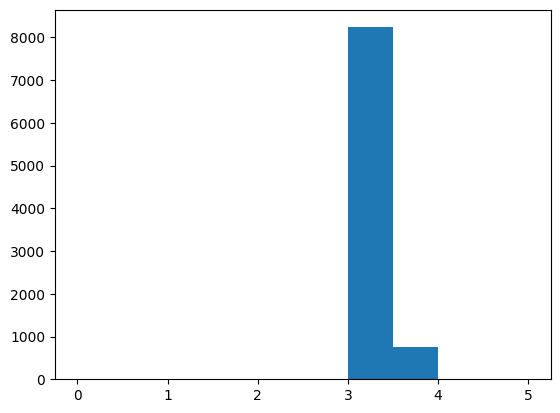

Epoch: 130, Loss: 1.1555, Train: 1.0874, Val: 1.0745, Test: 1.0656
Epoch: 135, Loss: 1.1509, Train: 1.0870, Val: 1.0742, Test: 1.0659


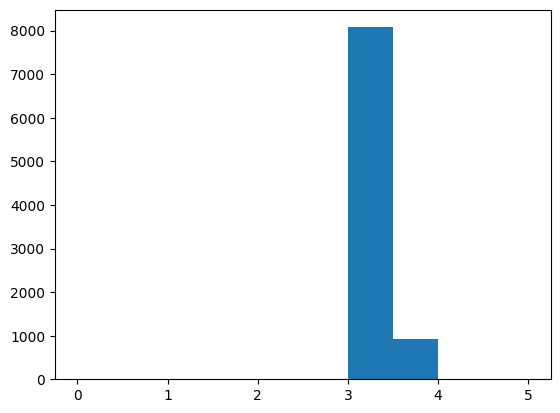

Epoch: 140, Loss: 1.1524, Train: 1.0848, Val: 1.0731, Test: 1.0648
Epoch: 145, Loss: 1.1486, Train: 1.0809, Val: 1.0688, Test: 1.0601


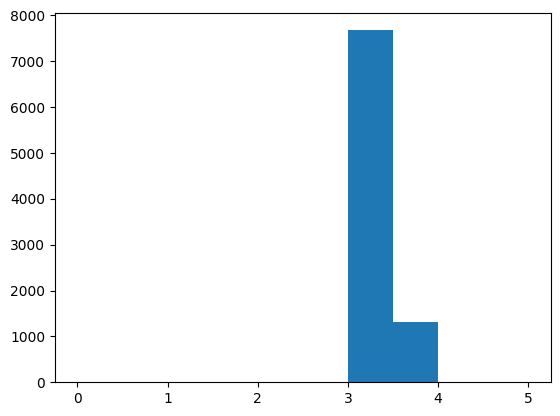

Epoch: 150, Loss: 1.1474, Train: 1.0814, Val: 1.0700, Test: 1.0602
Epoch: 155, Loss: 1.1439, Train: 1.0811, Val: 1.0697, Test: 1.0623


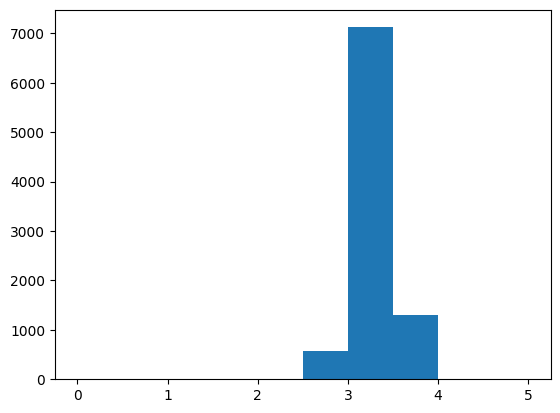

Epoch: 160, Loss: 1.1375, Train: 1.0800, Val: 1.0697, Test: 1.0616
Epoch: 165, Loss: 1.1352, Train: 1.0801, Val: 1.0708, Test: 1.0617


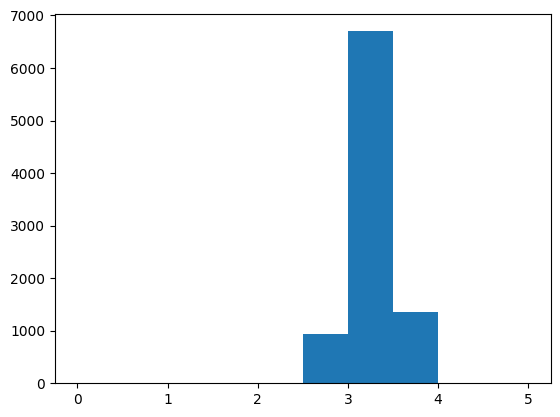

Epoch: 170, Loss: 1.1360, Train: 1.0781, Val: 1.0676, Test: 1.0607
Epoch: 175, Loss: 1.1320, Train: 1.0760, Val: 1.0634, Test: 1.0570


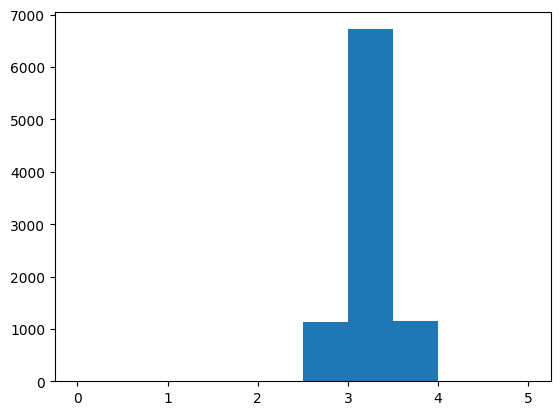

Epoch: 180, Loss: 1.1342, Train: 1.0794, Val: 1.0676, Test: 1.0620
Epoch: 185, Loss: 1.1313, Train: 1.0767, Val: 1.0657, Test: 1.0584


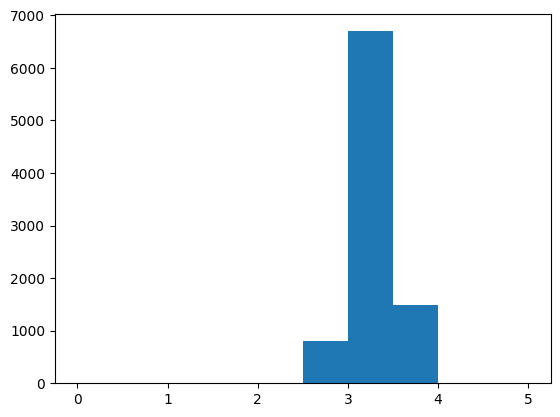

Epoch: 190, Loss: 1.1312, Train: 1.0753, Val: 1.0659, Test: 1.0585
Epoch: 195, Loss: 1.1251, Train: 1.0734, Val: 1.0636, Test: 1.0563


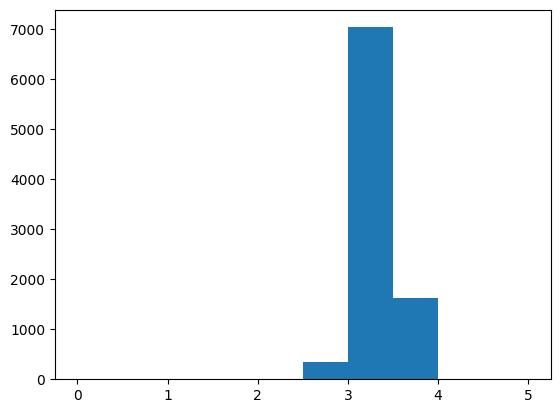

Epoch: 200, Loss: 1.1279, Train: 1.0738, Val: 1.0662, Test: 1.0577
Epoch: 205, Loss: 1.1292, Train: 1.0768, Val: 1.0666, Test: 1.0619


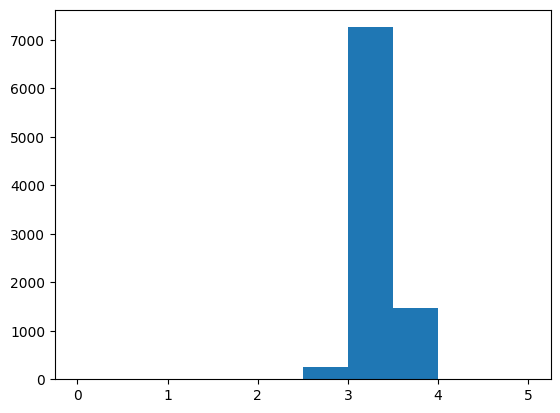

Epoch: 210, Loss: 1.1290, Train: 1.0745, Val: 1.0646, Test: 1.0586
Epoch: 215, Loss: 1.1299, Train: 1.0720, Val: 1.0622, Test: 1.0544


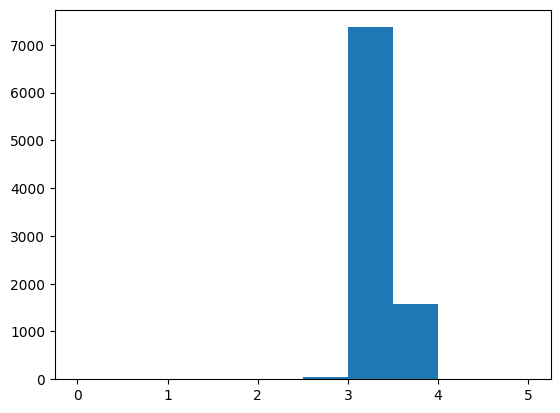

Epoch: 220, Loss: 1.1276, Train: 1.0739, Val: 1.0633, Test: 1.0577
Epoch: 225, Loss: 1.1267, Train: 1.0764, Val: 1.0660, Test: 1.0601


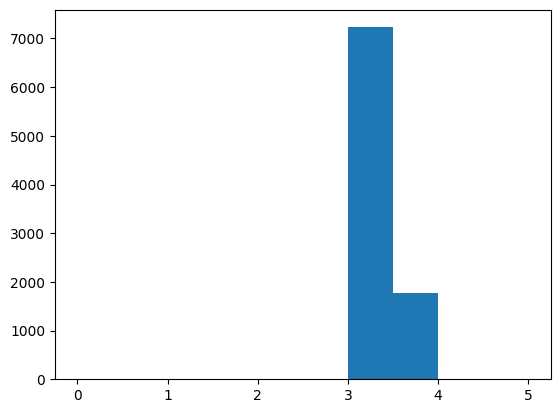

Epoch: 230, Loss: 1.1231, Train: 1.0739, Val: 1.0618, Test: 1.0557
Epoch: 235, Loss: 1.1215, Train: 1.0726, Val: 1.0618, Test: 1.0572


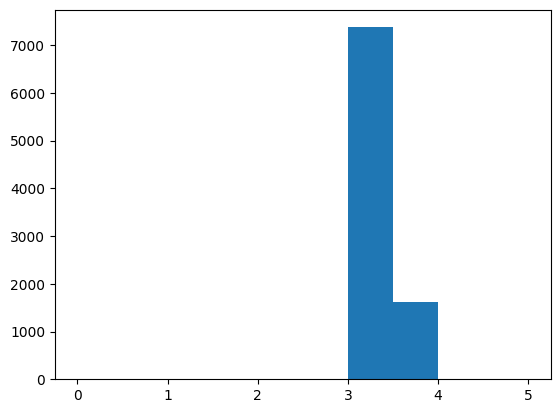

Epoch: 240, Loss: 1.1237, Train: 1.0742, Val: 1.0637, Test: 1.0570
Epoch: 245, Loss: 1.1261, Train: 1.0749, Val: 1.0641, Test: 1.0607


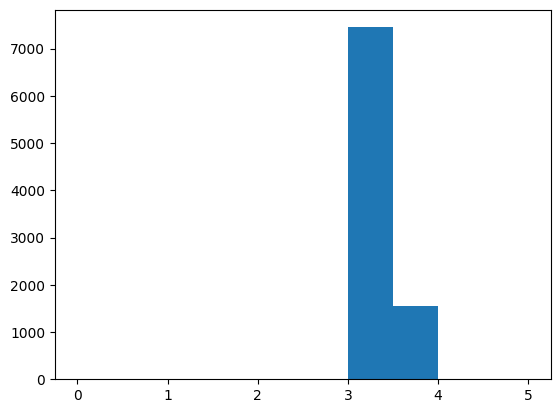

Epoch: 250, Loss: 1.1242, Train: 1.0728, Val: 1.0632, Test: 1.0574
Epoch: 255, Loss: 1.1207, Train: 1.0729, Val: 1.0632, Test: 1.0582


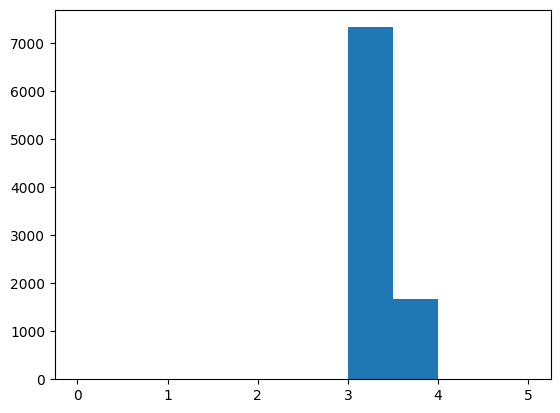

Epoch: 260, Loss: 1.1222, Train: 1.0726, Val: 1.0631, Test: 1.0557
Epoch: 265, Loss: 1.1209, Train: 1.0724, Val: 1.0617, Test: 1.0565


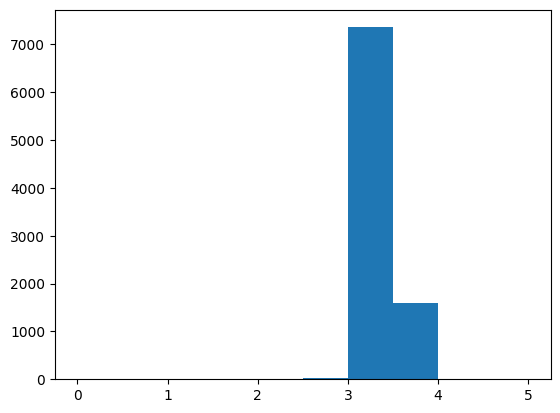

Epoch: 270, Loss: 1.1209, Train: 1.0716, Val: 1.0630, Test: 1.0564
Epoch: 275, Loss: 1.1207, Train: 1.0727, Val: 1.0623, Test: 1.0560


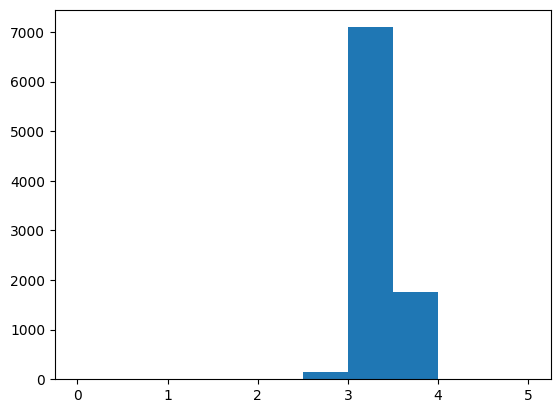

Epoch: 280, Loss: 1.1221, Train: 1.0724, Val: 1.0609, Test: 1.0552
Epoch: 285, Loss: 1.1189, Train: 1.0742, Val: 1.0644, Test: 1.0583


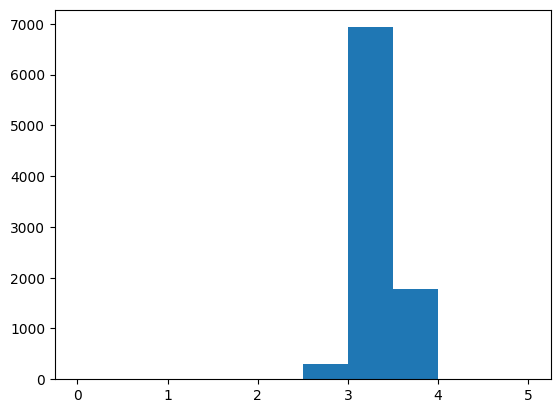

Epoch: 290, Loss: 1.1186, Train: 1.0722, Val: 1.0614, Test: 1.0549
Epoch: 295, Loss: 1.1222, Train: 1.0717, Val: 1.0591, Test: 1.0536


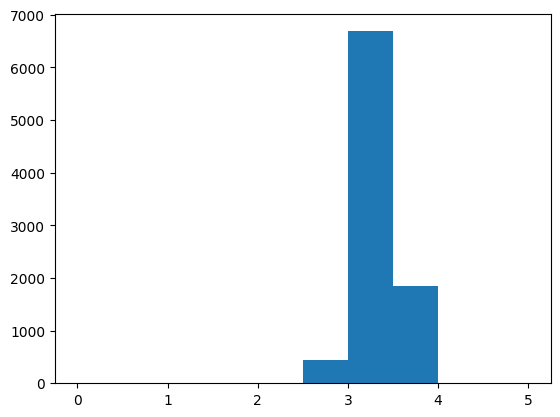

Epoch: 300, Loss: 1.1186, Train: 1.0718, Val: 1.0612, Test: 1.0540


In [8]:
model = Model(layer_name="GIN", hidden_channels=32, data=data, encoder_num_layers=3,
              decoder_num_layers=5, encoder_dropout=0.1, decoder_dropout=0.1, encoder_skip_connections=1)
train_test(model, train_data=train_data, test_data=test_data,
           val_data=val_data, logging_step=5, epochs=300, use_weighted_loss=False, lr=0.012)


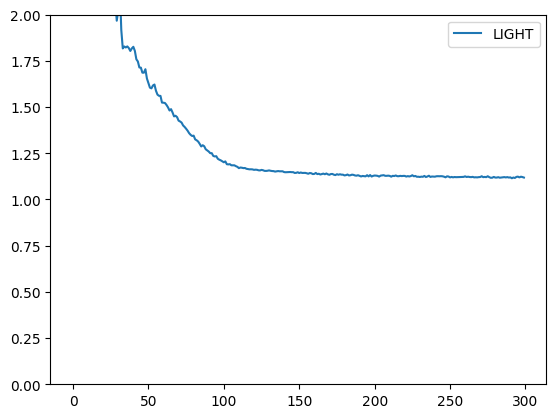

In [9]:
plot_loss(losses_, ylim=2)

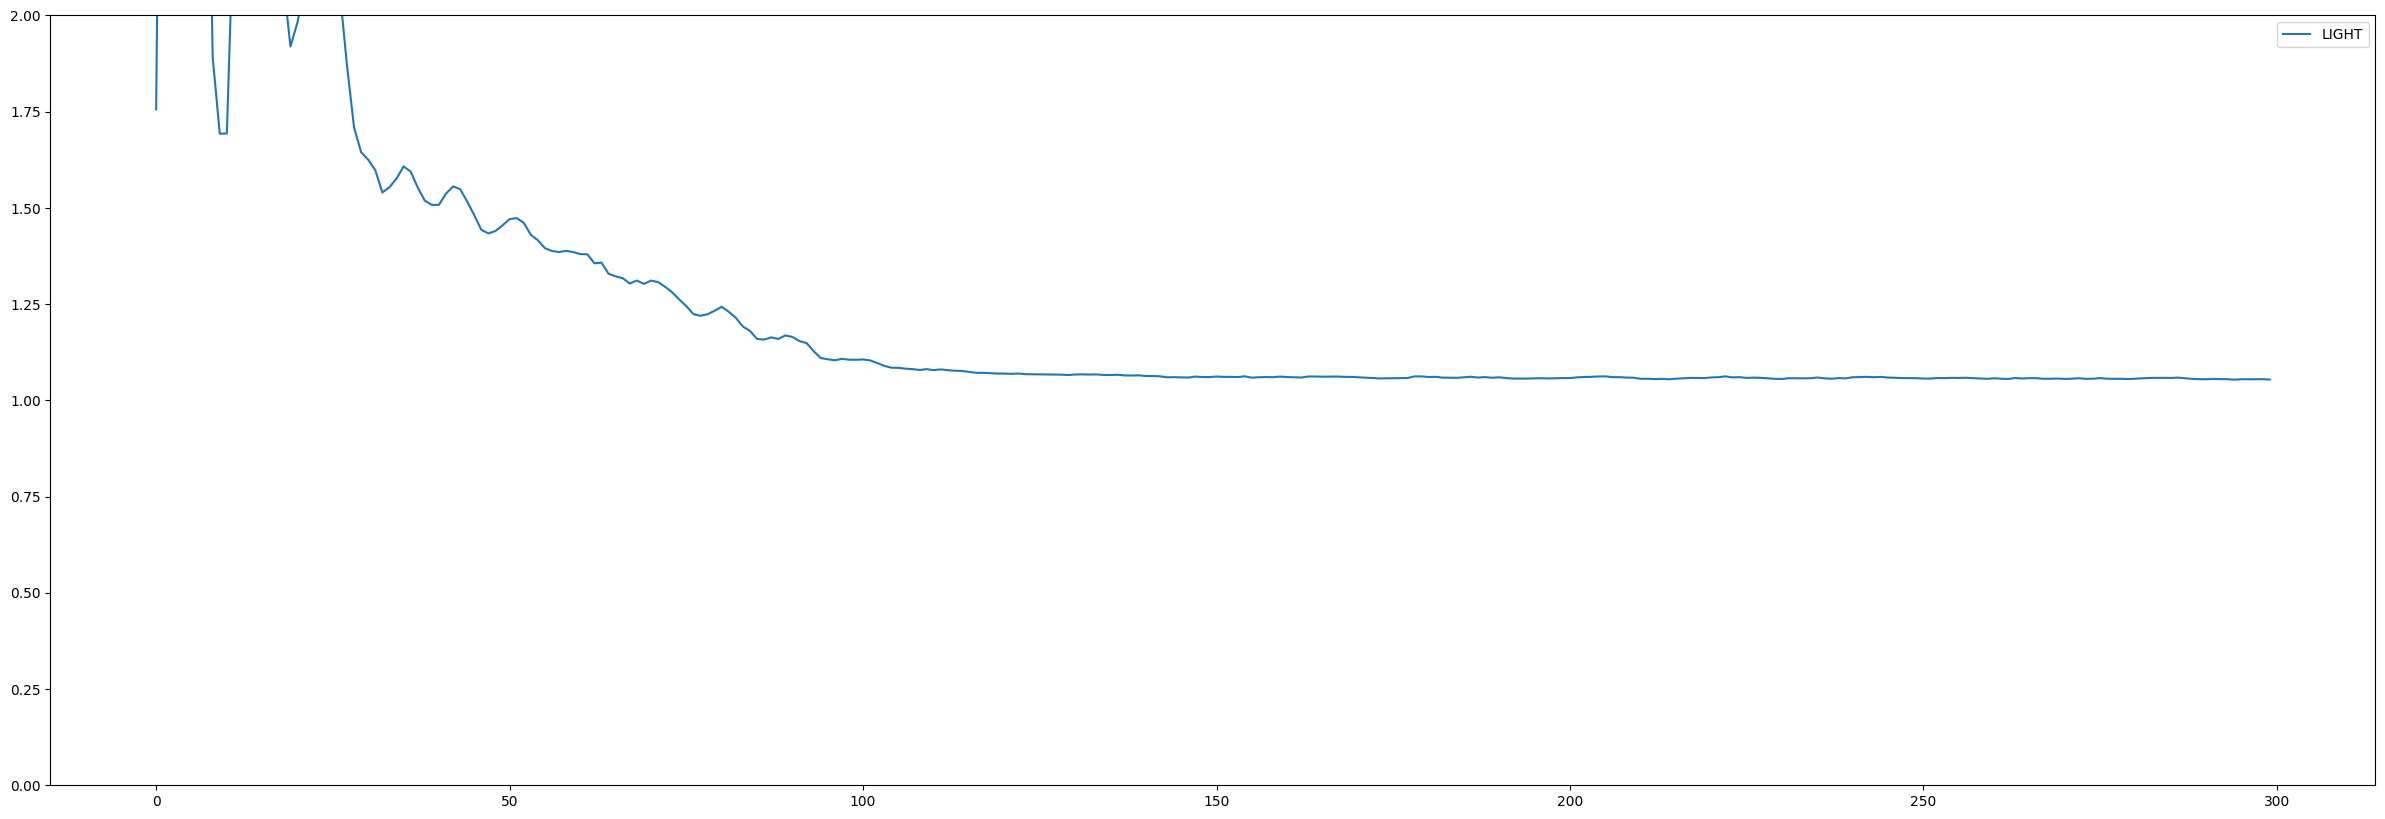

In [10]:
plot_test(losses_, ylim=2)

#### Tests

In [11]:
pred = model(train_data.x_dict, train_data.edge_index_dict, train_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)

(array([    0.,     0.,     0.,     0.,     0.,   417., 60960., 10569.,
            0.,     0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

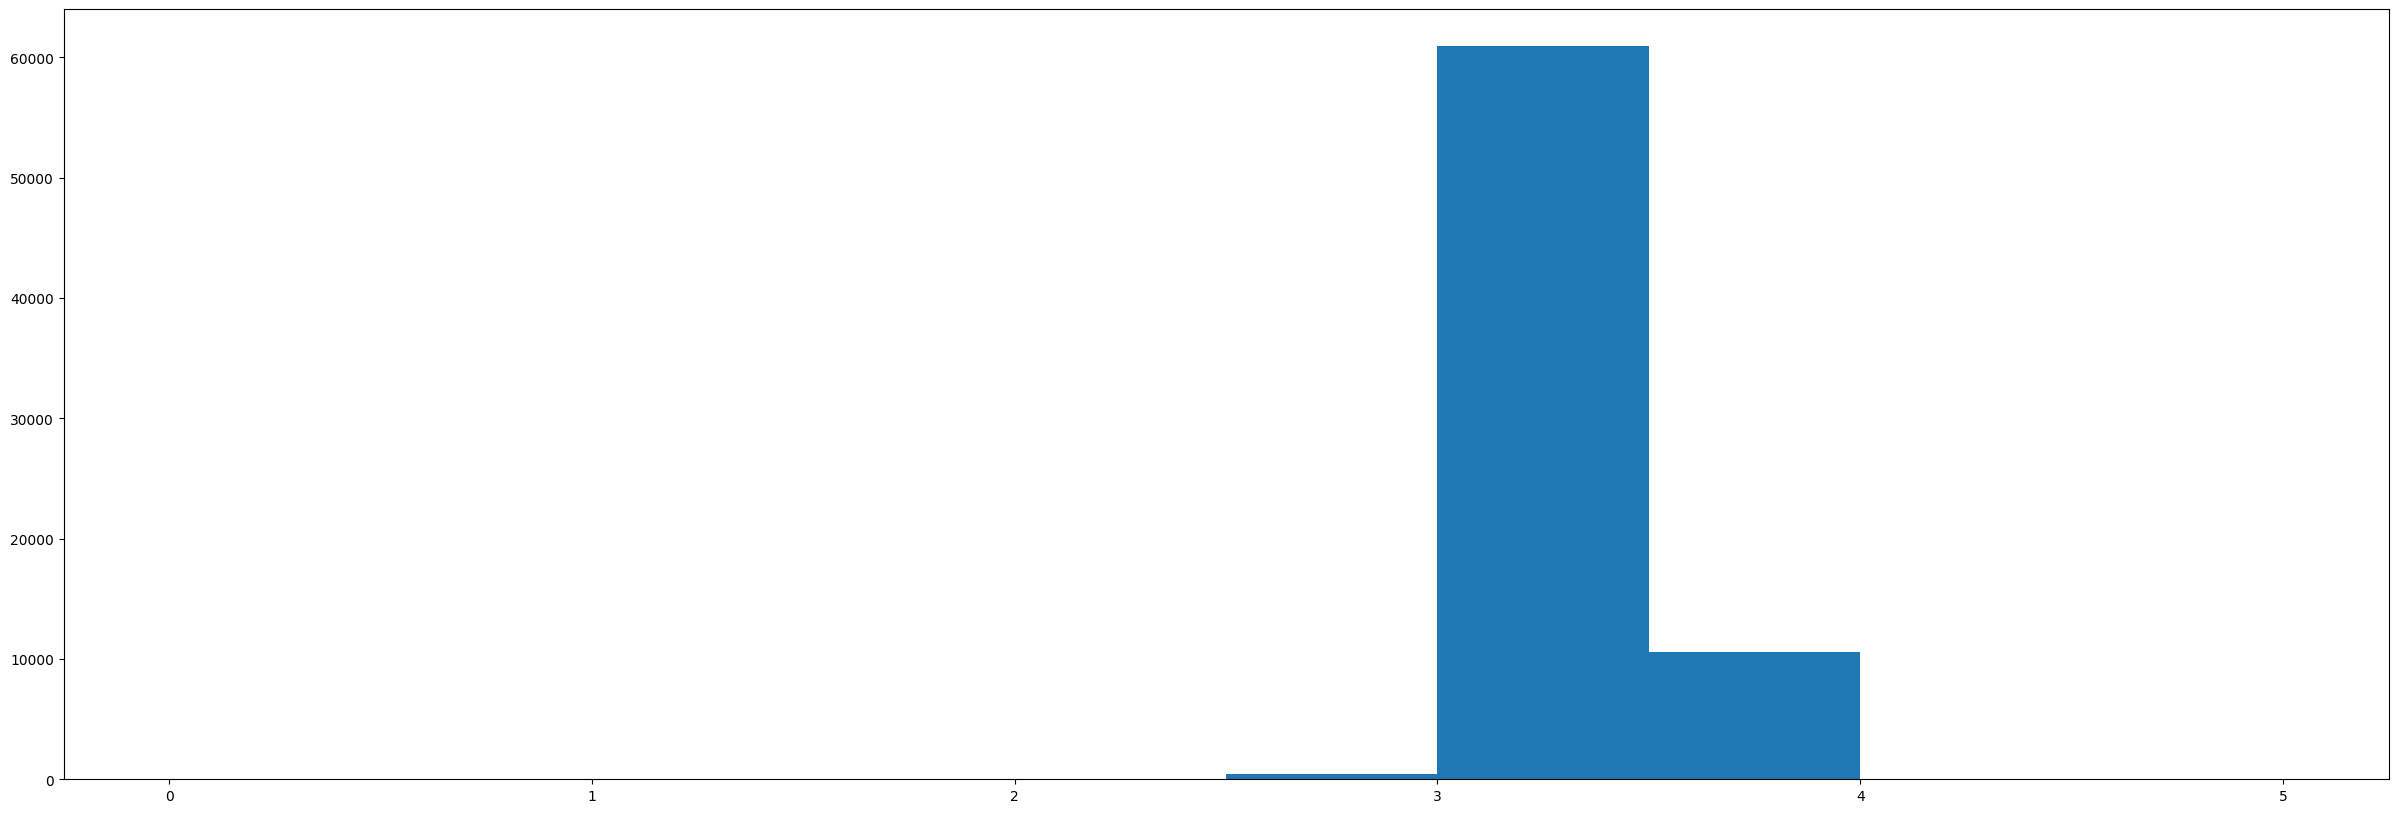

In [12]:
import matplotlib.pyplot as plt
predictions = pred.detach().numpy()
plt.hist(predictions, range=[0, 5])

### SAGE

SAGE
Aggregation: None
Epoch: 005, Loss: 1.8852, Train: 1.9787, Val: 1.9844, Test: 1.9743


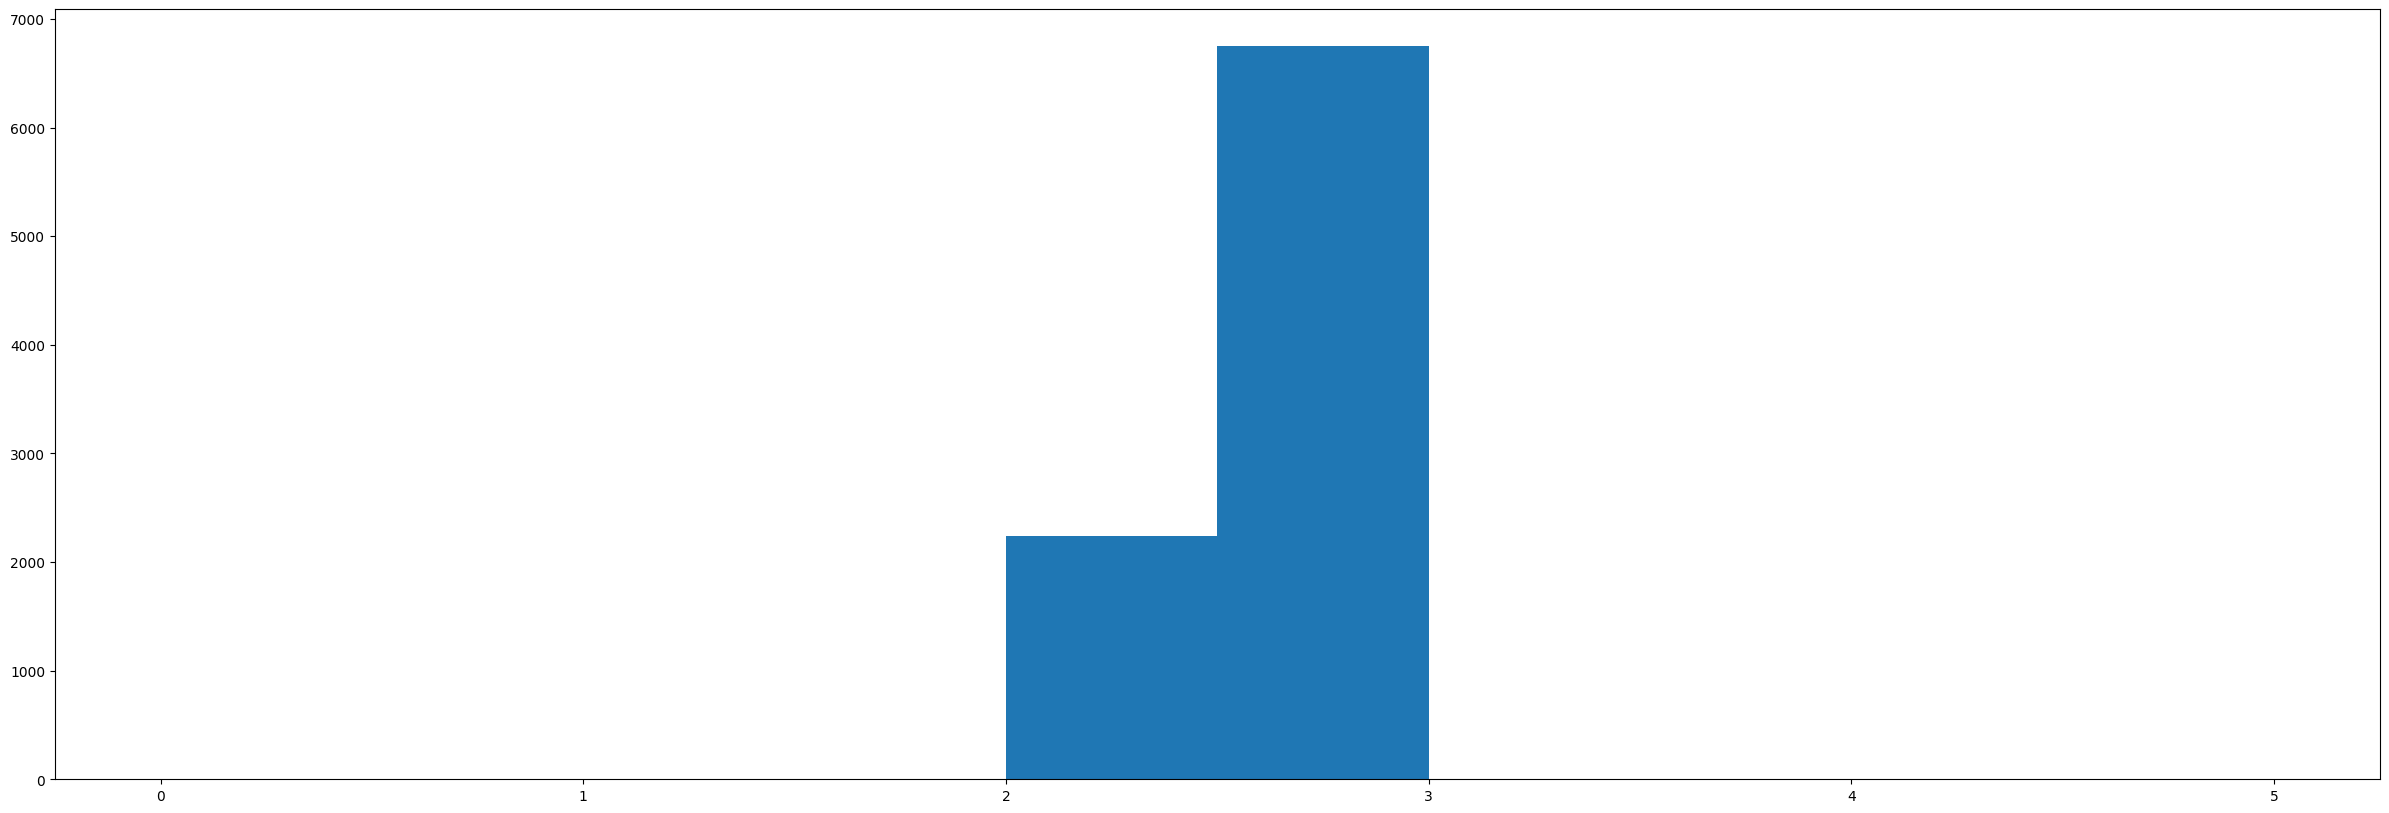

Epoch: 010, Loss: 1.2722, Train: 1.3896, Val: 1.3924, Test: 1.3928
Epoch: 015, Loss: 1.3532, Train: 1.0771, Val: 1.0613, Test: 1.0640


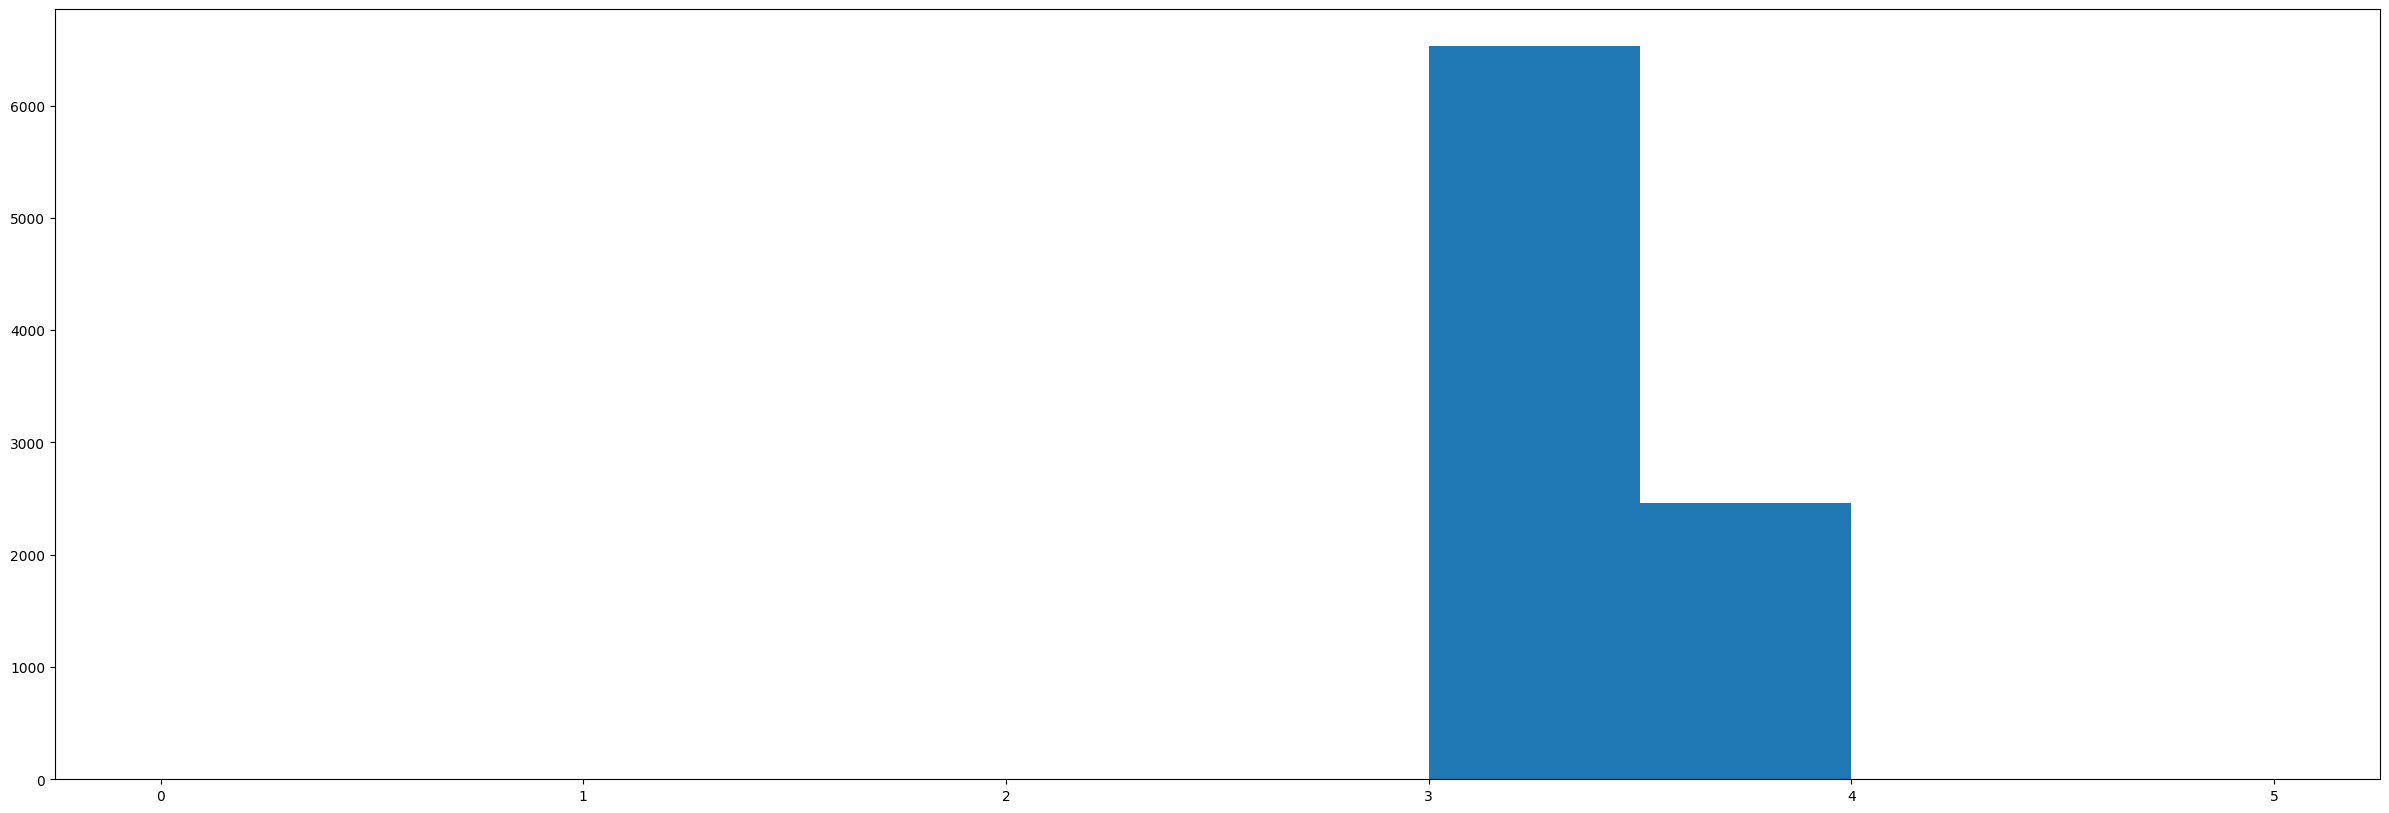

Epoch: 020, Loss: 1.2109, Train: 1.0696, Val: 1.0518, Test: 1.0491
Epoch: 025, Loss: 1.1944, Train: 1.1493, Val: 1.1361, Test: 1.1425


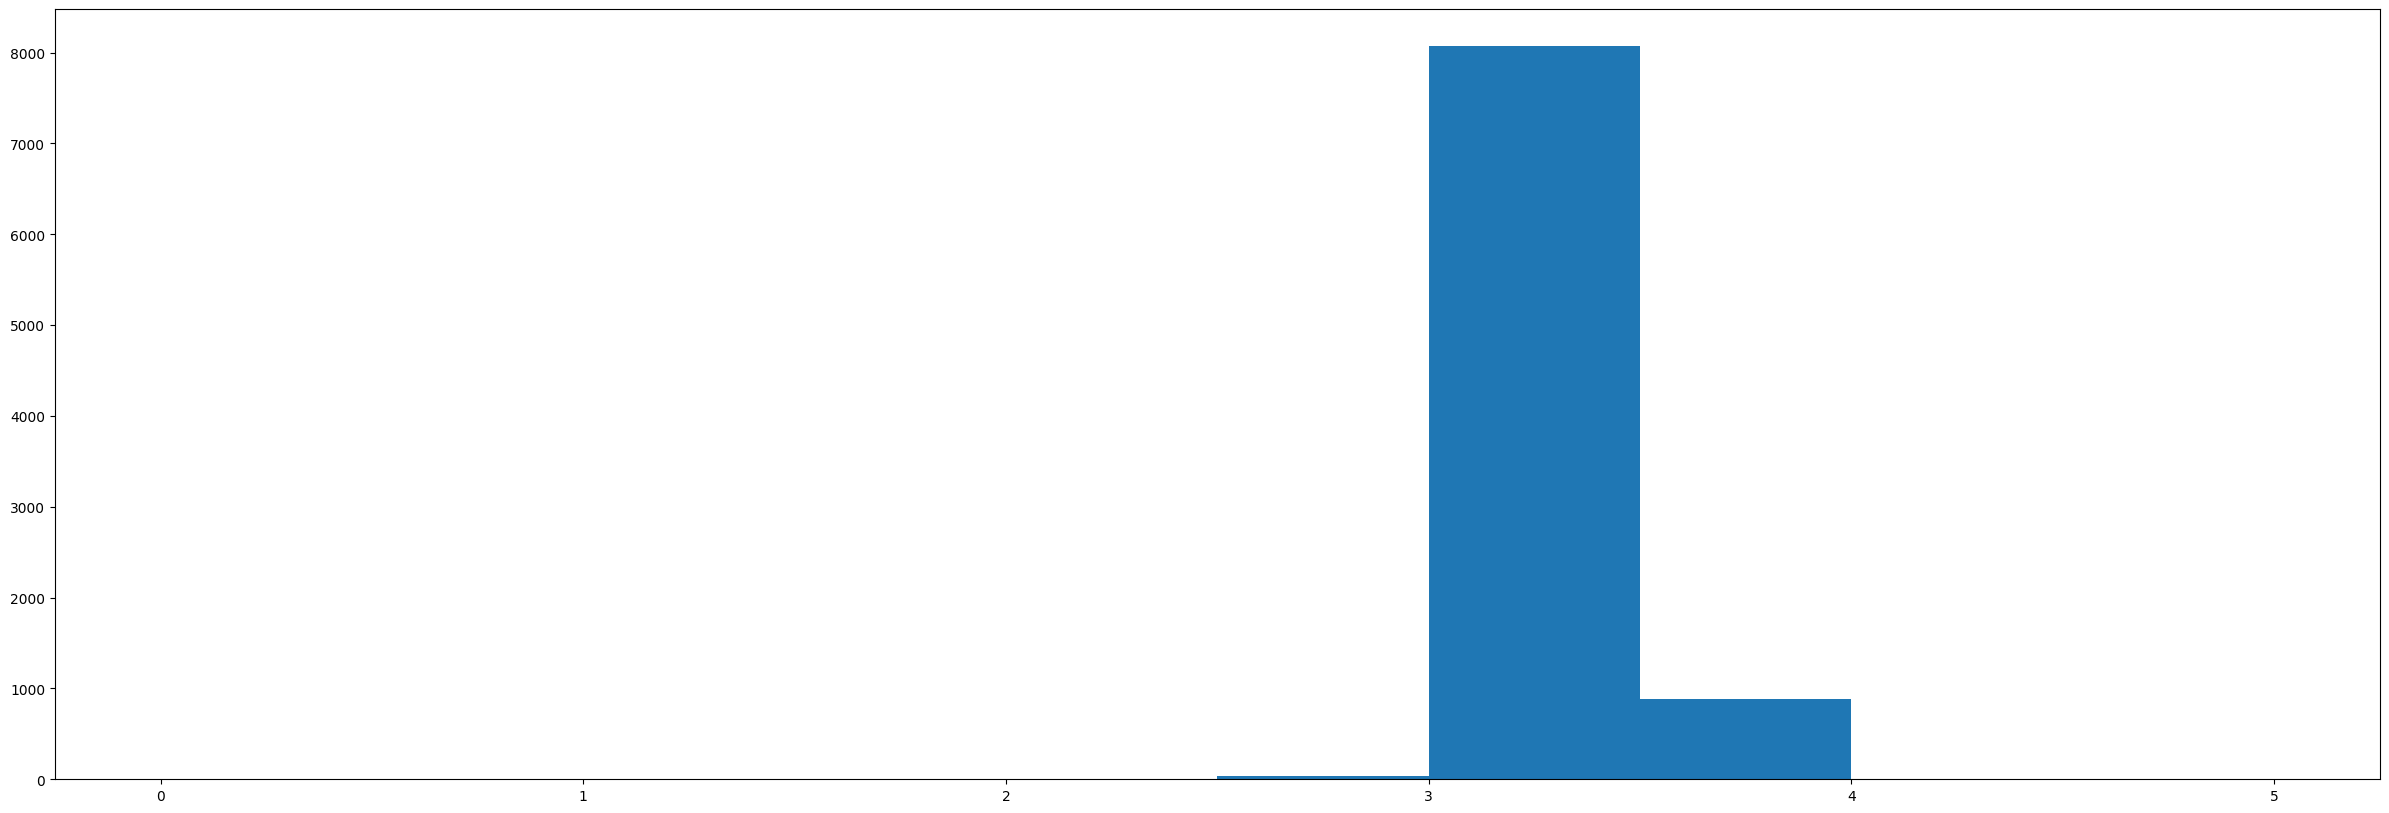

Epoch: 030, Loss: 1.1870, Train: 1.0676, Val: 1.0486, Test: 1.0470
Epoch: 035, Loss: 1.1504, Train: 1.0600, Val: 1.0423, Test: 1.0465


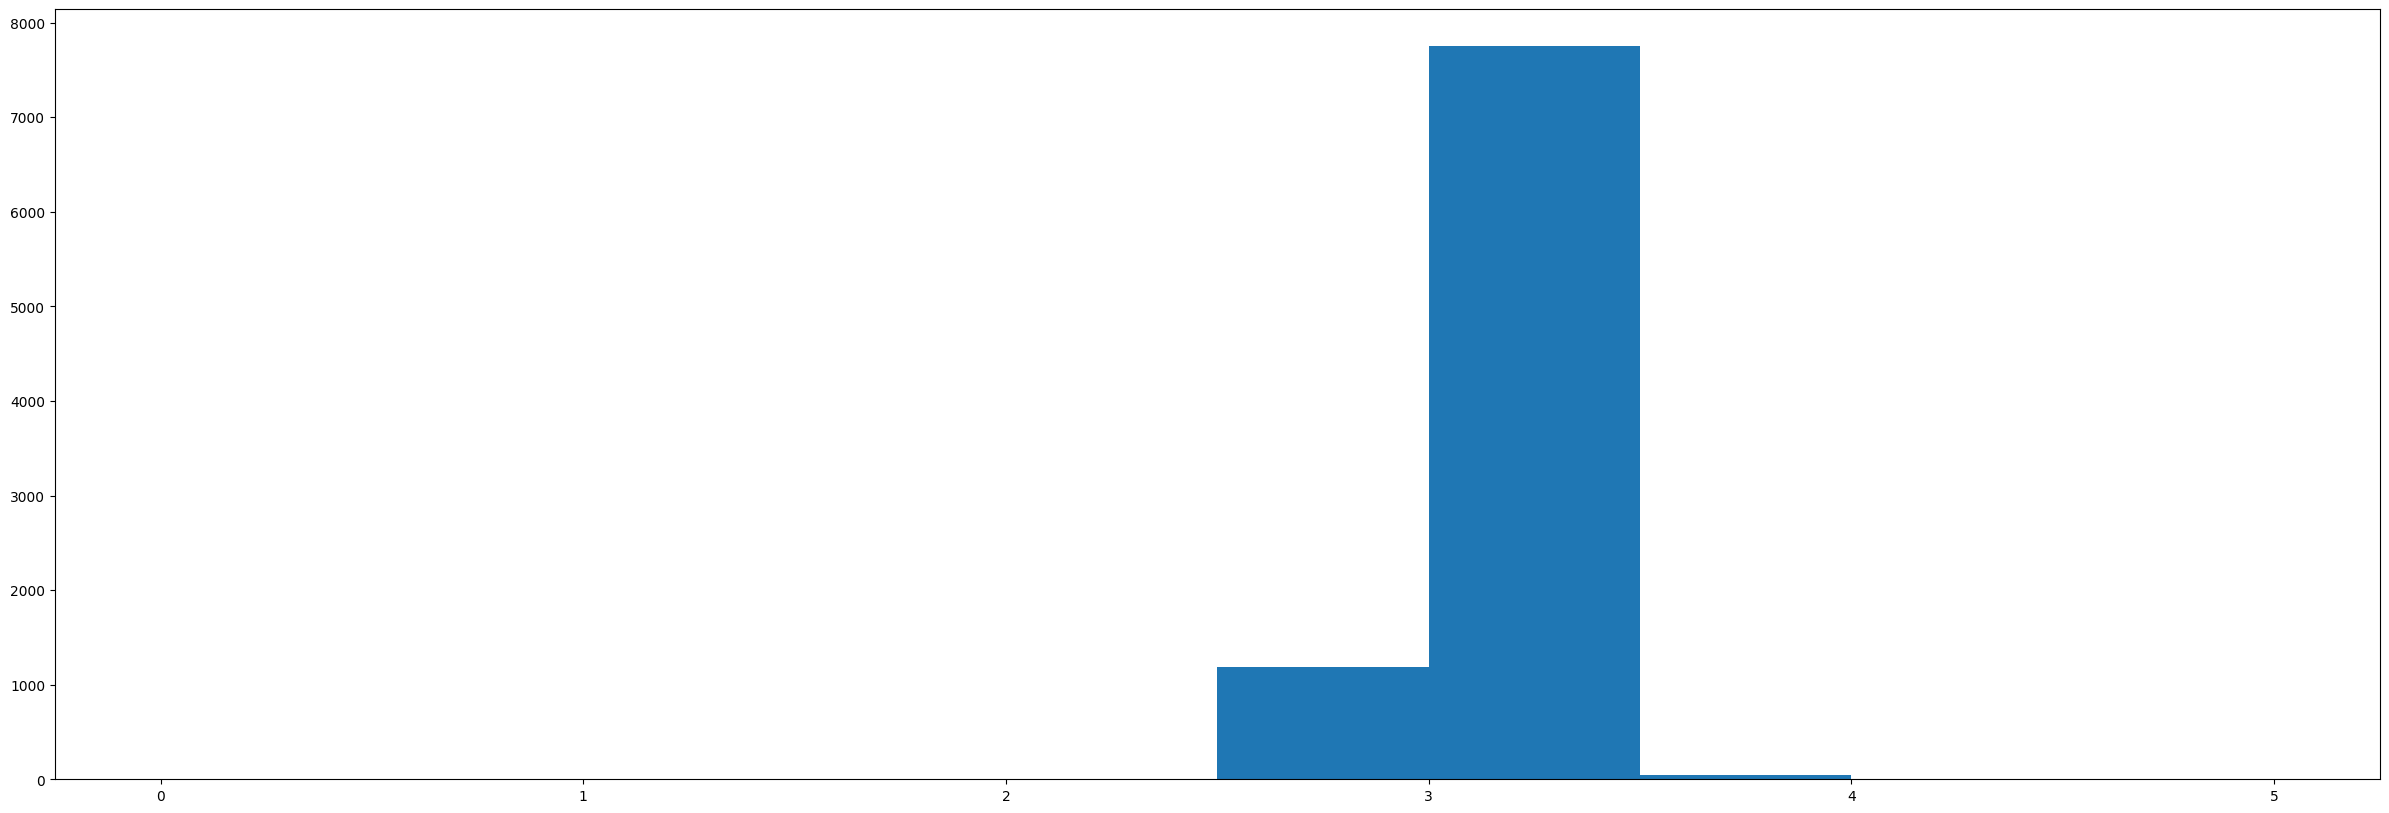

Epoch: 040, Loss: 1.1377, Train: 1.0852, Val: 1.0722, Test: 1.0769
Epoch: 045, Loss: 1.1228, Train: 1.0444, Val: 1.0368, Test: 1.0393


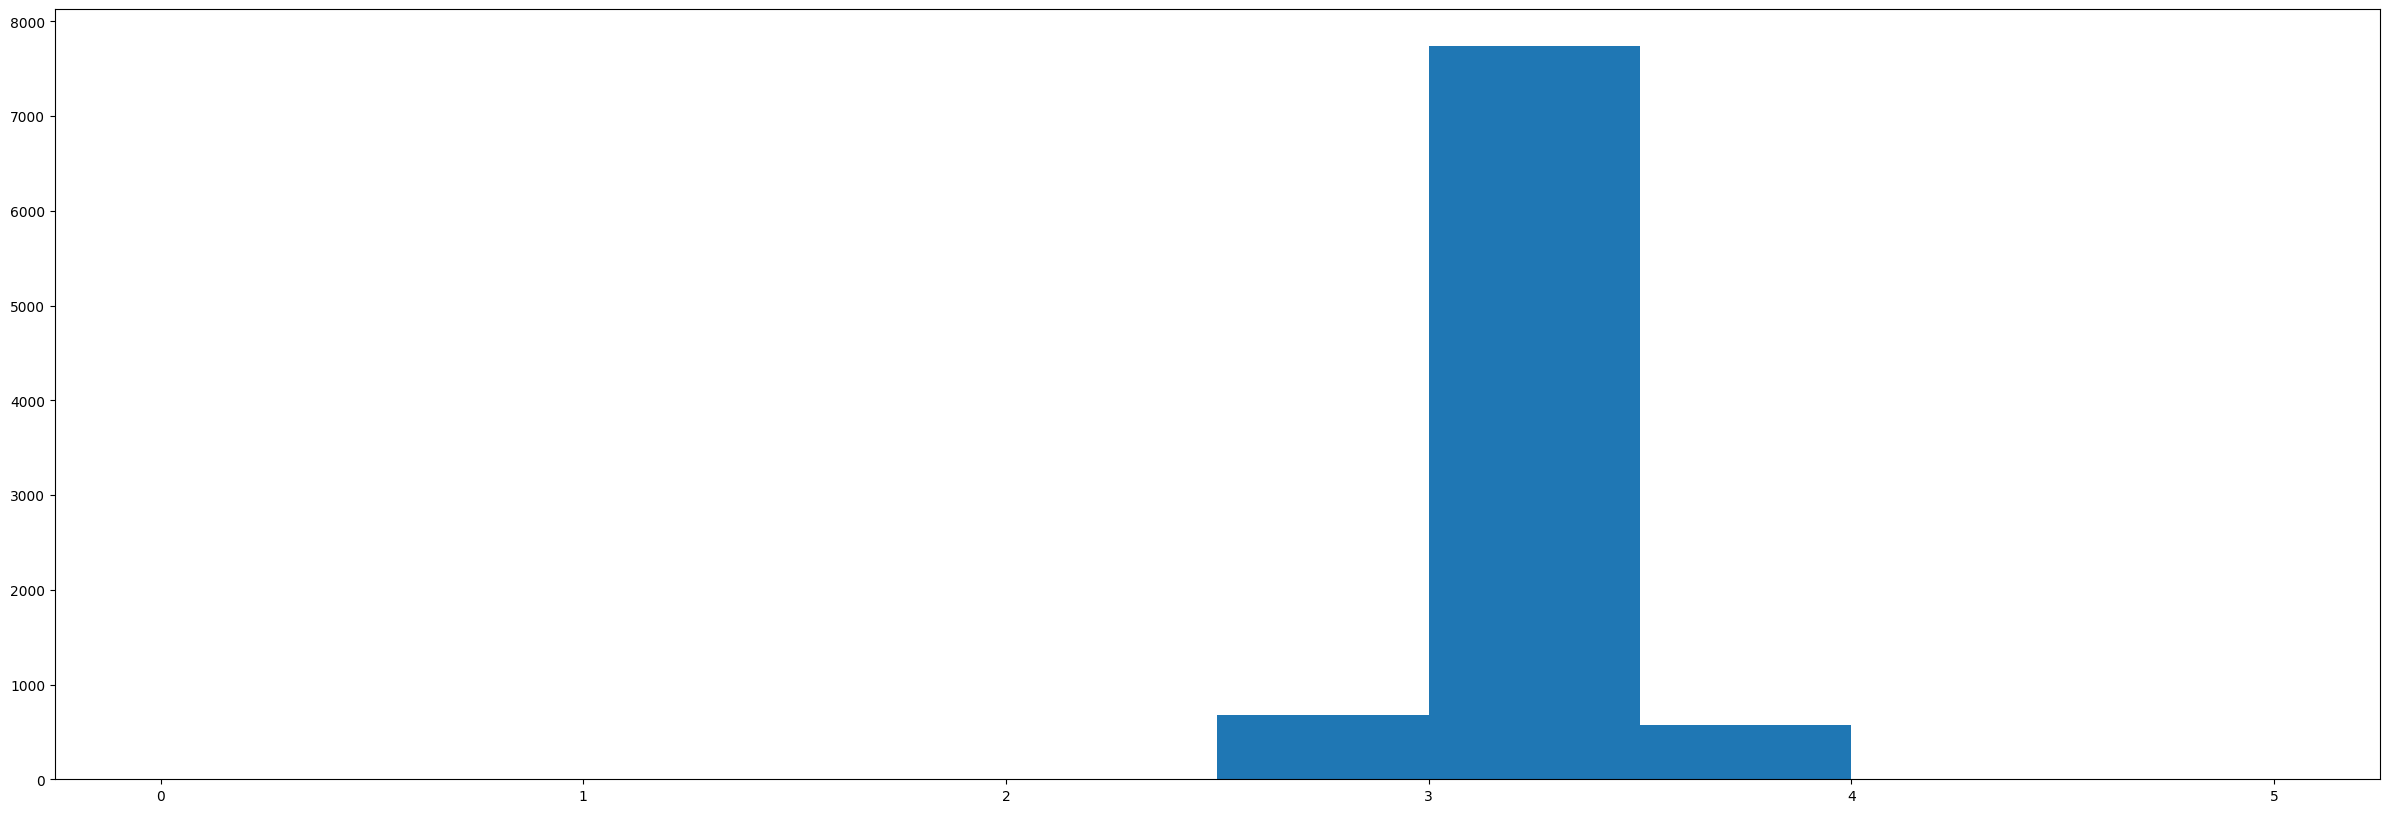

Epoch: 050, Loss: 1.1102, Train: 1.0548, Val: 1.0430, Test: 1.0449
Epoch: 055, Loss: 1.0964, Train: 1.0578, Val: 1.0408, Test: 1.0432


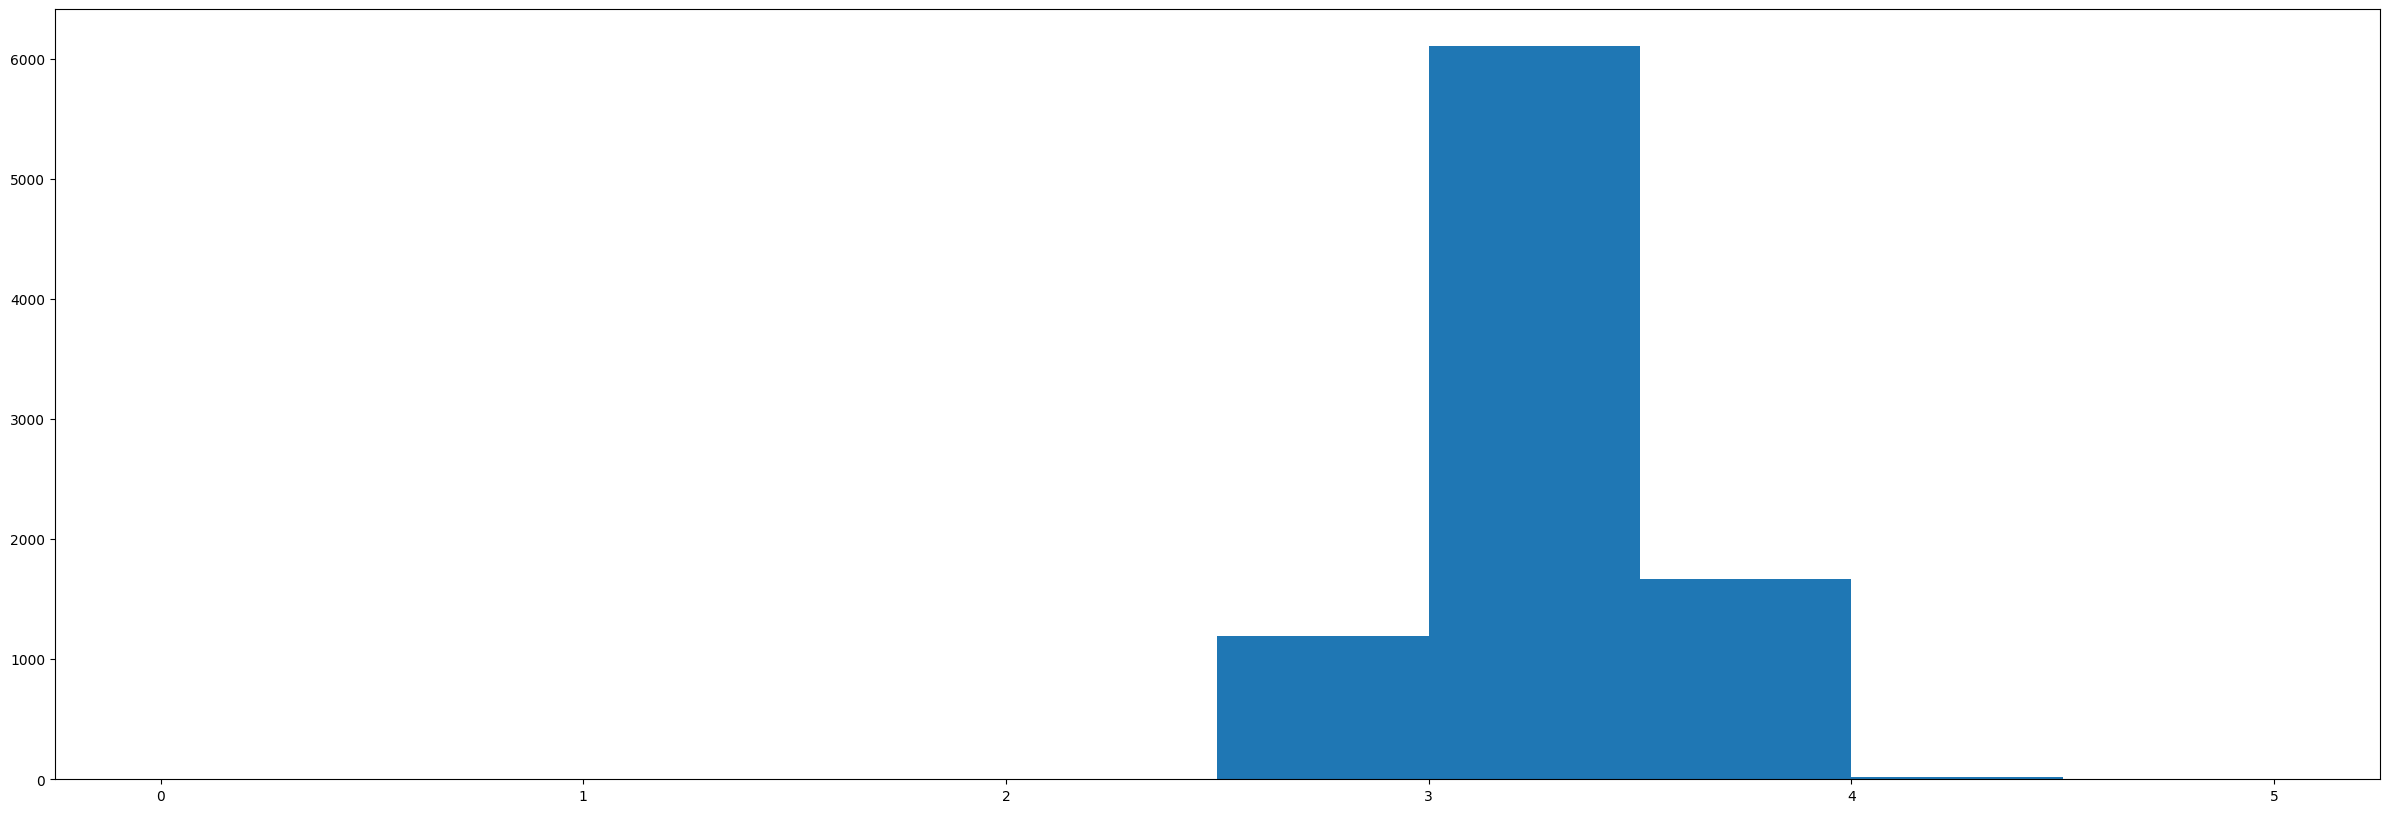

Epoch: 060, Loss: 1.0808, Train: 1.0225, Val: 1.0123, Test: 1.0105
Epoch: 065, Loss: 1.0731, Train: 1.0203, Val: 1.0063, Test: 1.0111


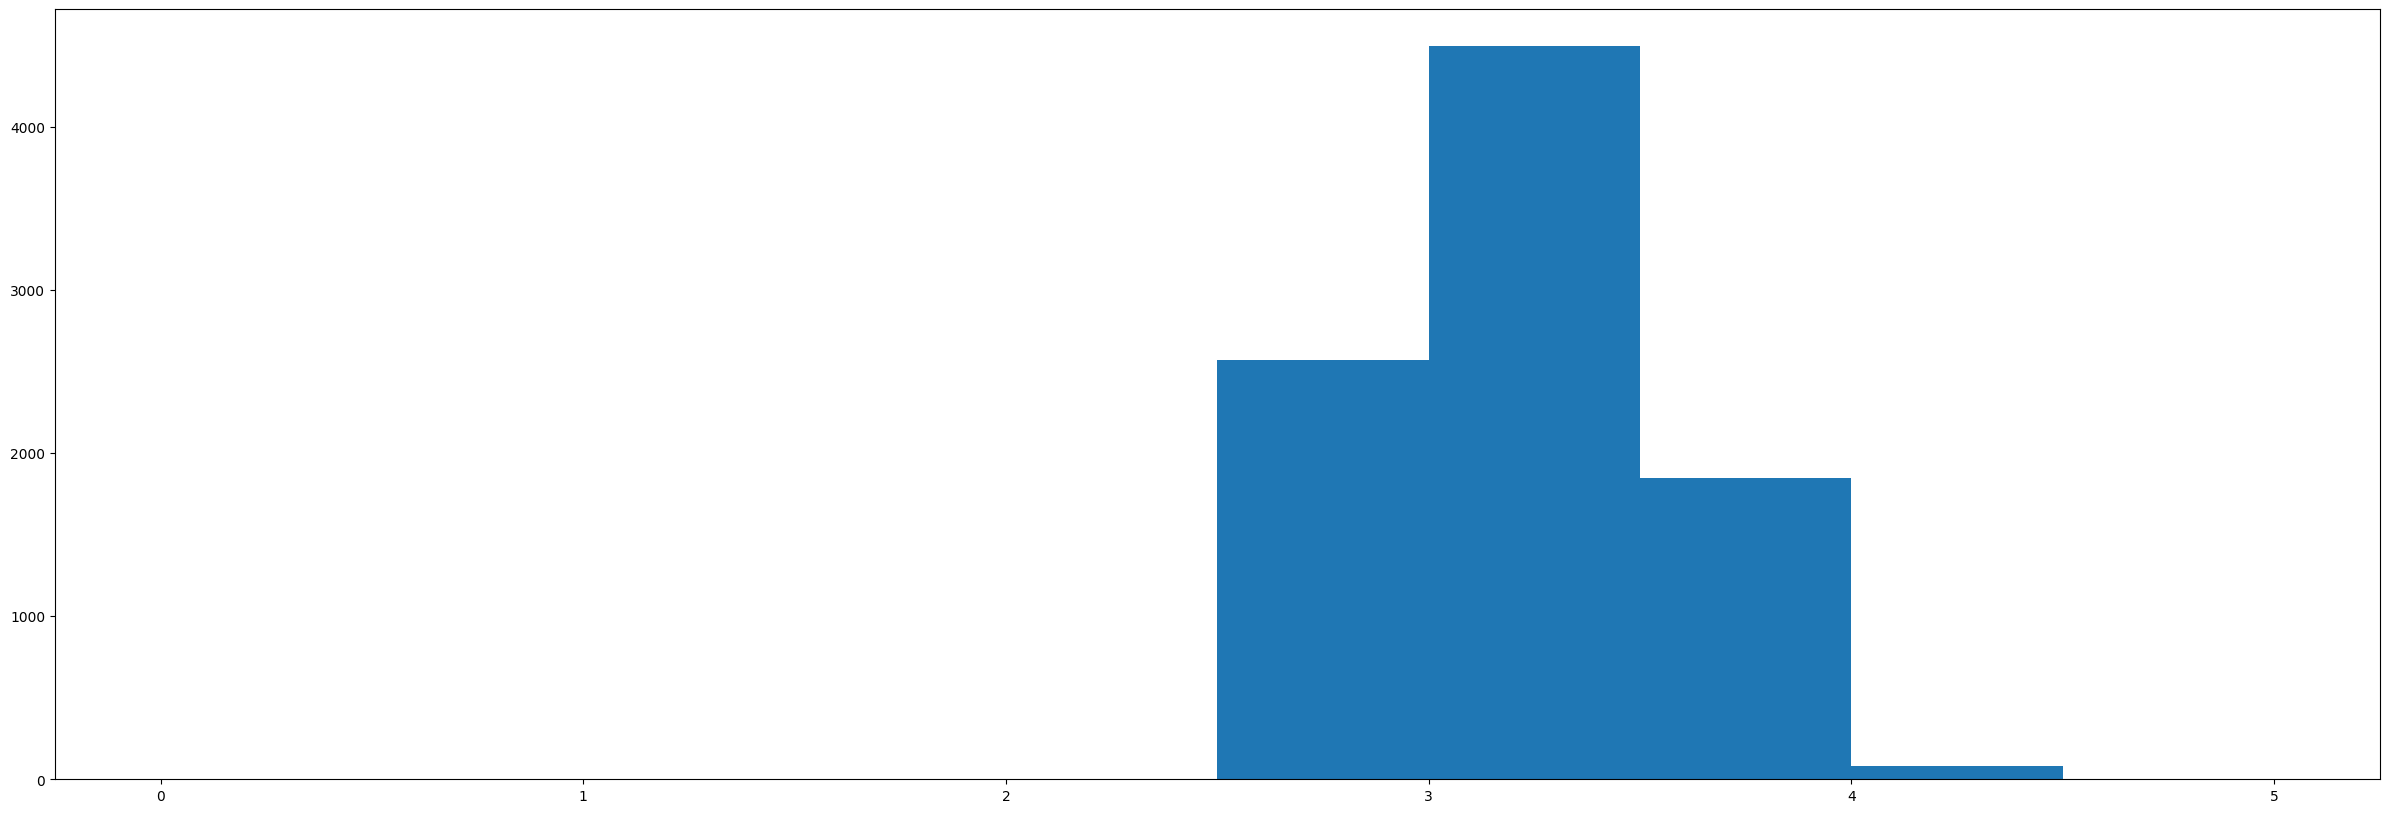

Epoch: 070, Loss: 1.0639, Train: 1.0137, Val: 1.0024, Test: 1.0061
Epoch: 075, Loss: 1.0523, Train: 1.0083, Val: 0.9985, Test: 1.0015


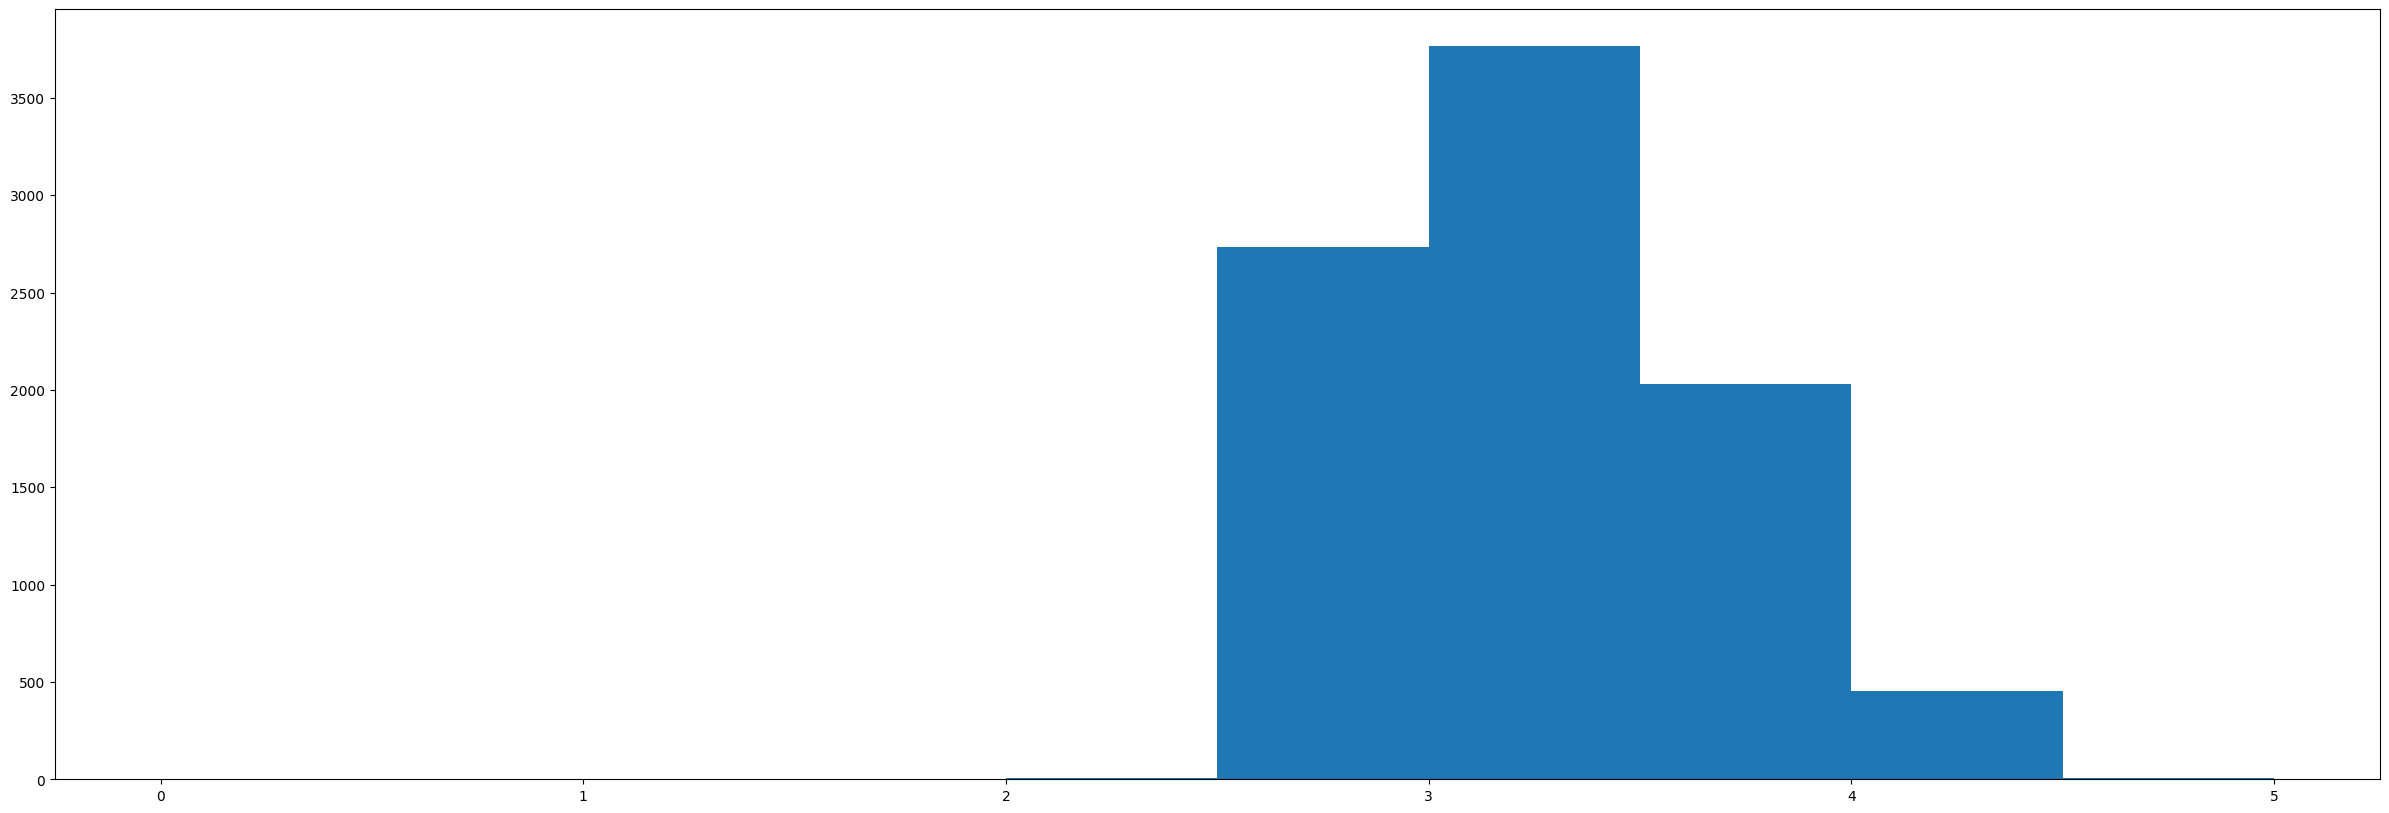

Epoch: 080, Loss: 1.0468, Train: 0.9920, Val: 0.9825, Test: 0.9832
Epoch: 085, Loss: 1.0430, Train: 0.9945, Val: 0.9849, Test: 0.9903


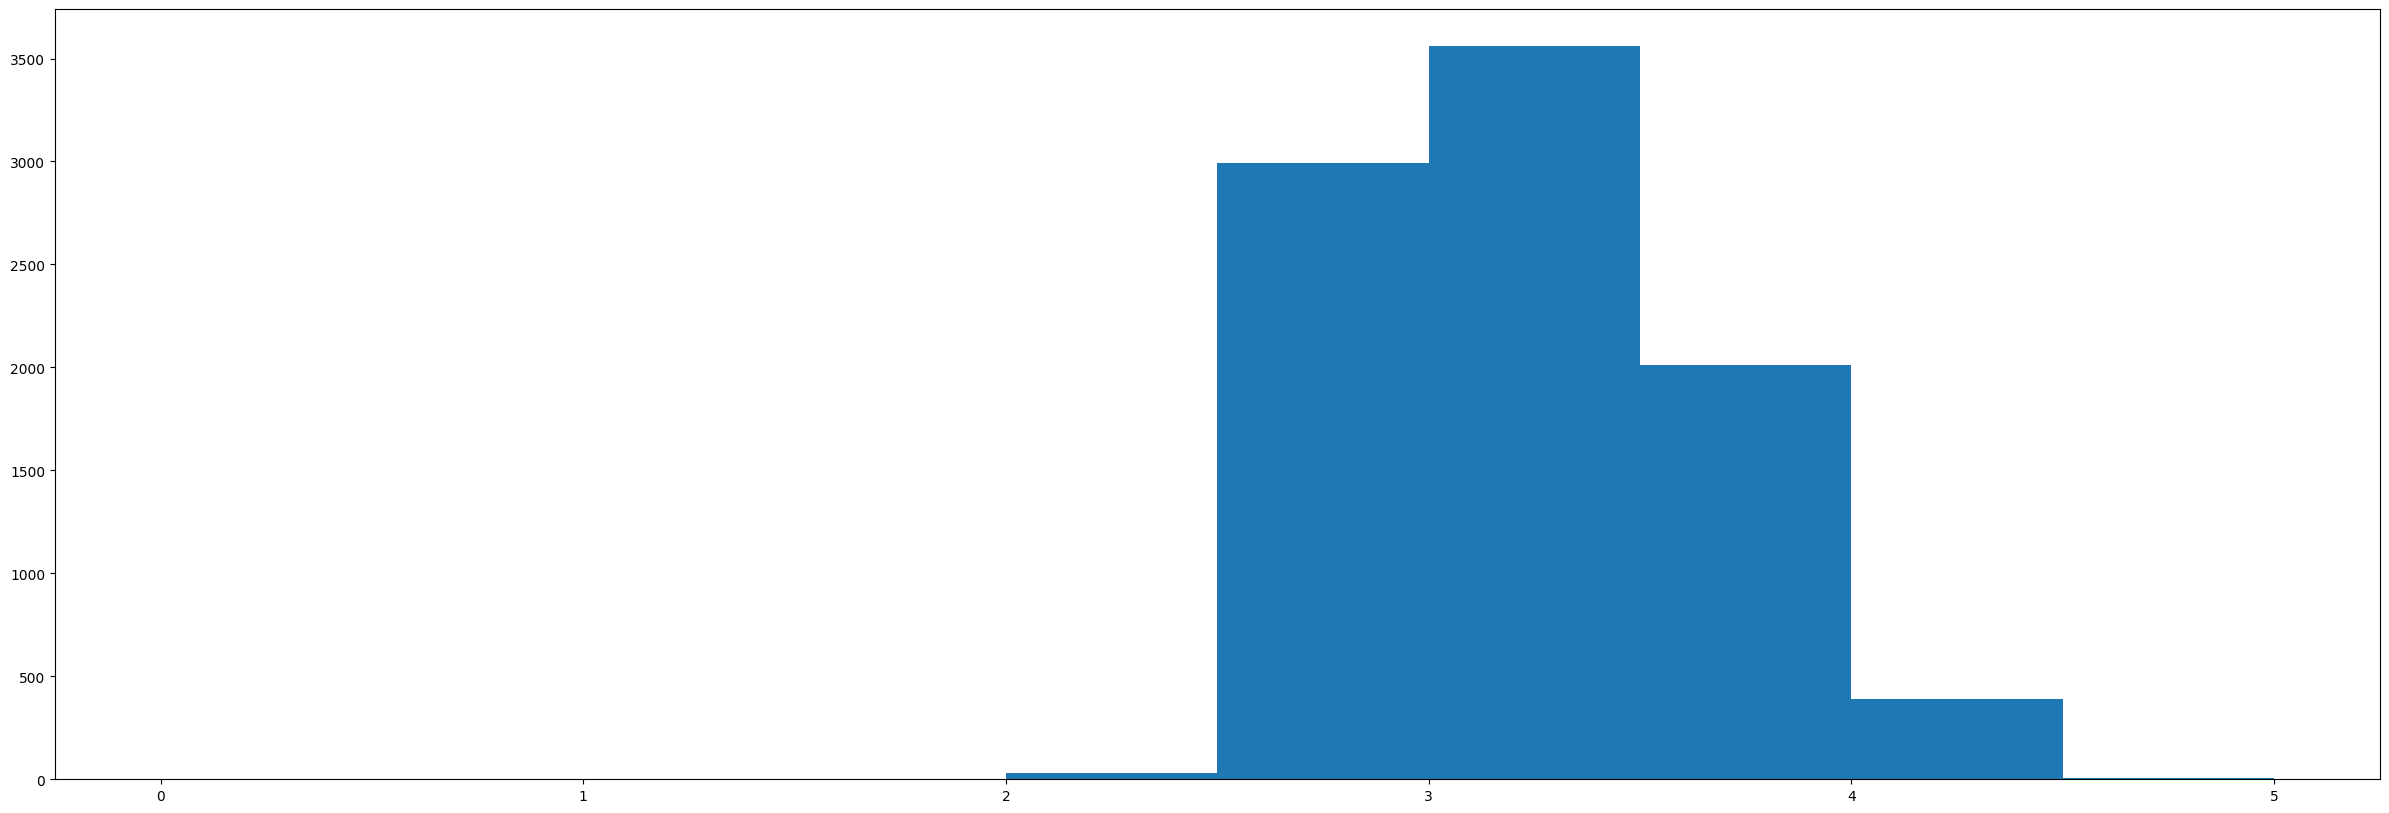

Epoch: 090, Loss: 1.0416, Train: 0.9855, Val: 0.9830, Test: 0.9866
Epoch: 095, Loss: 1.0347, Train: 0.9905, Val: 0.9745, Test: 0.9794


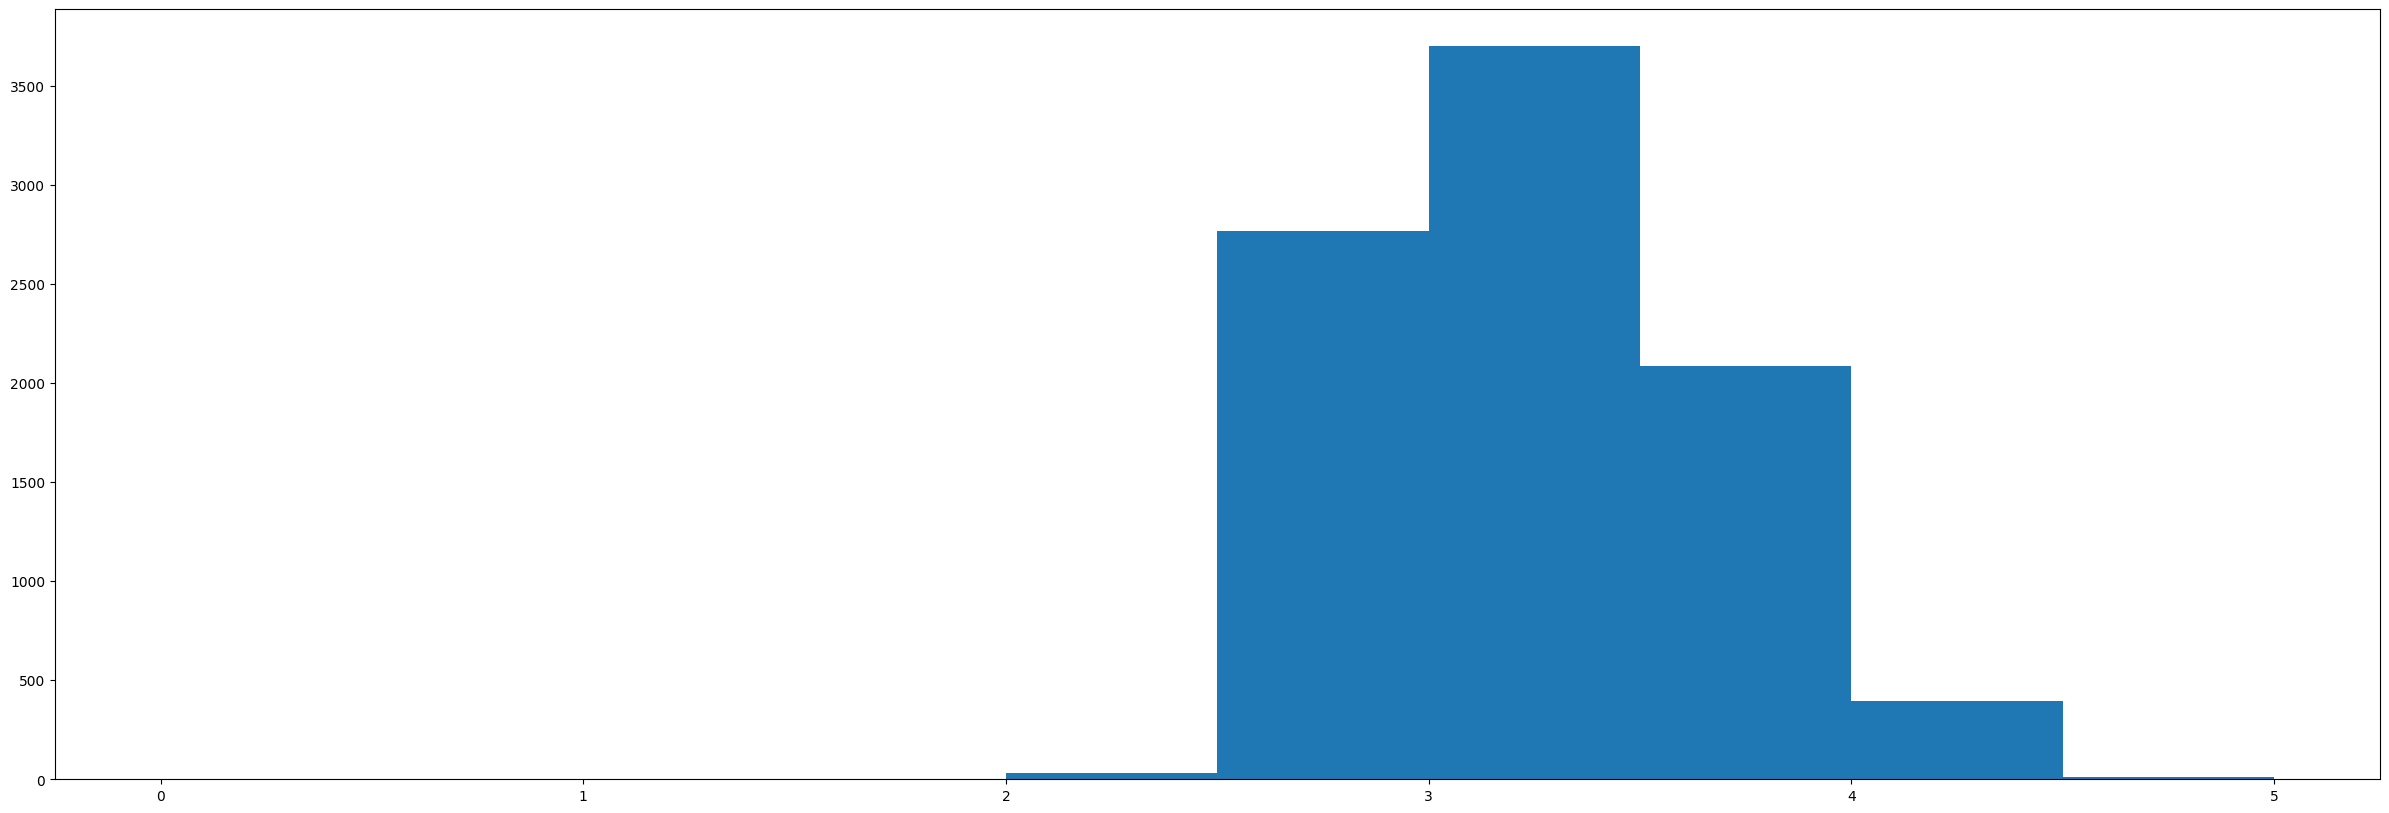

Epoch: 100, Loss: 1.0285, Train: 0.9818, Val: 0.9746, Test: 0.9794
Epoch: 105, Loss: 1.0275, Train: 0.9946, Val: 0.9834, Test: 0.9871


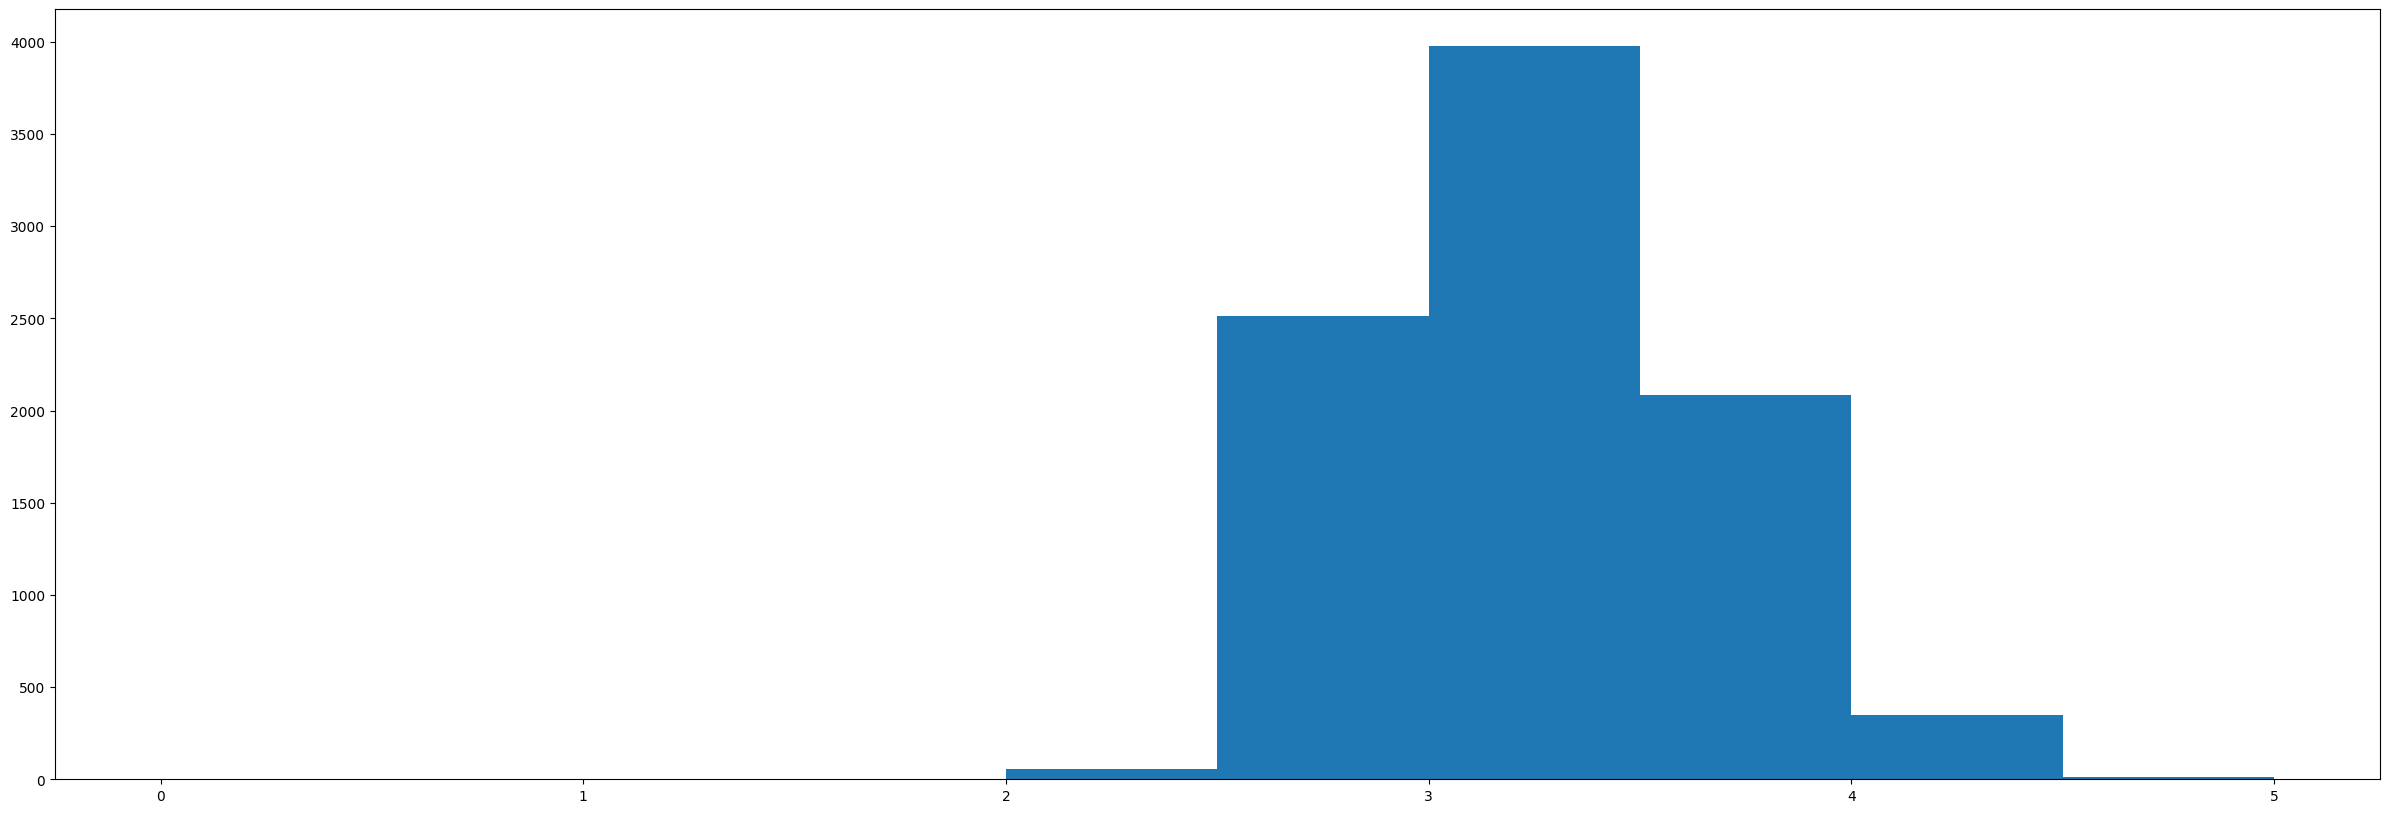

Epoch: 110, Loss: 1.0257, Train: 0.9761, Val: 0.9753, Test: 0.9741
Epoch: 115, Loss: 1.0199, Train: 0.9802, Val: 0.9727, Test: 0.9769


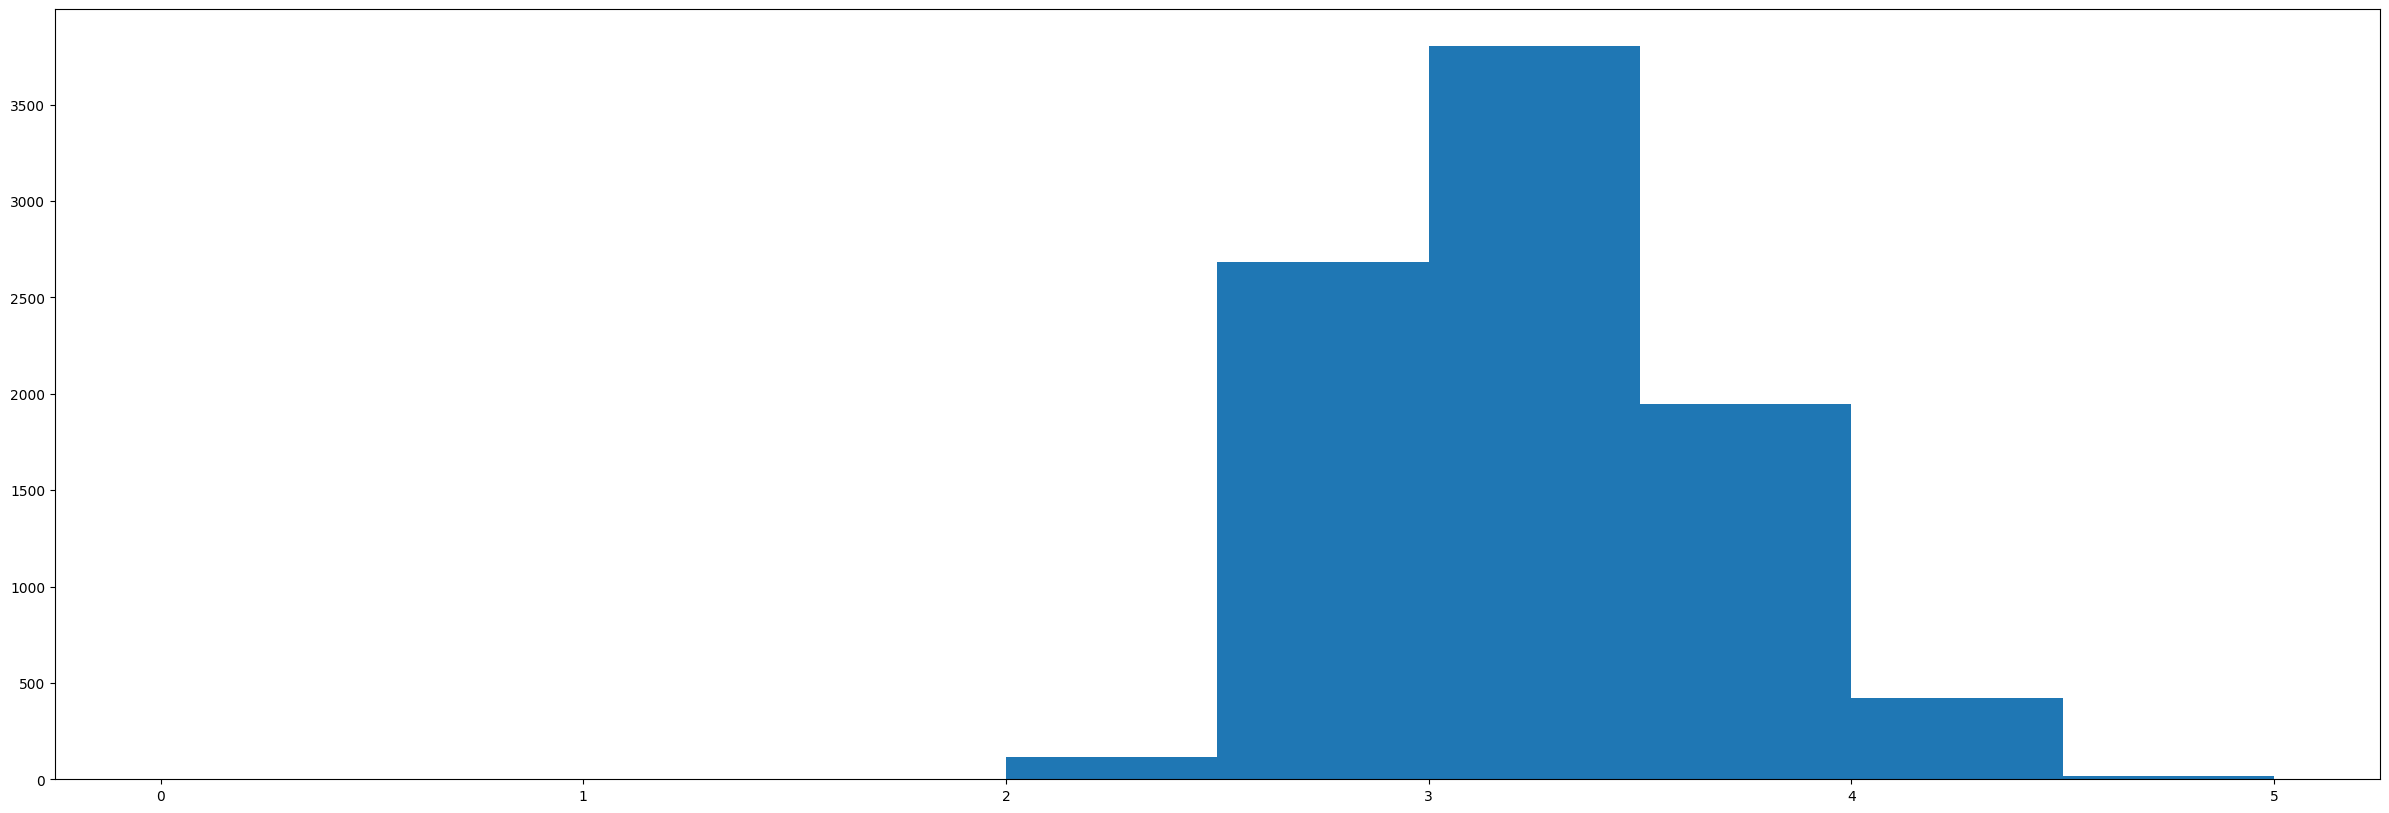

Epoch: 120, Loss: 1.0172, Train: 0.9755, Val: 0.9685, Test: 0.9730
Epoch: 125, Loss: 1.0145, Train: 0.9782, Val: 0.9677, Test: 0.9737


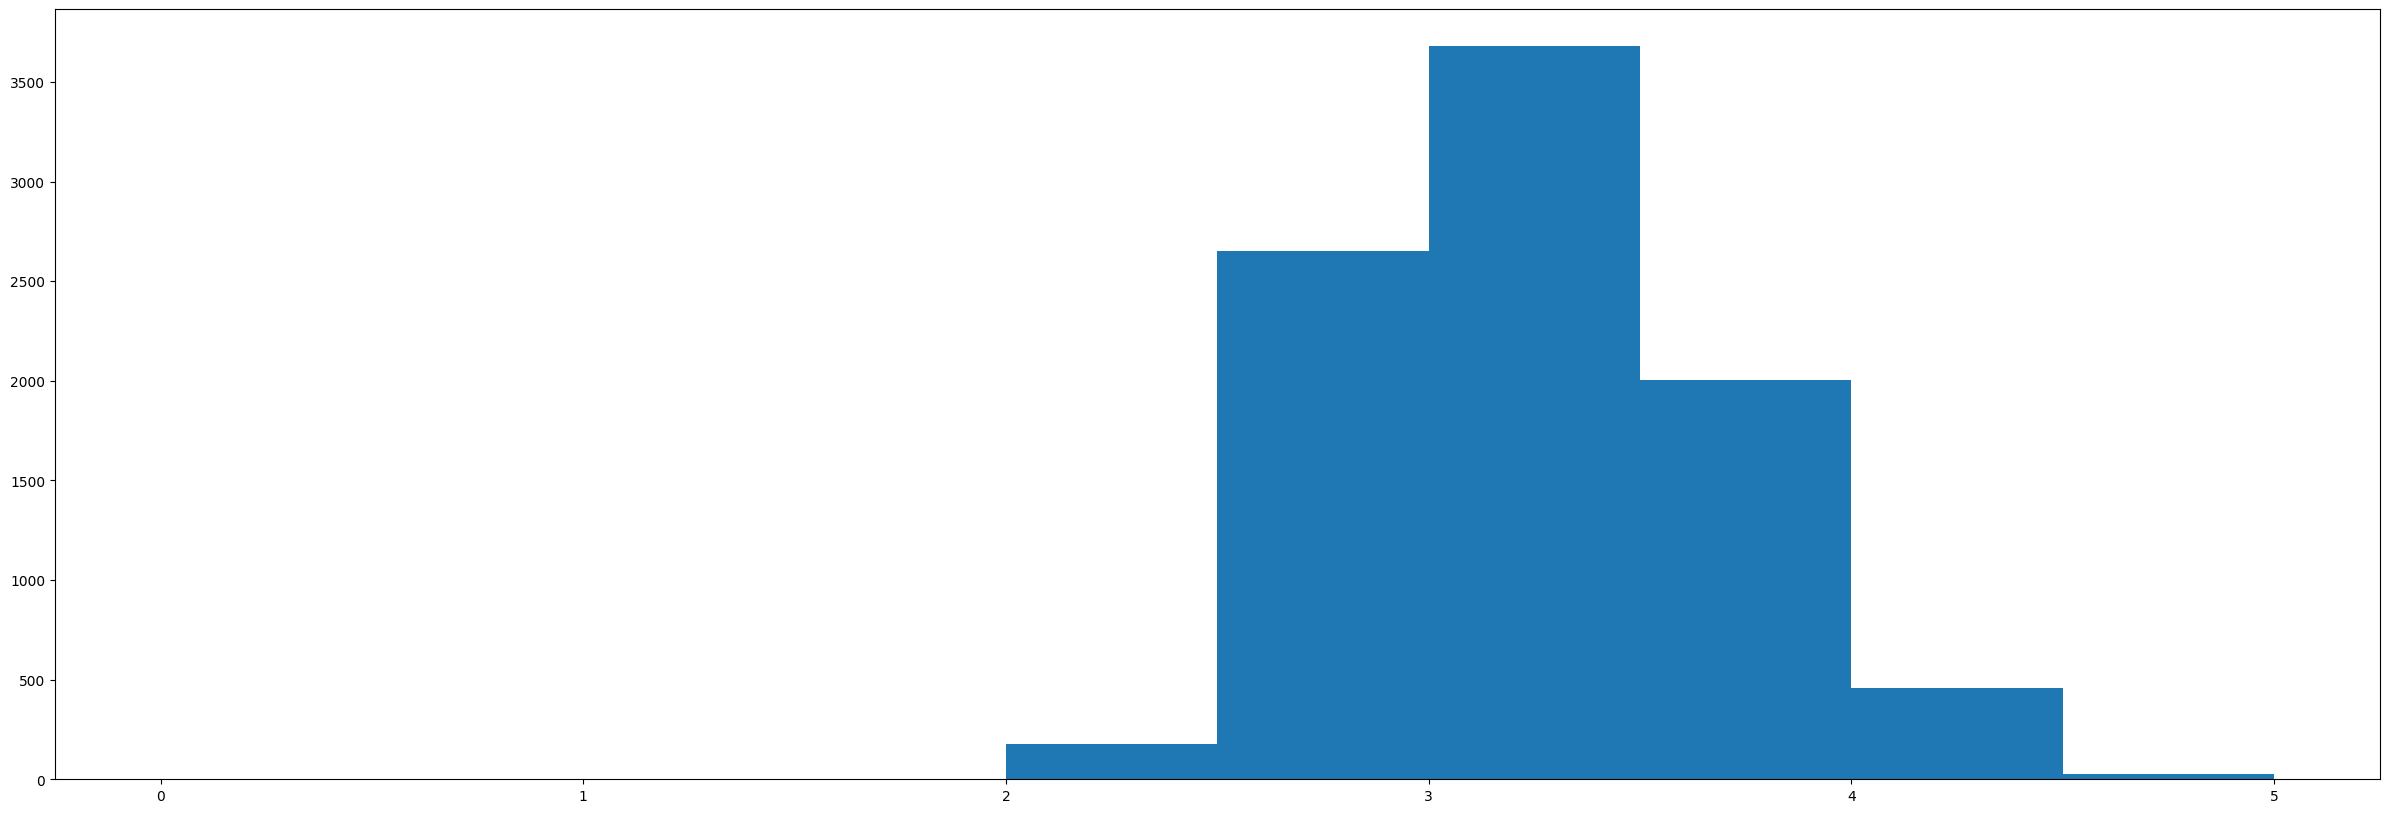

Epoch: 130, Loss: 1.0090, Train: 0.9728, Val: 0.9729, Test: 0.9689
Epoch: 135, Loss: 1.0075, Train: 0.9806, Val: 0.9660, Test: 0.9806


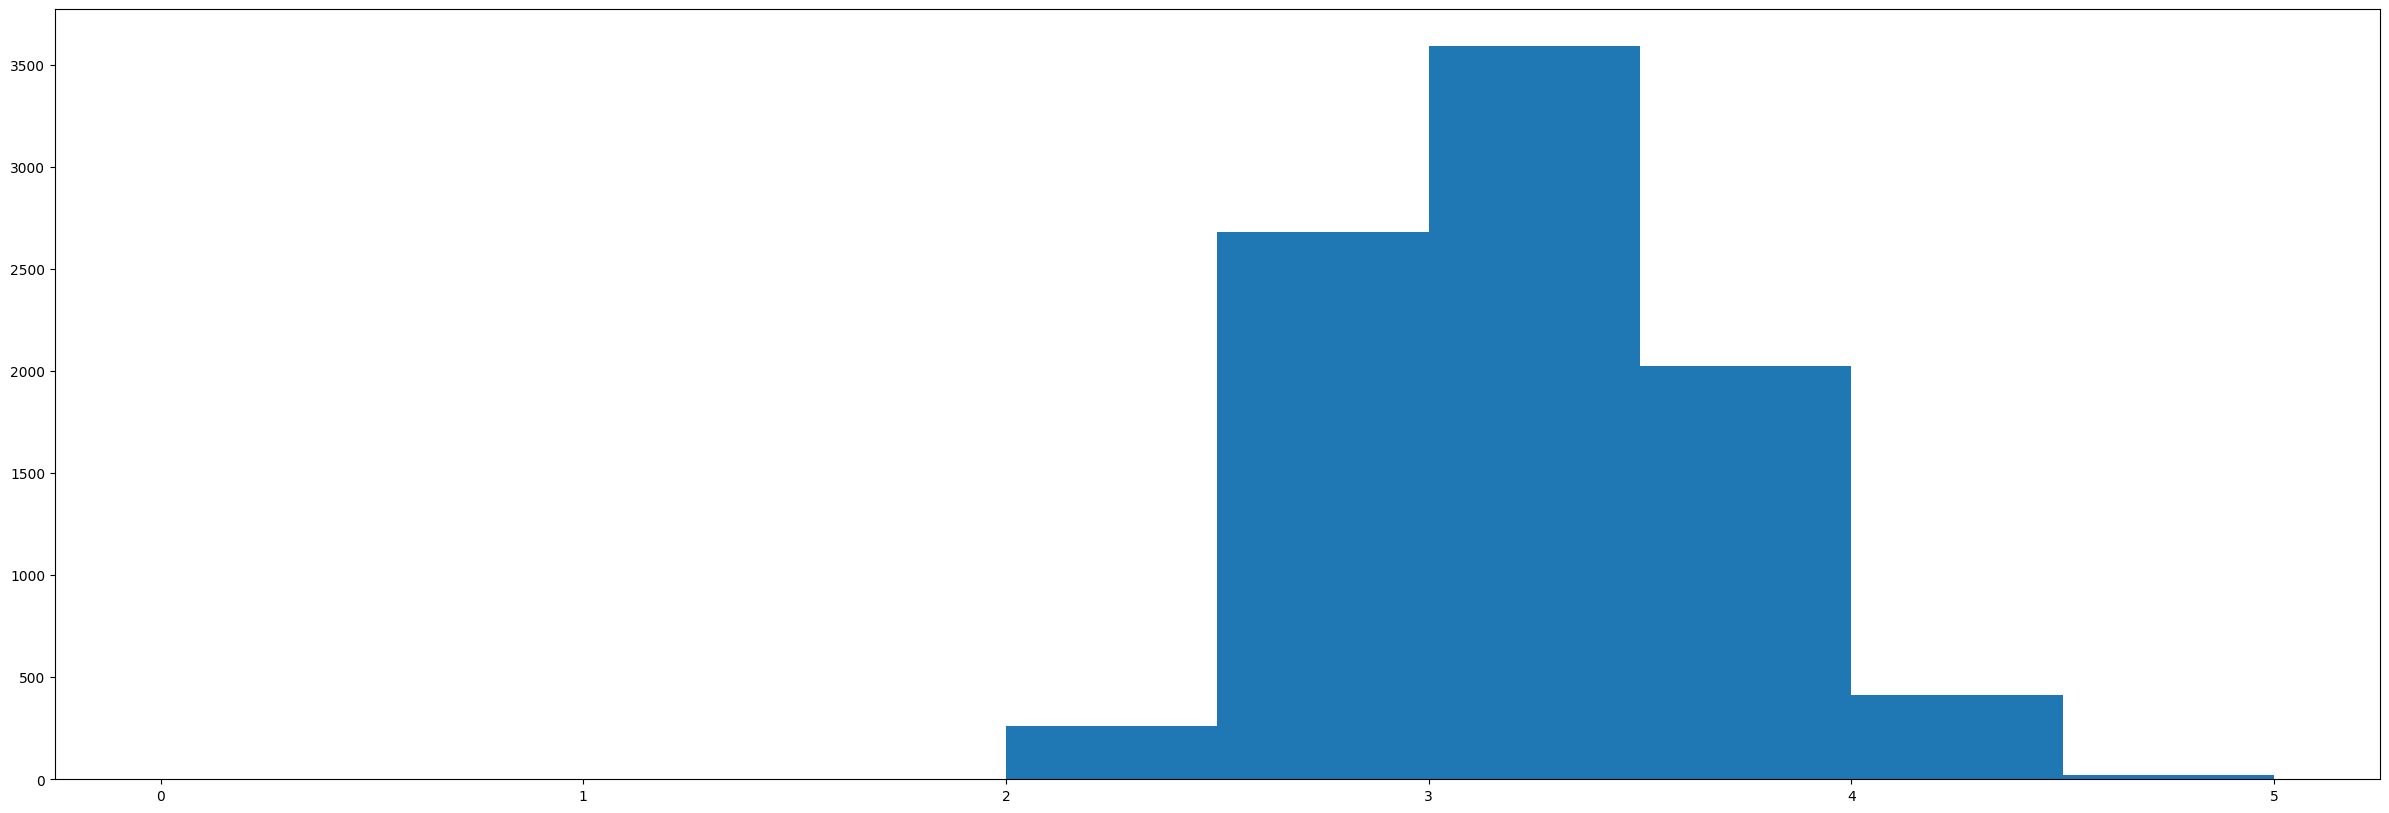

Epoch: 140, Loss: 1.0068, Train: 0.9686, Val: 0.9645, Test: 0.9656
Epoch: 145, Loss: 1.0046, Train: 0.9647, Val: 0.9509, Test: 0.9572


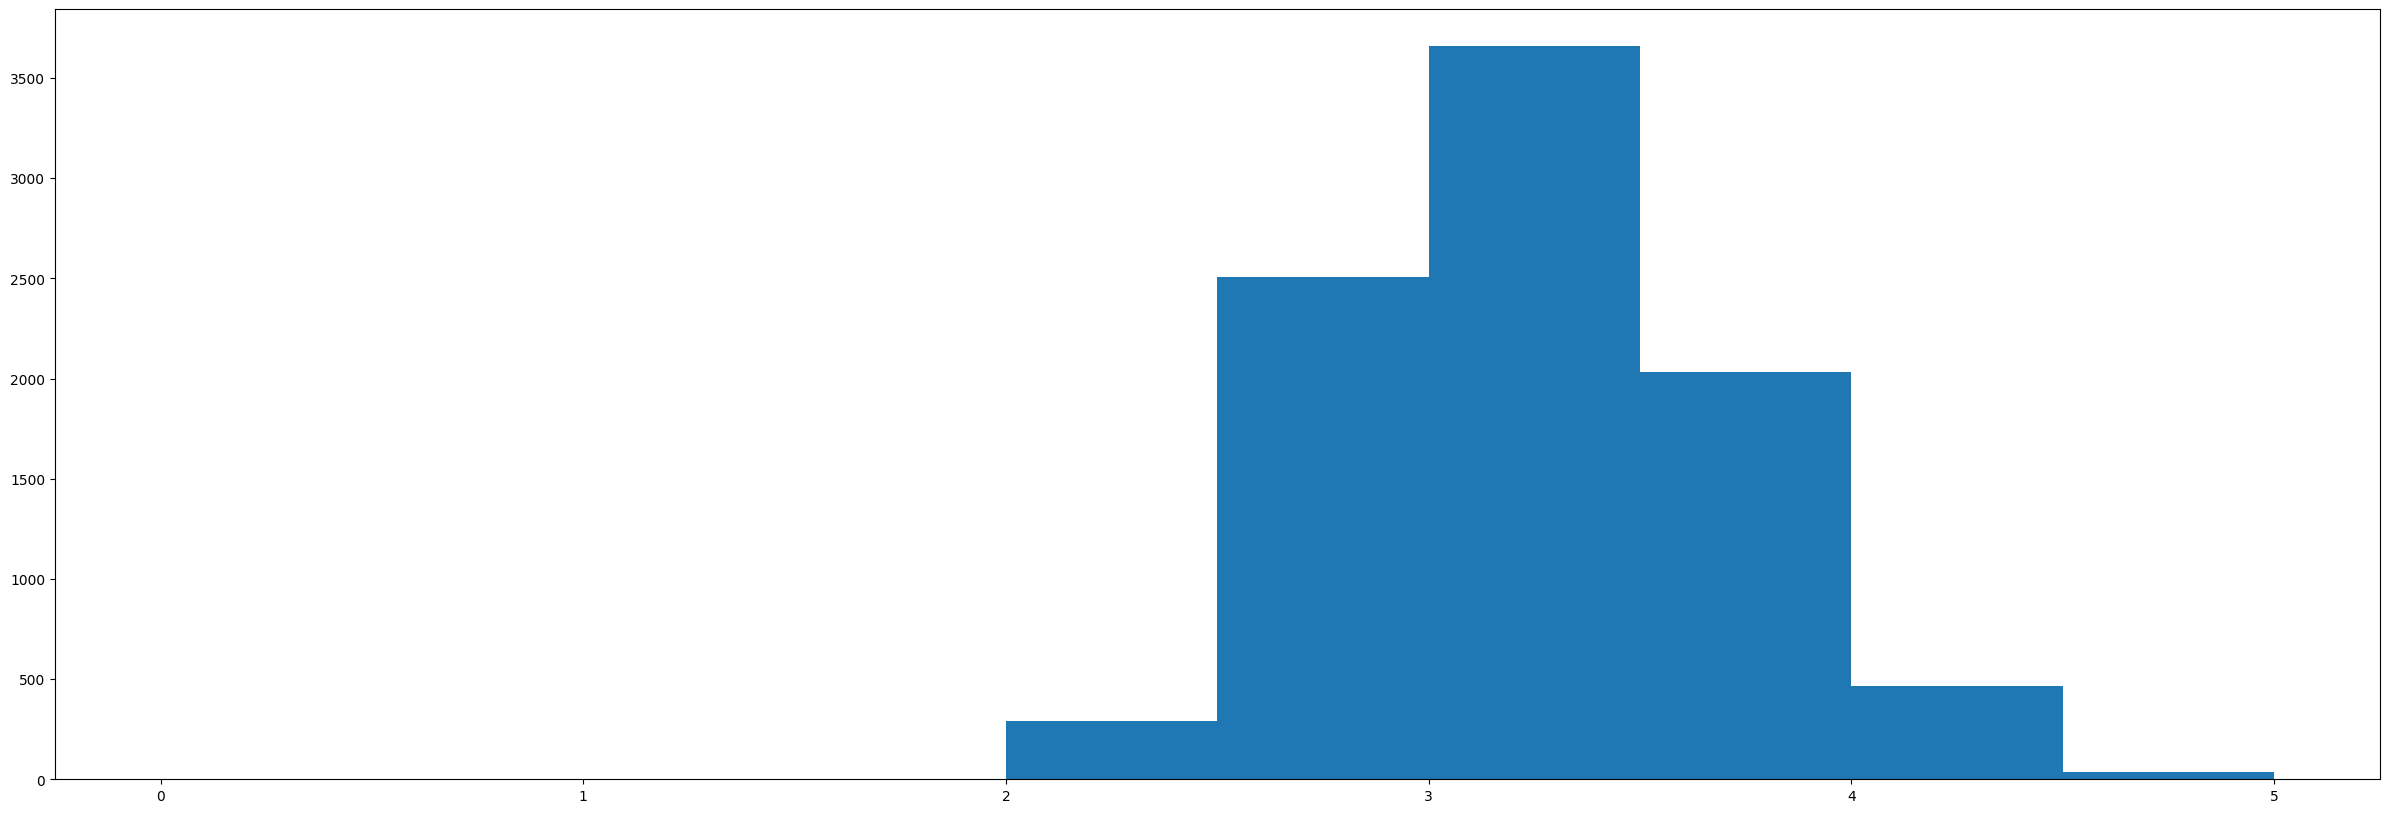

Epoch: 150, Loss: 0.9968, Train: 0.9662, Val: 0.9593, Test: 0.9608
Epoch: 155, Loss: 0.9965, Train: 0.9650, Val: 0.9615, Test: 0.9645


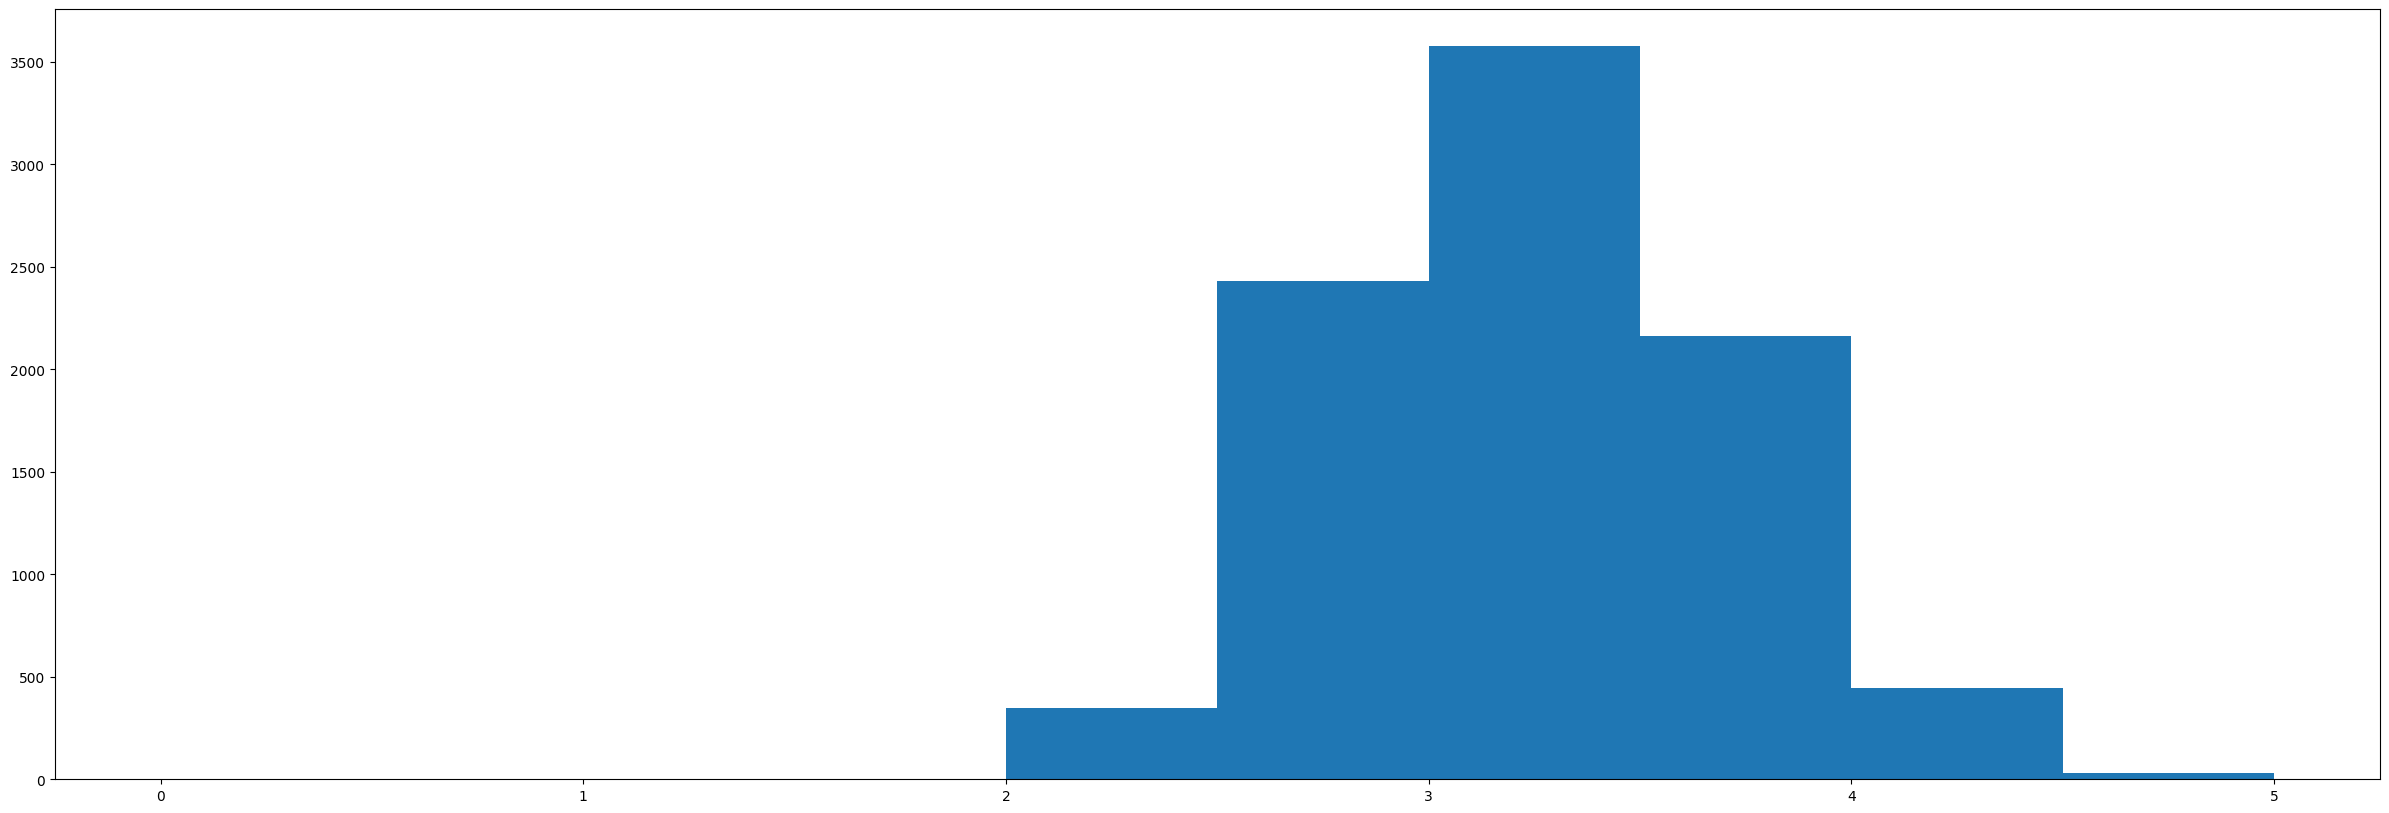

Epoch: 160, Loss: 0.9968, Train: 0.9593, Val: 0.9472, Test: 0.9548
Epoch: 165, Loss: 0.9938, Train: 0.9529, Val: 0.9448, Test: 0.9475


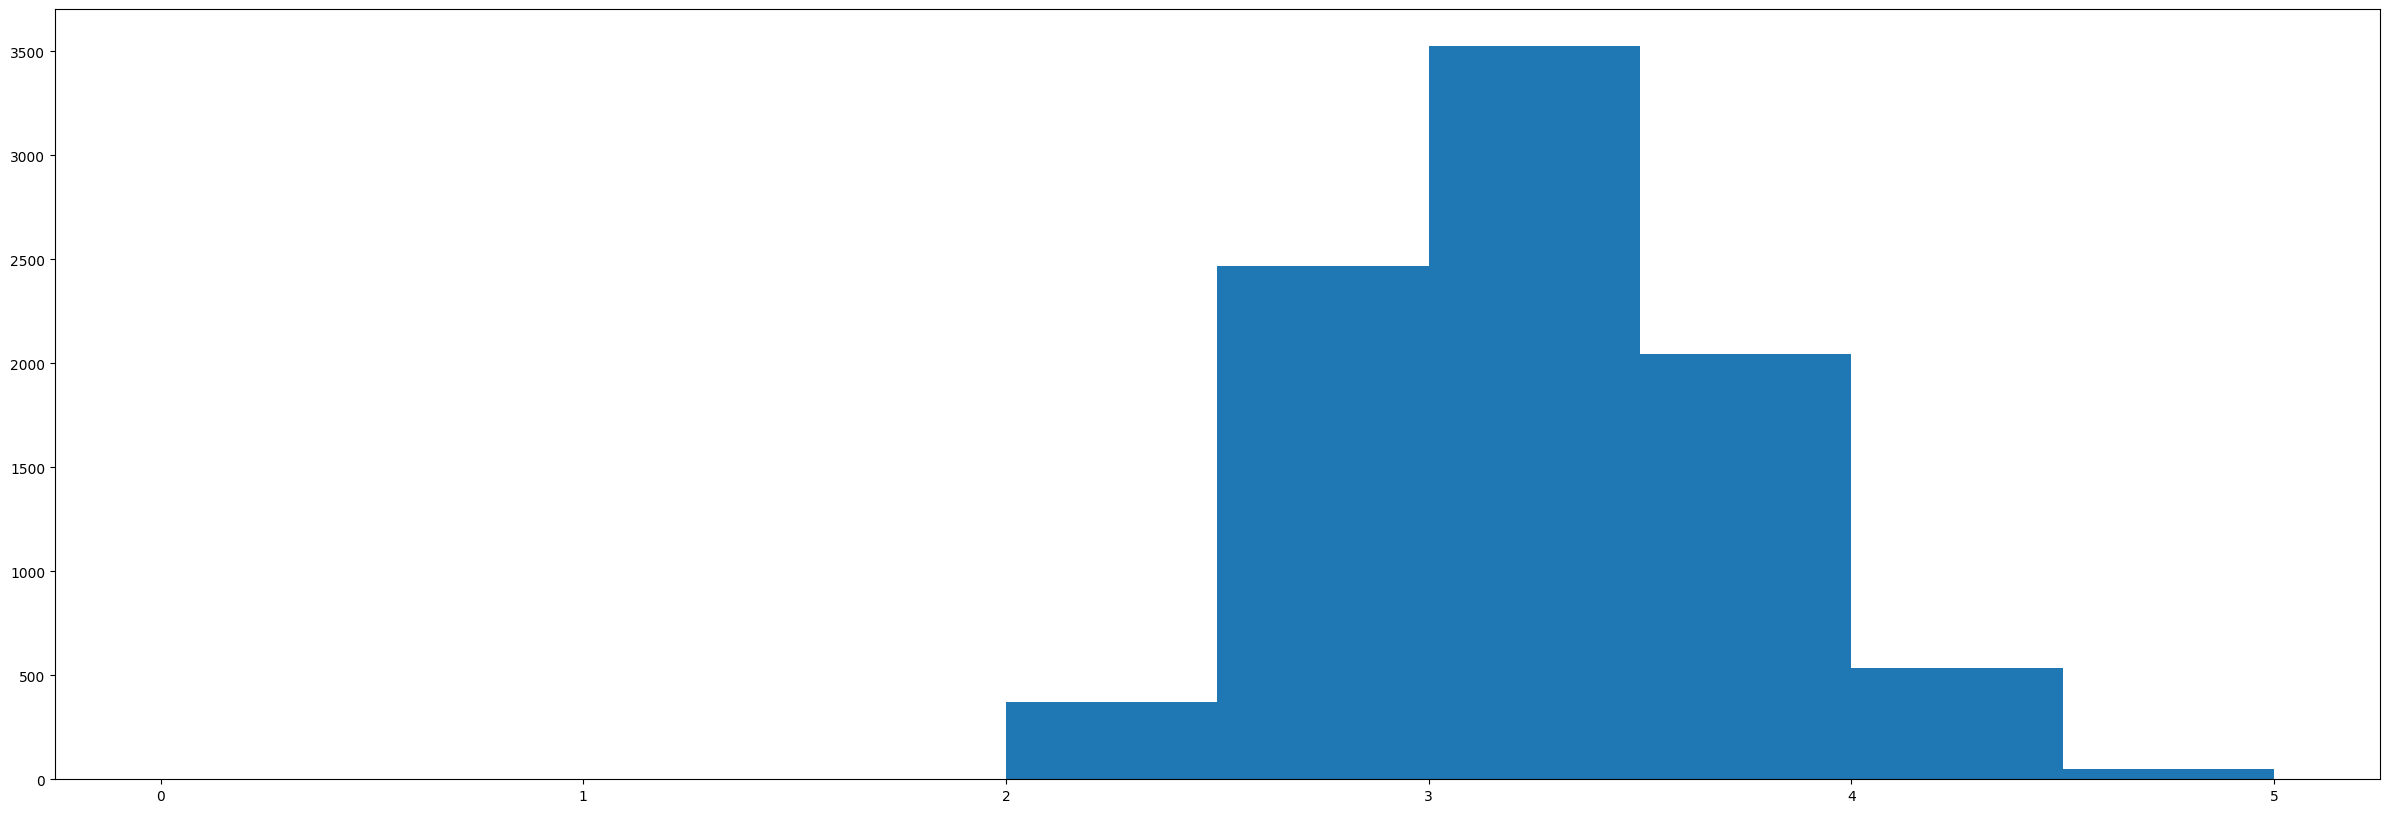

Epoch: 170, Loss: 0.9928, Train: 0.9565, Val: 0.9525, Test: 0.9501
Epoch: 175, Loss: 0.9879, Train: 0.9515, Val: 0.9498, Test: 0.9443


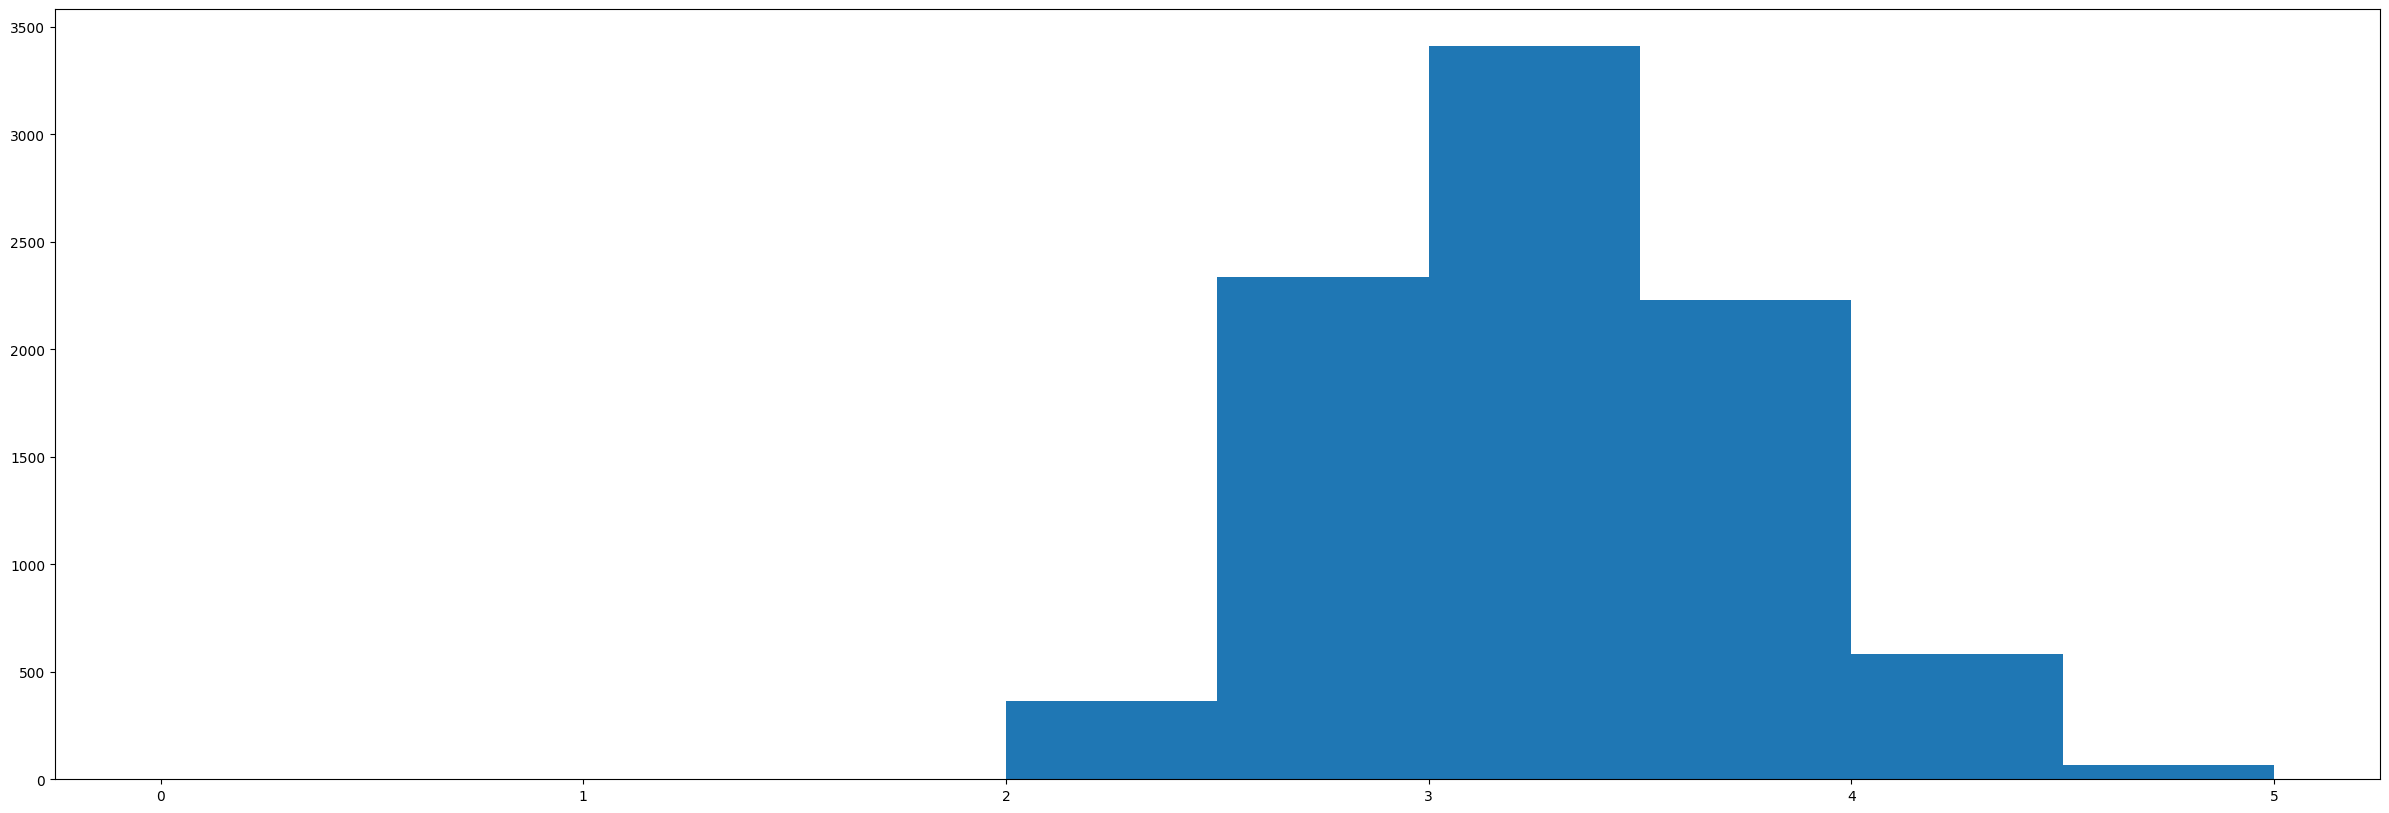

Epoch: 180, Loss: 0.9886, Train: 0.9468, Val: 0.9447, Test: 0.9430
Epoch: 185, Loss: 0.9876, Train: 0.9468, Val: 0.9431, Test: 0.9464


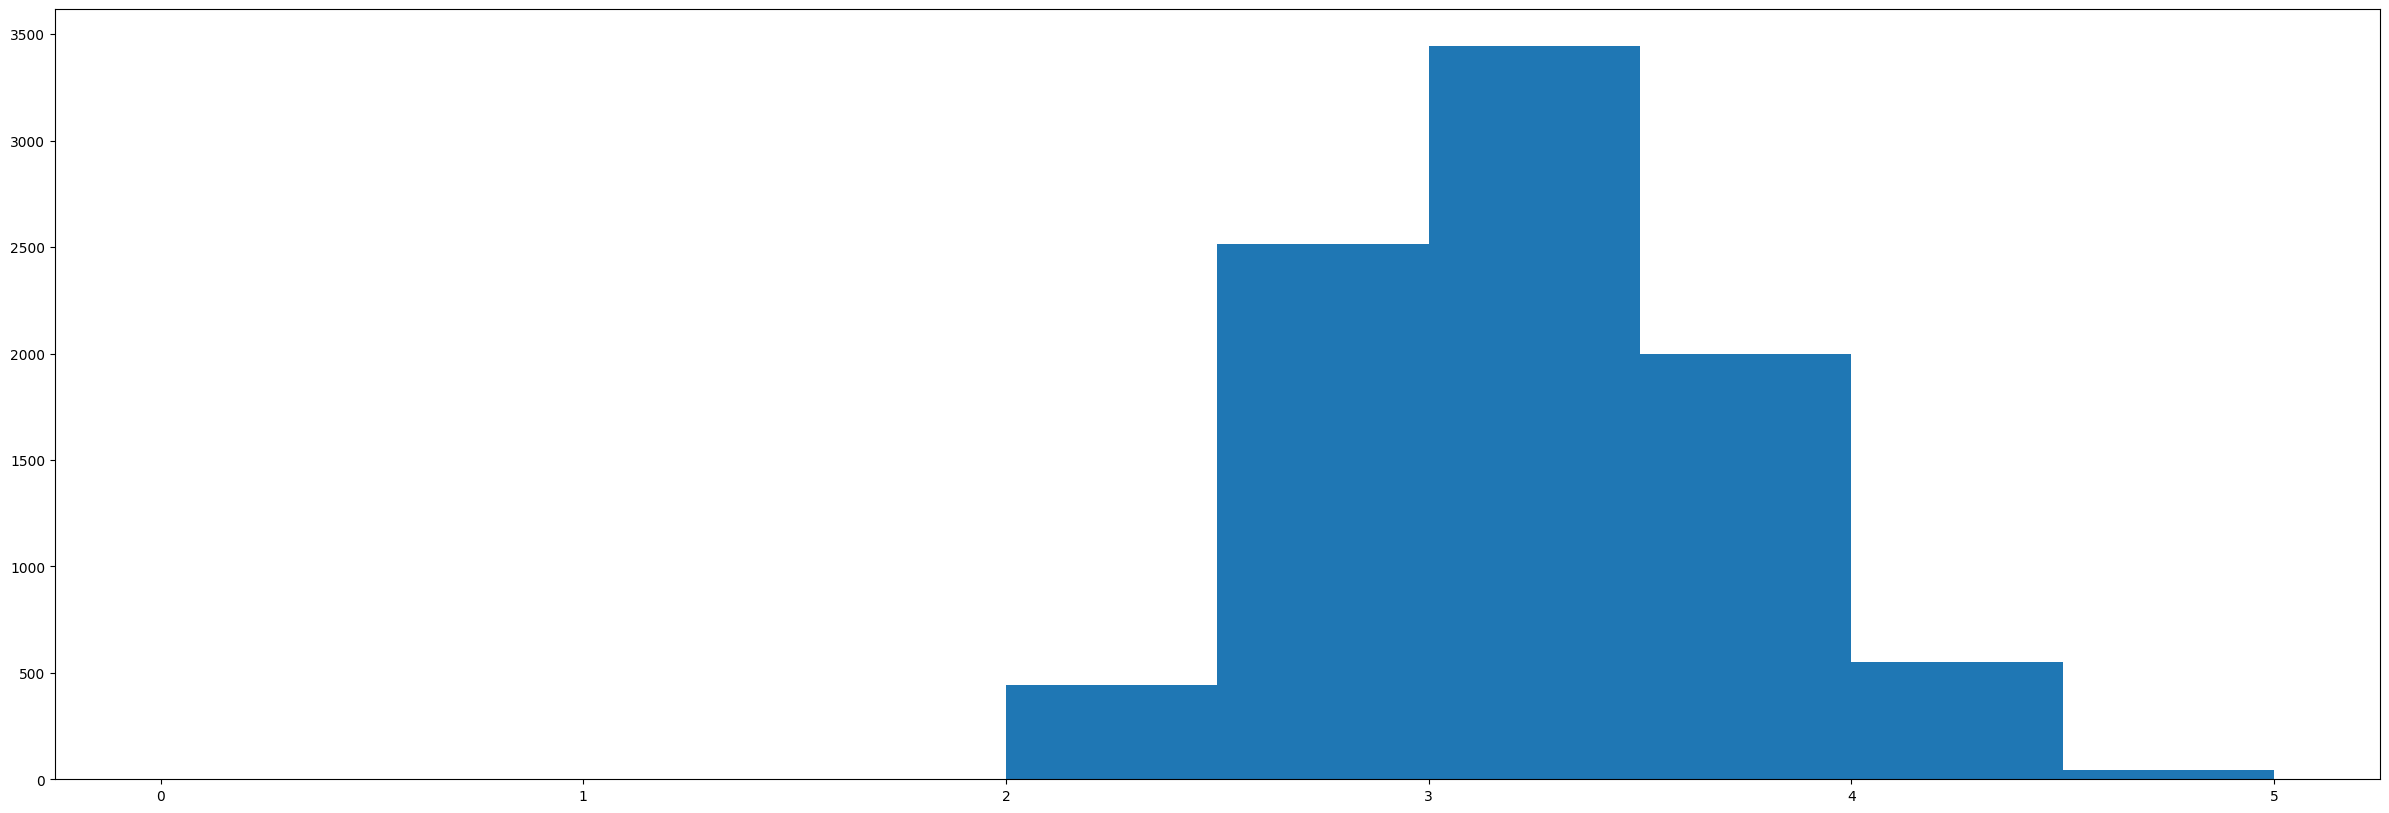

Epoch: 190, Loss: 0.9835, Train: 0.9535, Val: 0.9535, Test: 0.9519
Epoch: 195, Loss: 0.9837, Train: 0.9538, Val: 0.9473, Test: 0.9537


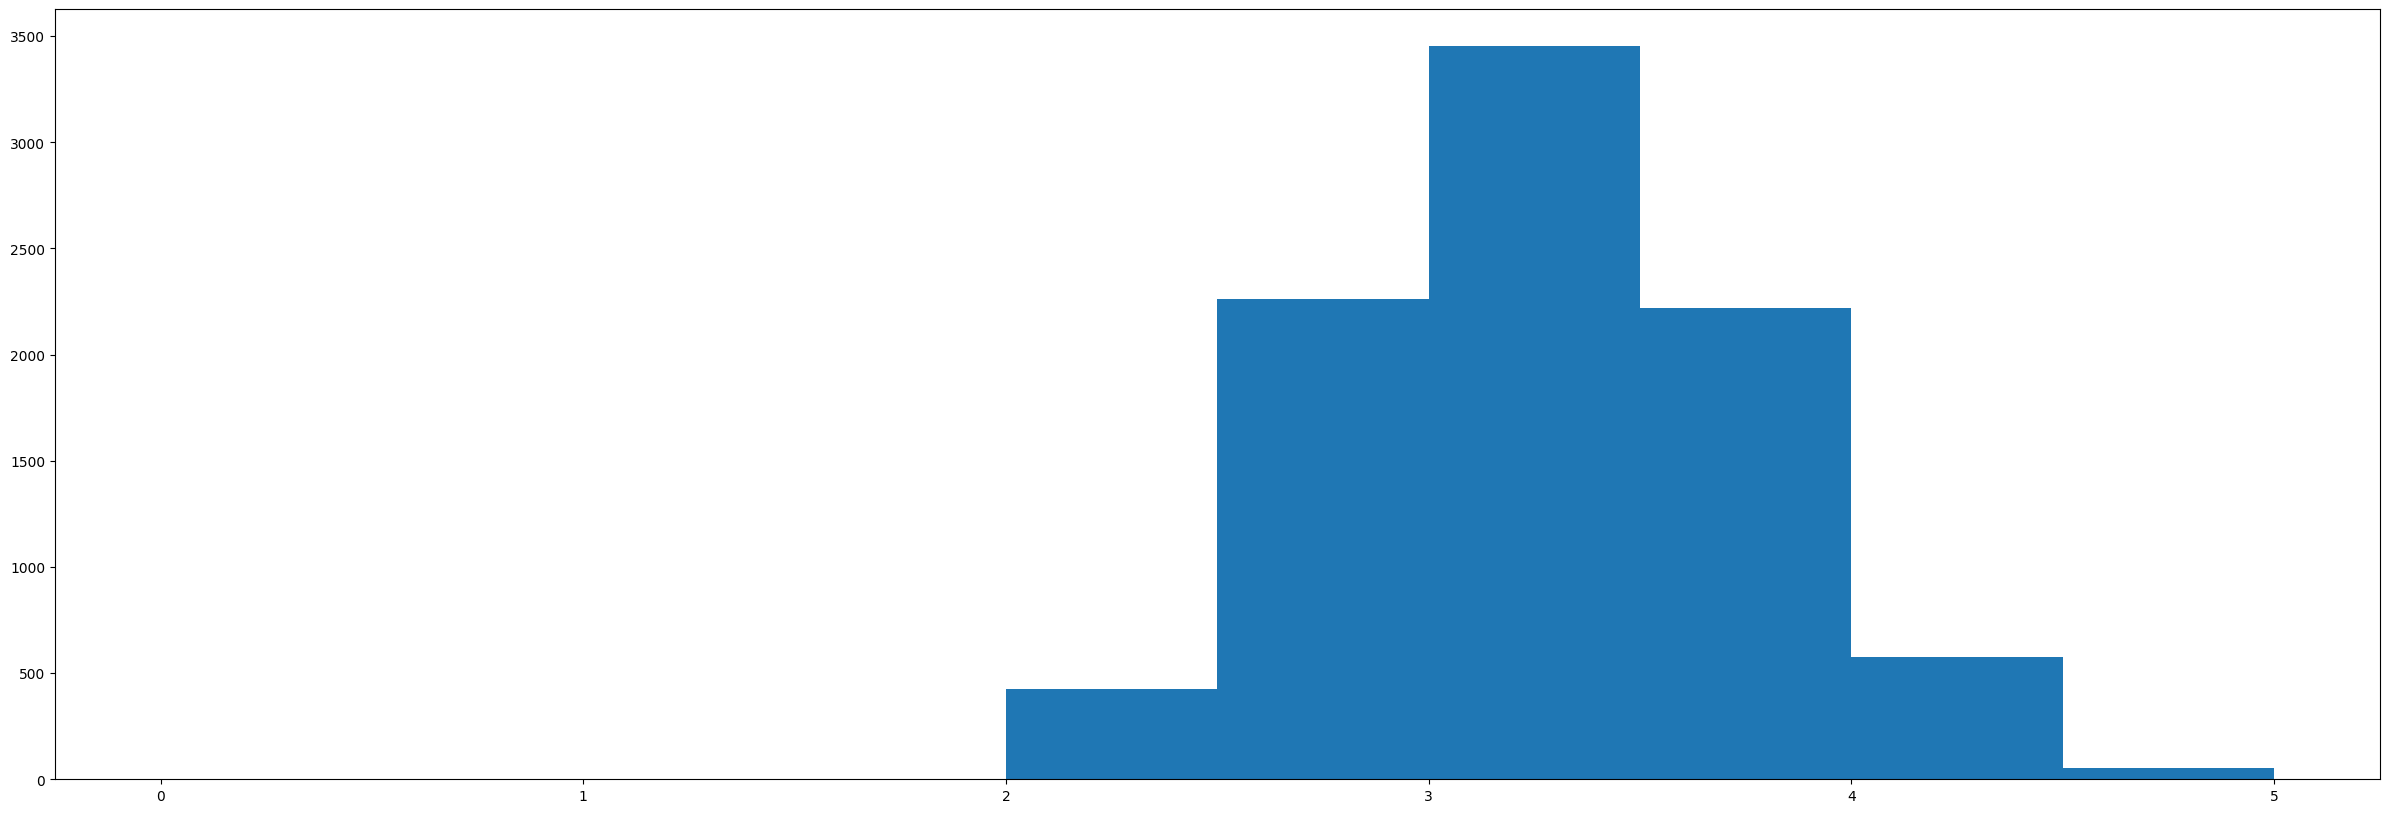

Epoch: 200, Loss: 0.9820, Train: 0.9421, Val: 0.9367, Test: 0.9423
Epoch: 205, Loss: 0.9785, Train: 0.9477, Val: 0.9412, Test: 0.9520


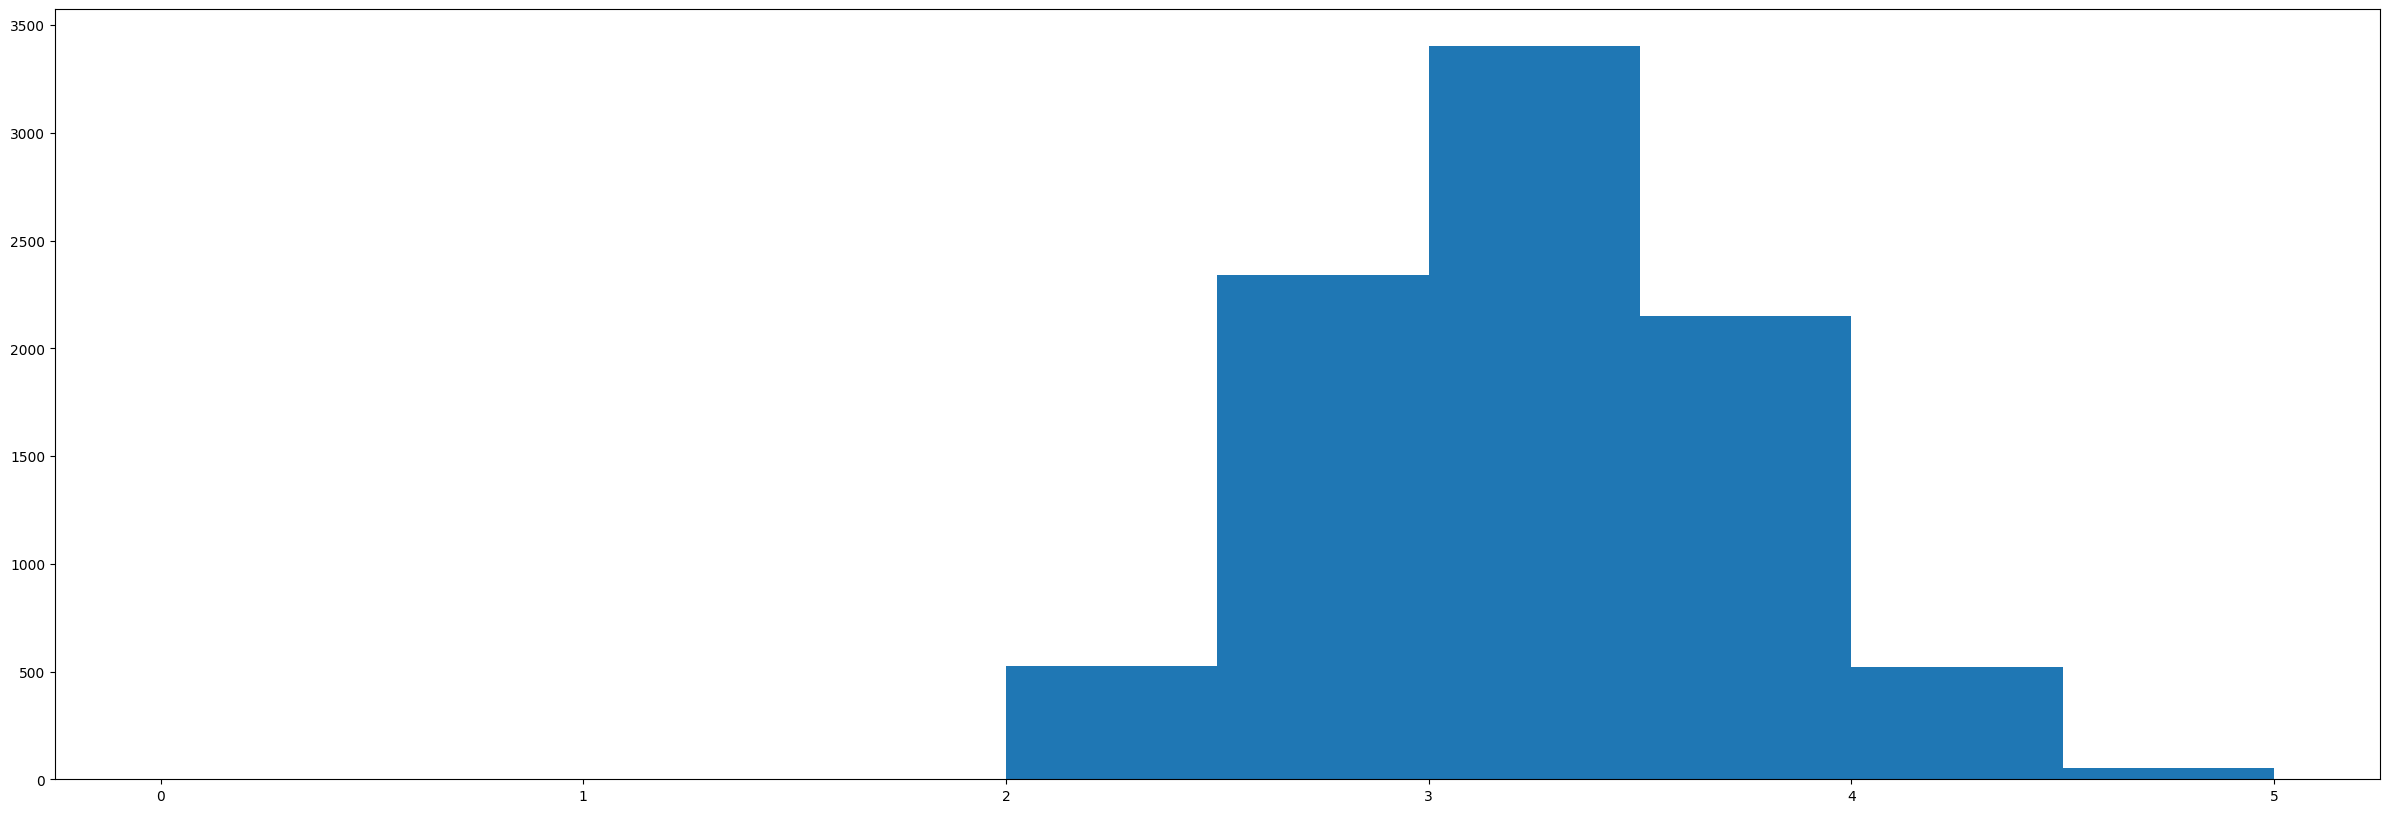

Epoch: 210, Loss: 0.9790, Train: 0.9529, Val: 0.9426, Test: 0.9459
Epoch: 215, Loss: 0.9755, Train: 0.9405, Val: 0.9374, Test: 0.9402


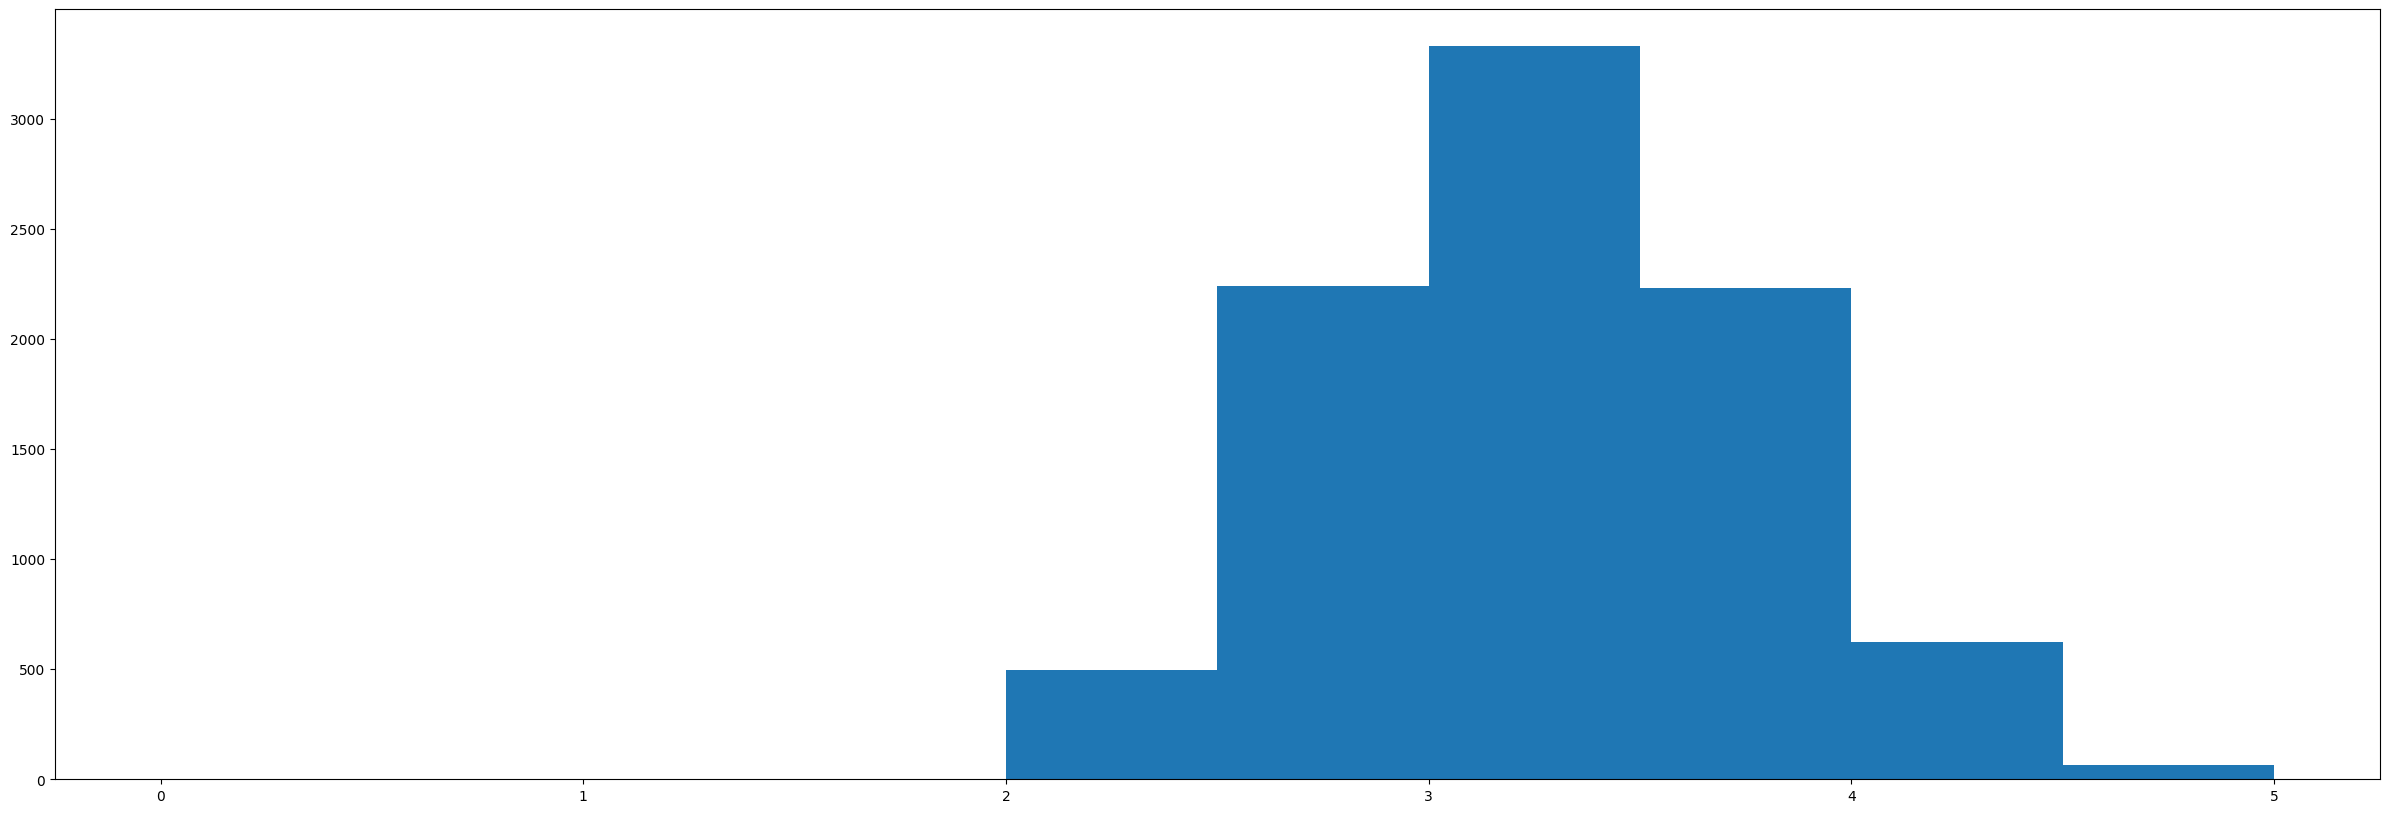

Epoch: 220, Loss: 0.9779, Train: 0.9447, Val: 0.9435, Test: 0.9388
Epoch: 225, Loss: 0.9748, Train: 0.9425, Val: 0.9442, Test: 0.9424


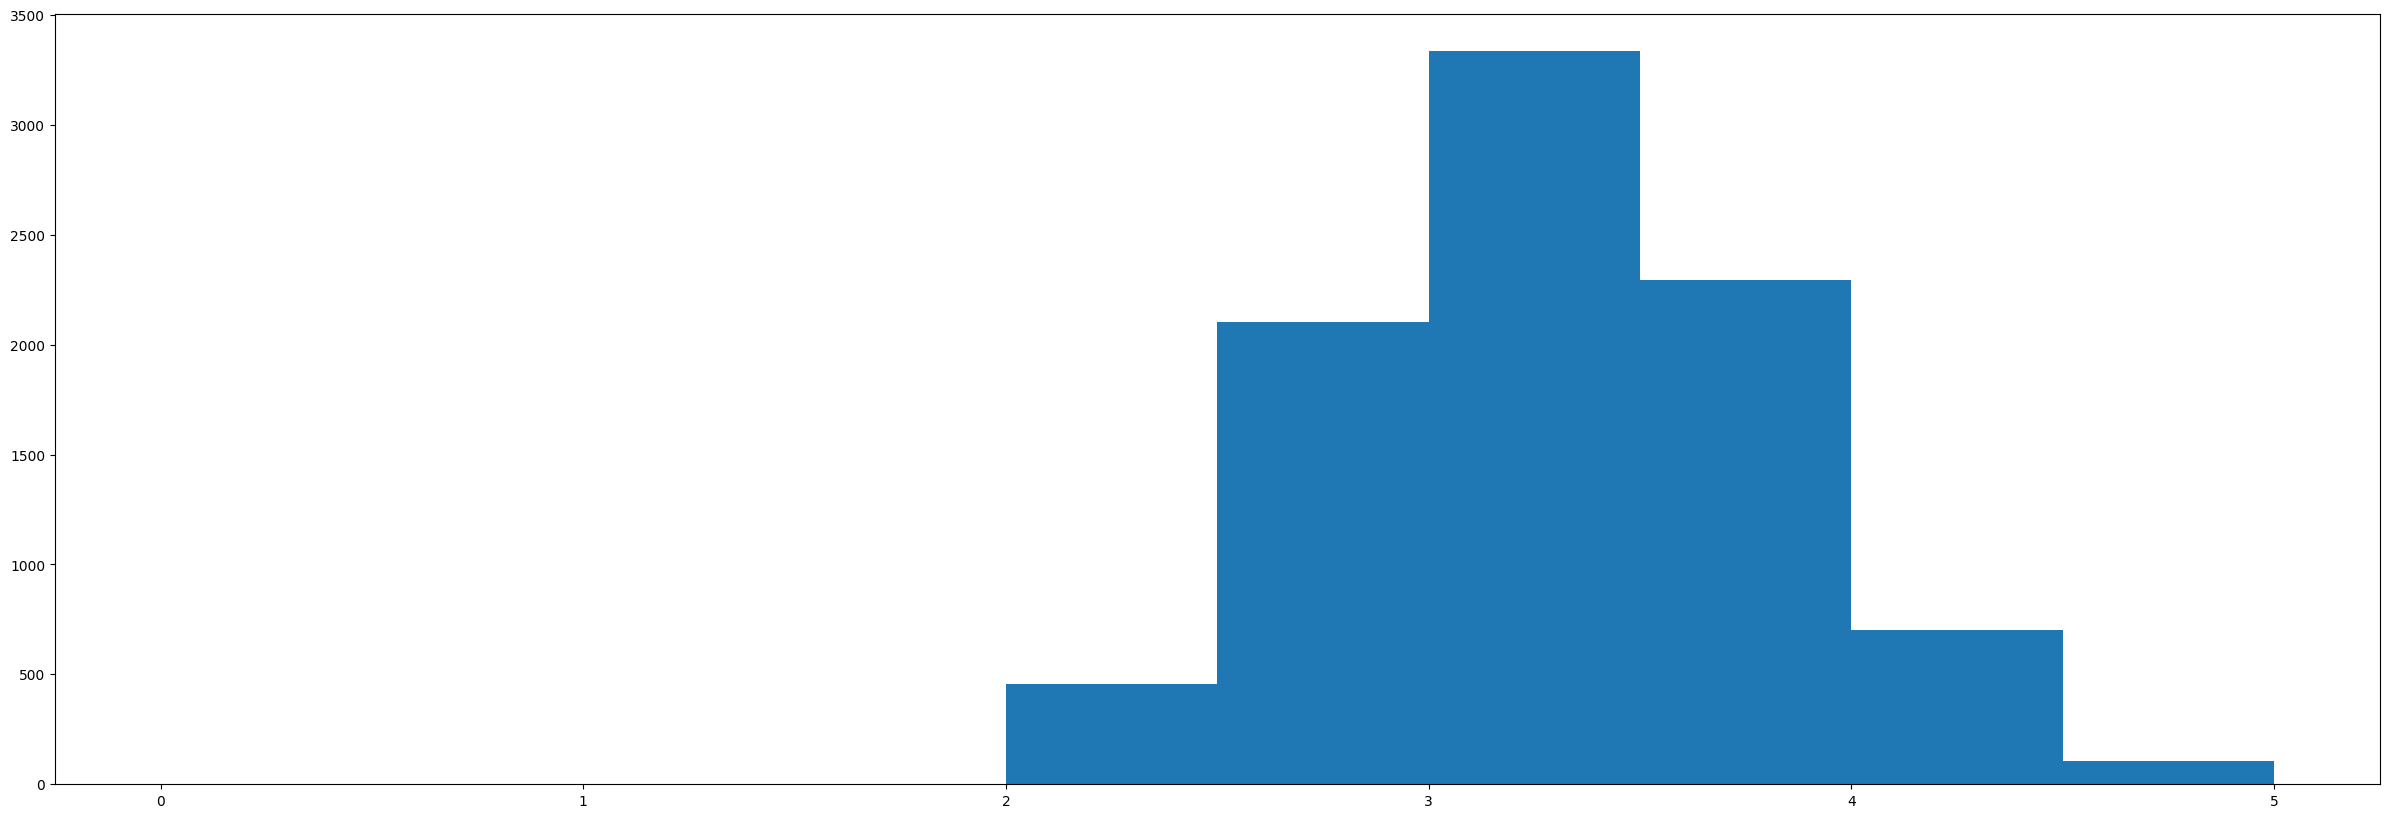

Epoch: 230, Loss: 0.9774, Train: 0.9375, Val: 0.9284, Test: 0.9329
Epoch: 235, Loss: 0.9717, Train: 0.9314, Val: 0.9318, Test: 0.9330


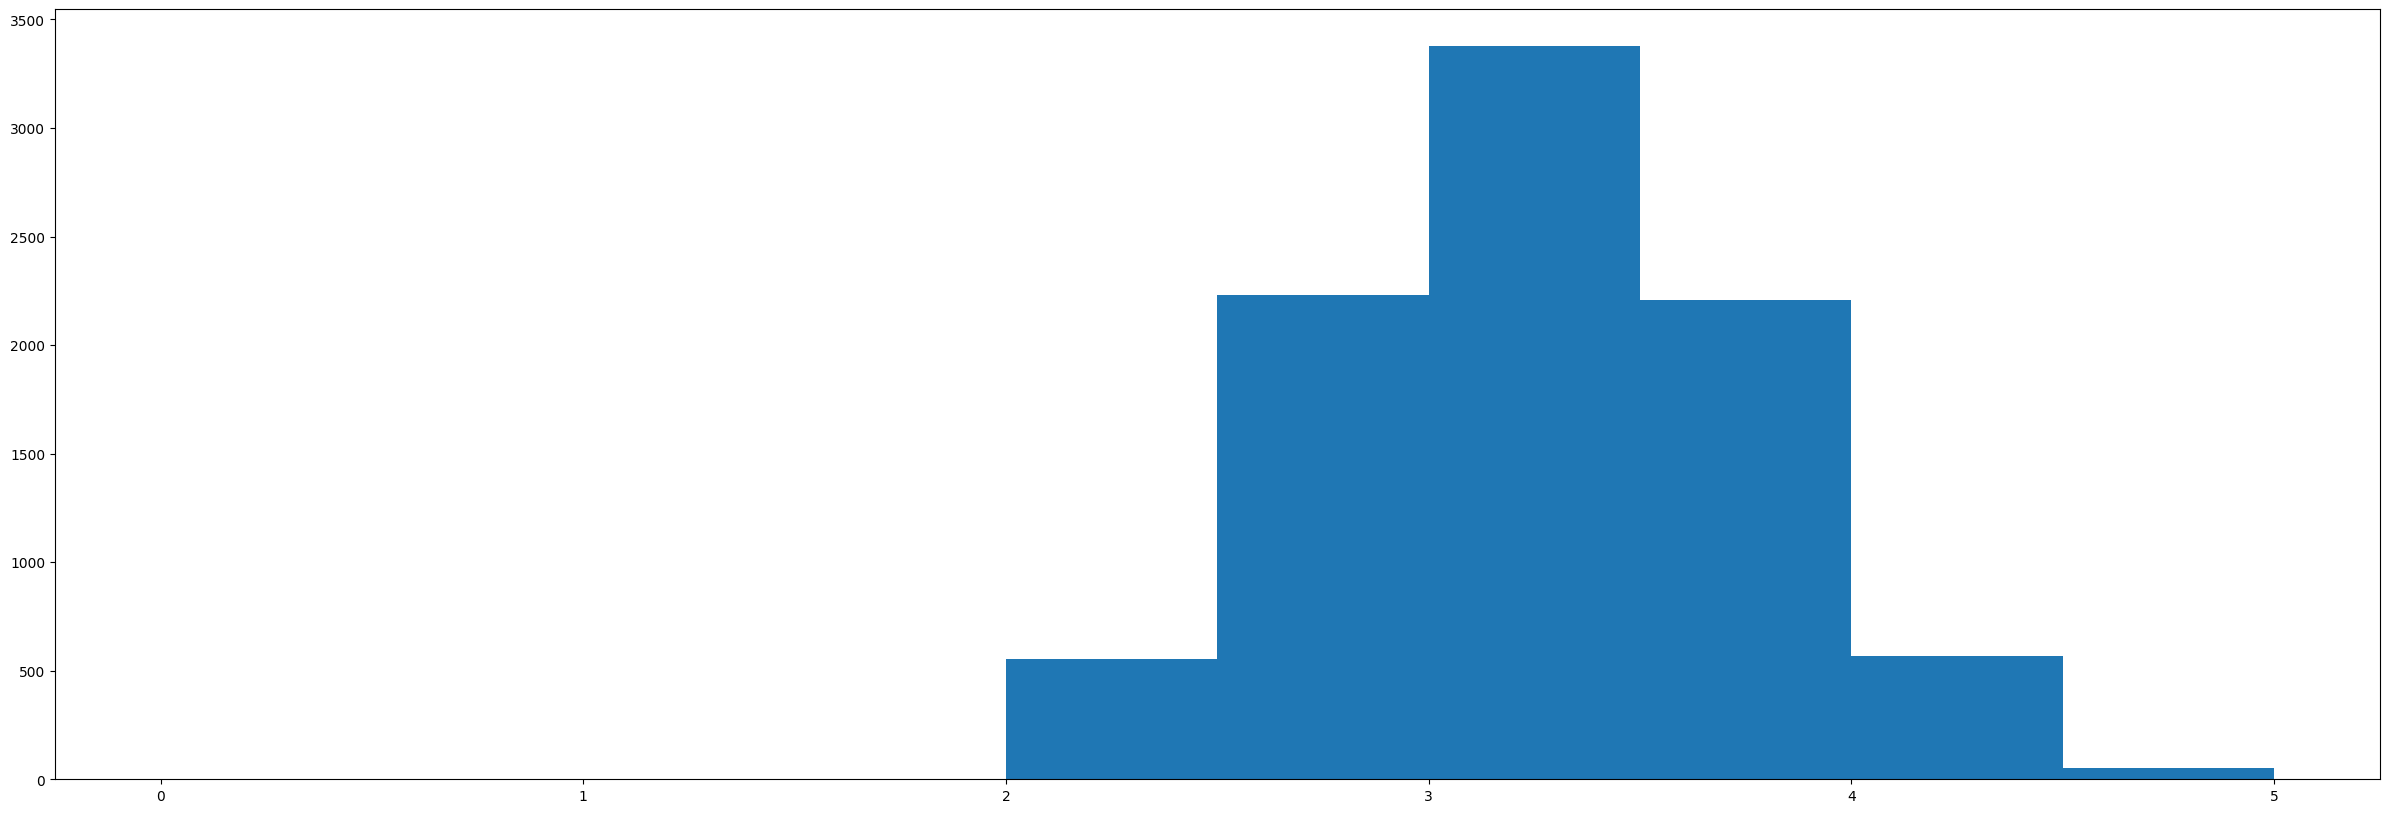

Epoch: 240, Loss: 0.9680, Train: 0.9424, Val: 0.9449, Test: 0.9413
Epoch: 245, Loss: 0.9681, Train: 0.9375, Val: 0.9305, Test: 0.9335


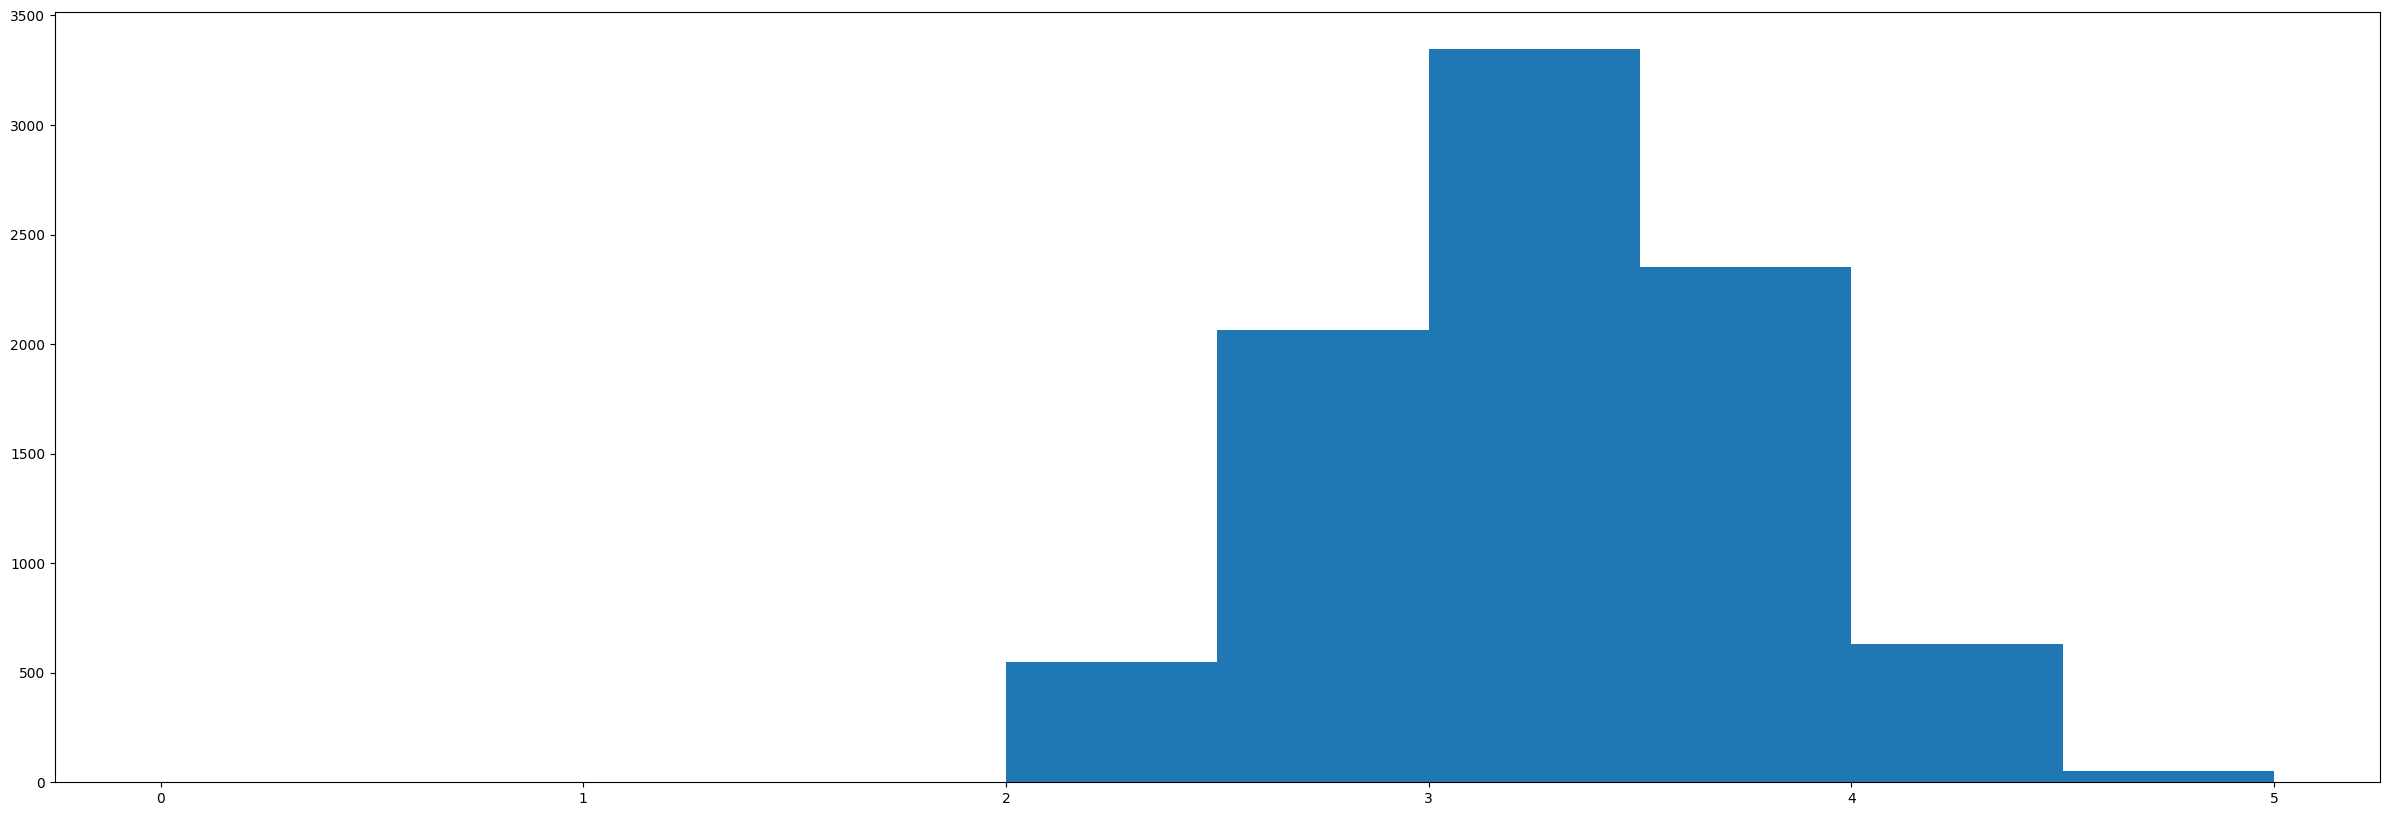

Epoch: 250, Loss: 0.9694, Train: 0.9311, Val: 0.9328, Test: 0.9354
Epoch: 255, Loss: 0.9720, Train: 0.9351, Val: 0.9387, Test: 0.9373


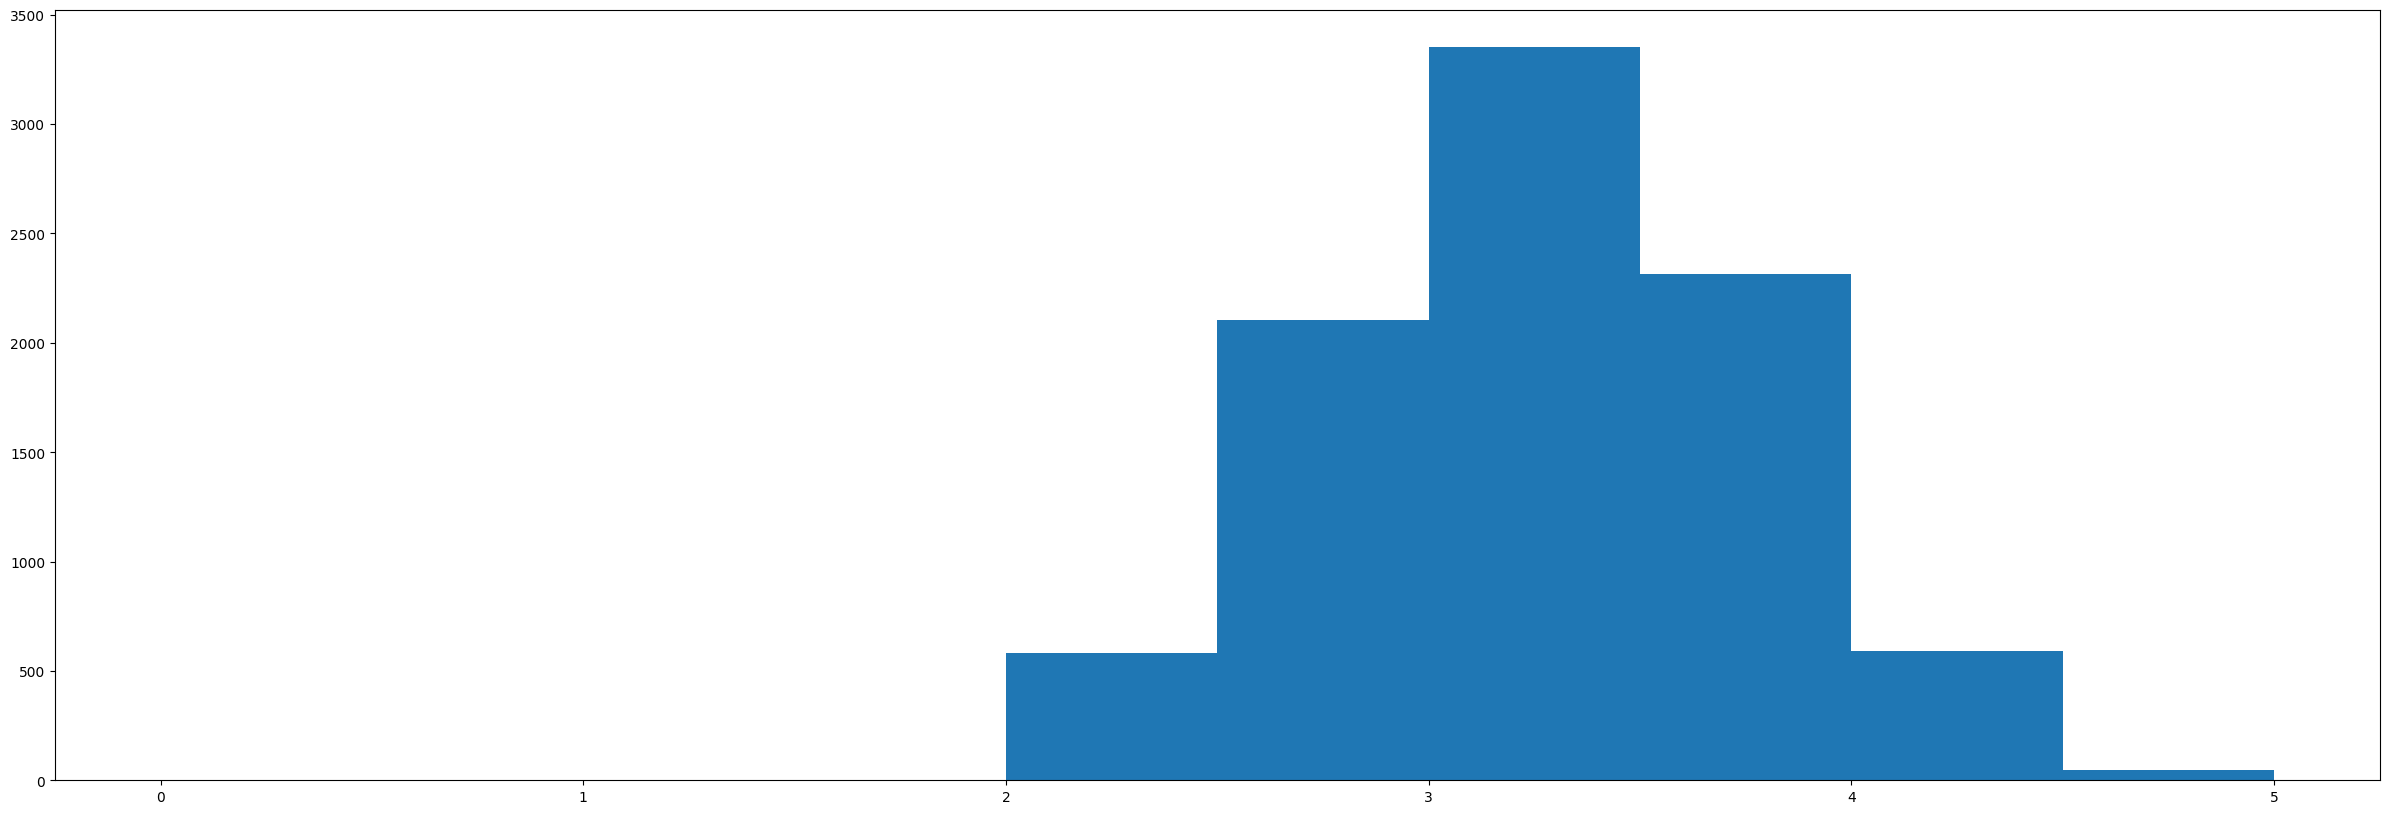

Epoch: 260, Loss: 0.9678, Train: 0.9318, Val: 0.9306, Test: 0.9358
Epoch: 265, Loss: 0.9636, Train: 0.9283, Val: 0.9302, Test: 0.9324


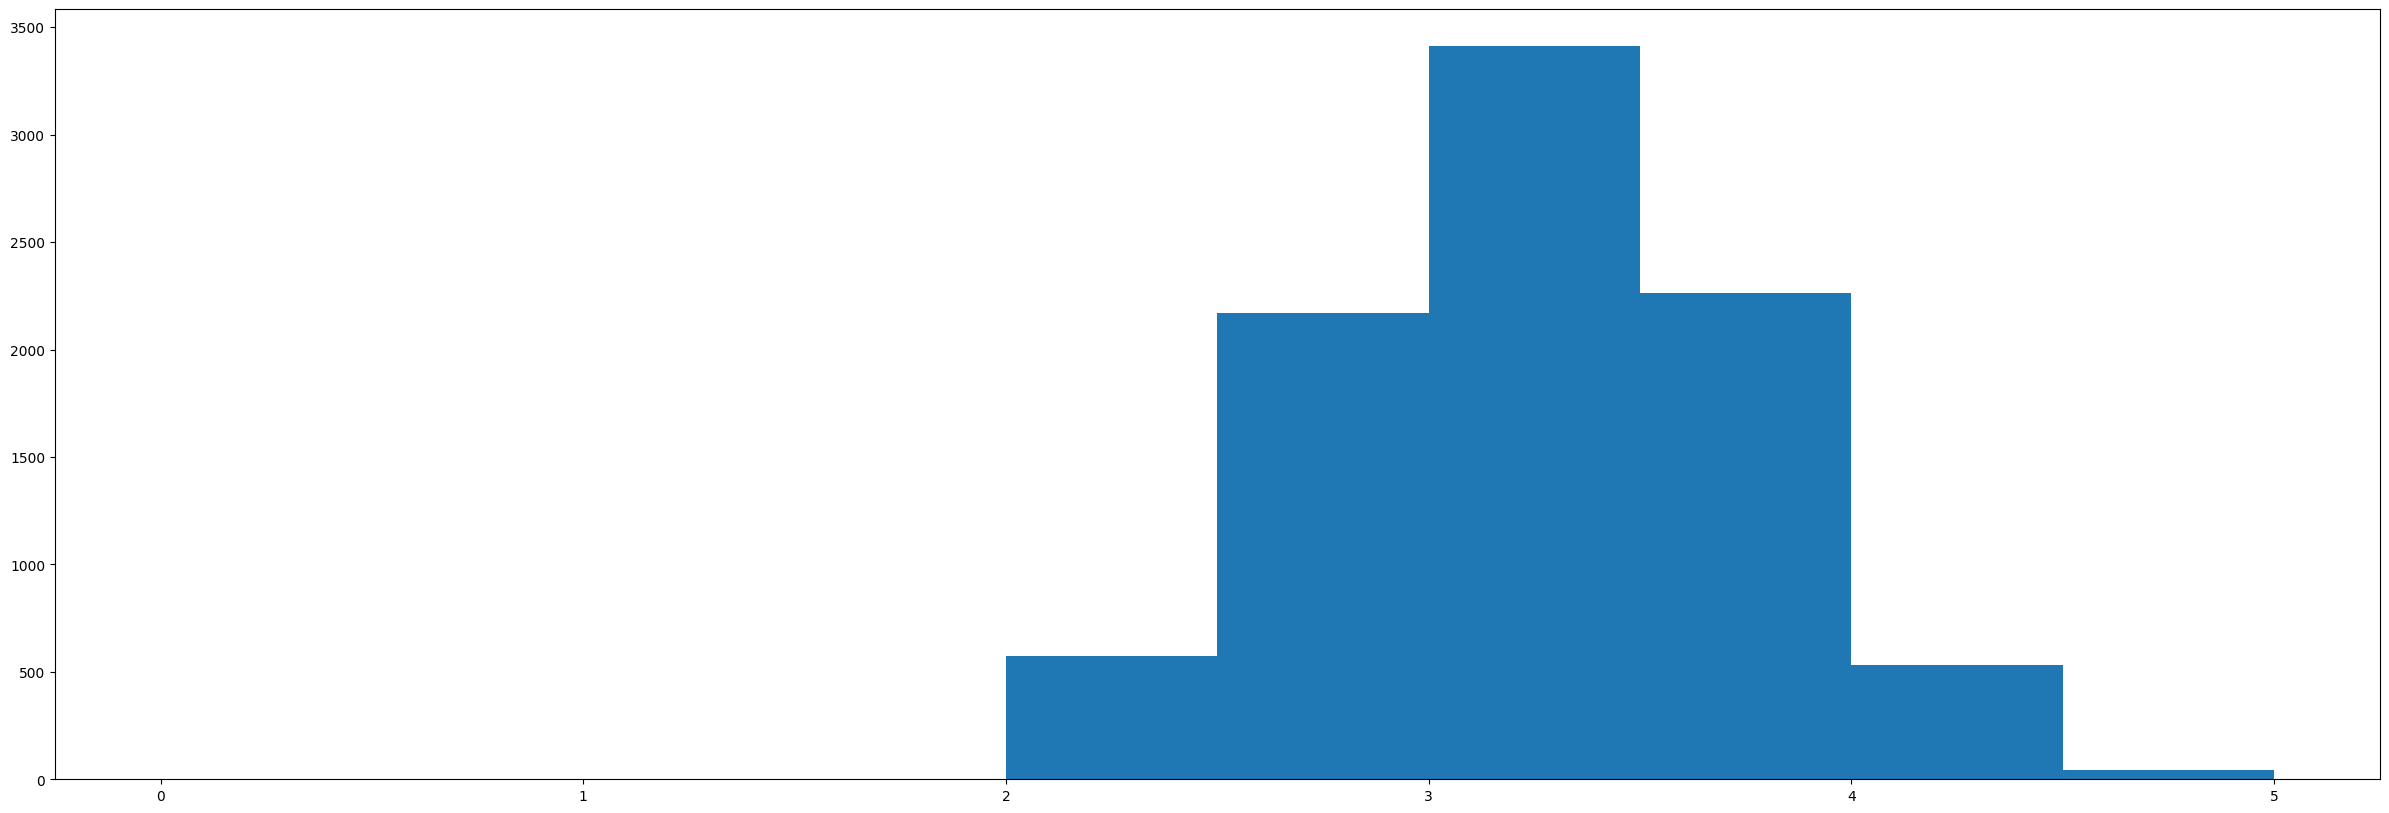

Epoch: 270, Loss: 0.9644, Train: 0.9381, Val: 0.9363, Test: 0.9405
Epoch: 275, Loss: 0.9653, Train: 0.9369, Val: 0.9390, Test: 0.9439


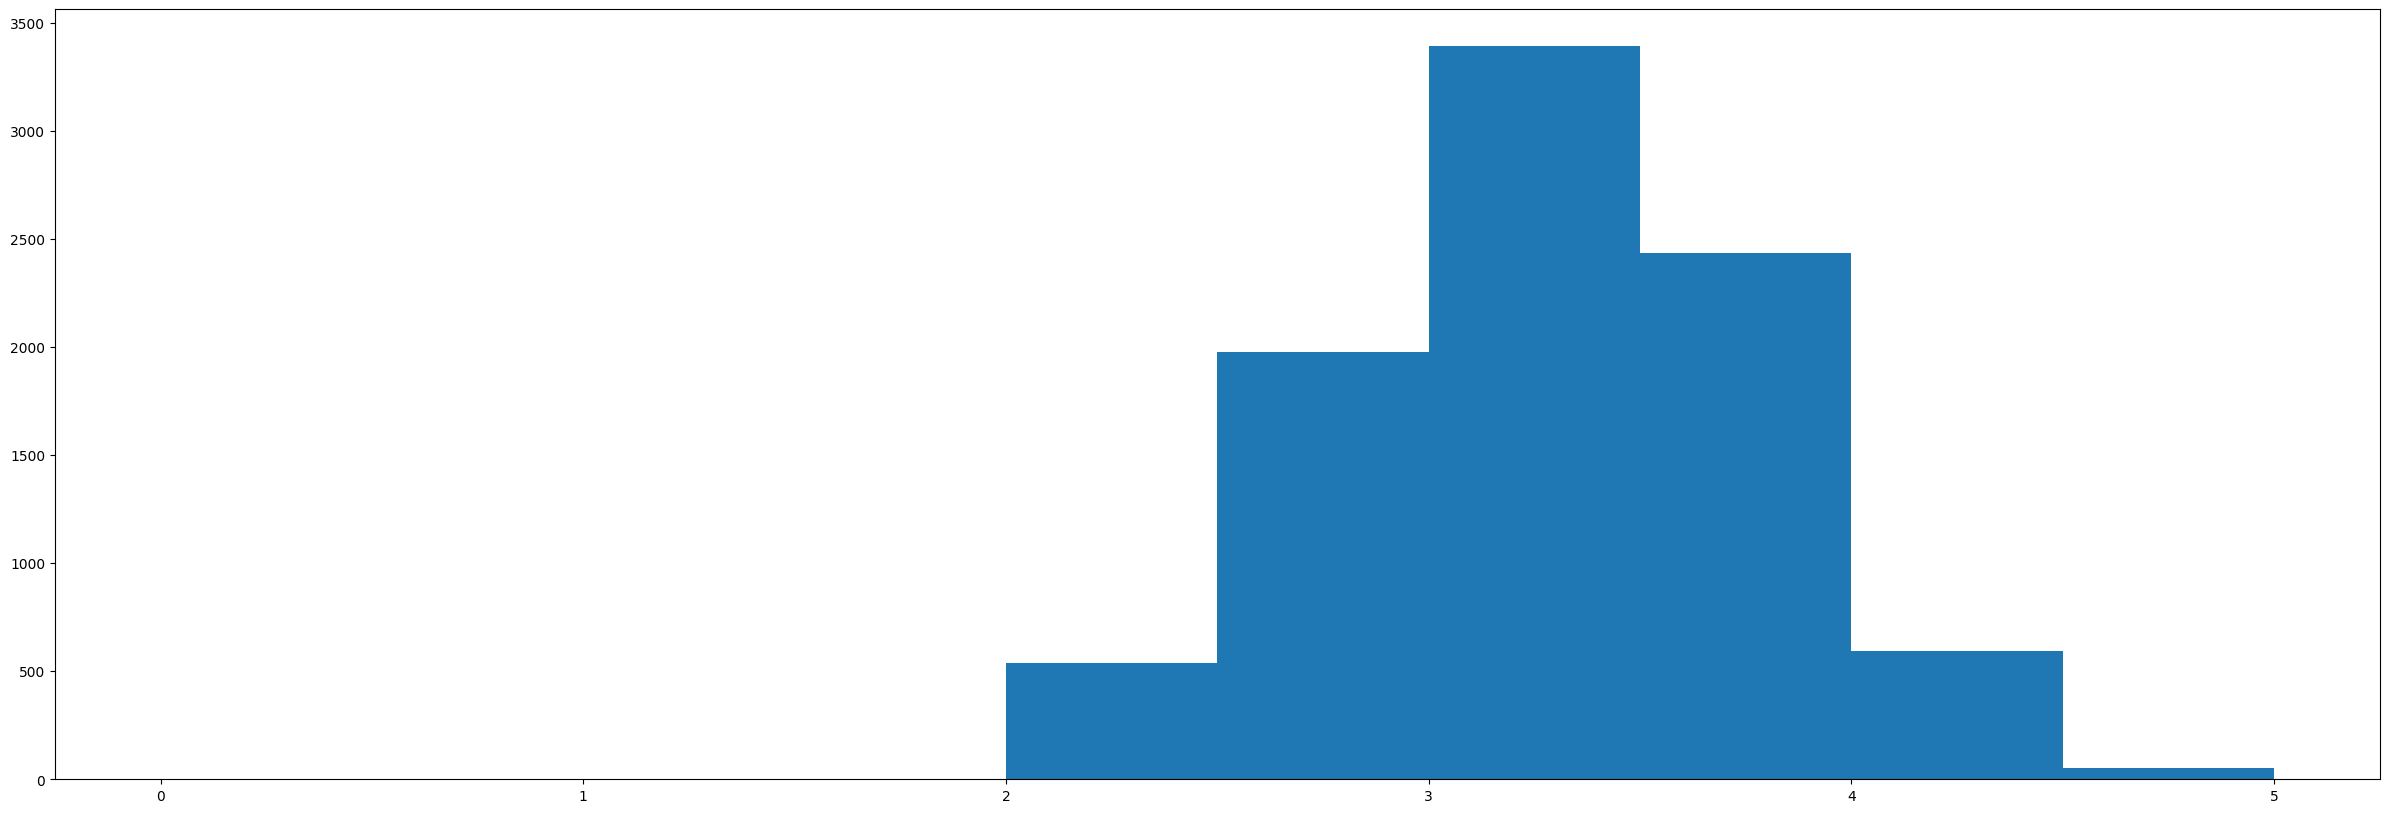

Epoch: 280, Loss: 0.9623, Train: 0.9293, Val: 0.9295, Test: 0.9344
Epoch: 285, Loss: 0.9650, Train: 0.9295, Val: 0.9296, Test: 0.9284


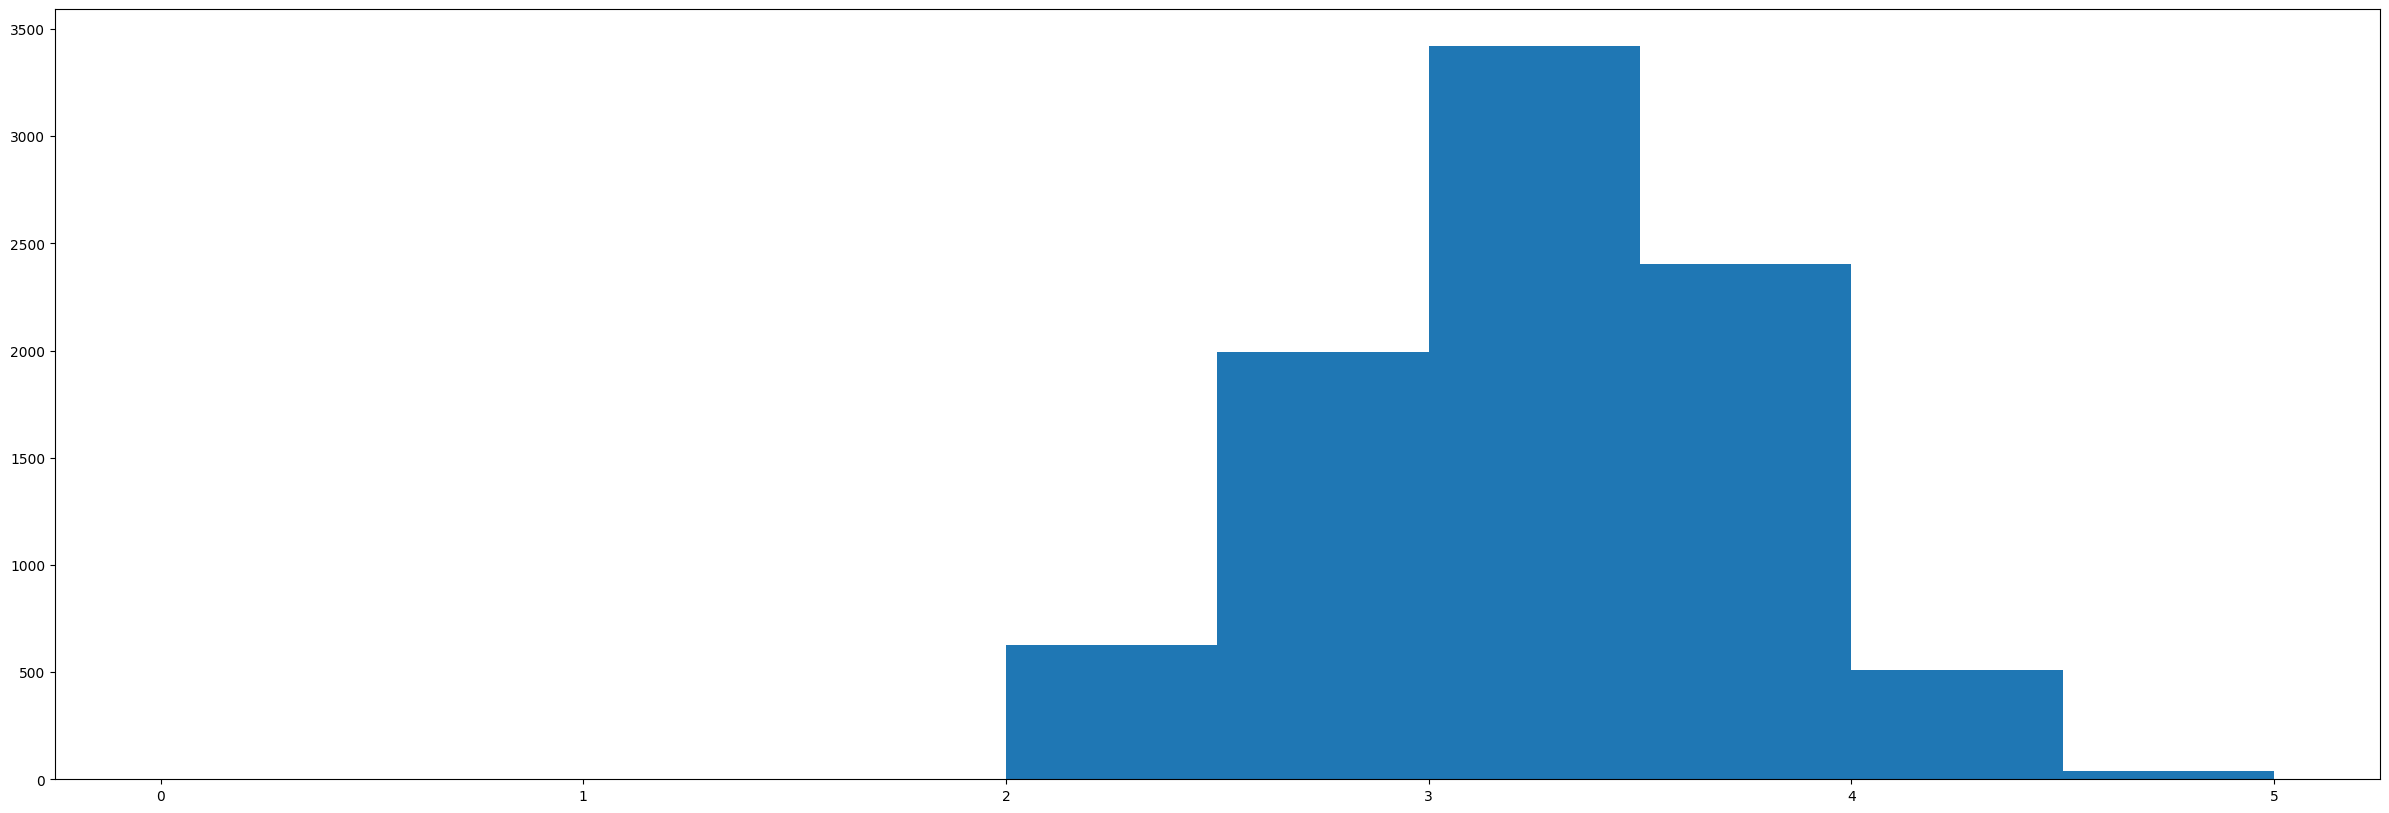

Epoch: 290, Loss: 0.9635, Train: 0.9290, Val: 0.9323, Test: 0.9354
Epoch: 295, Loss: 0.9603, Train: 0.9347, Val: 0.9399, Test: 0.9377


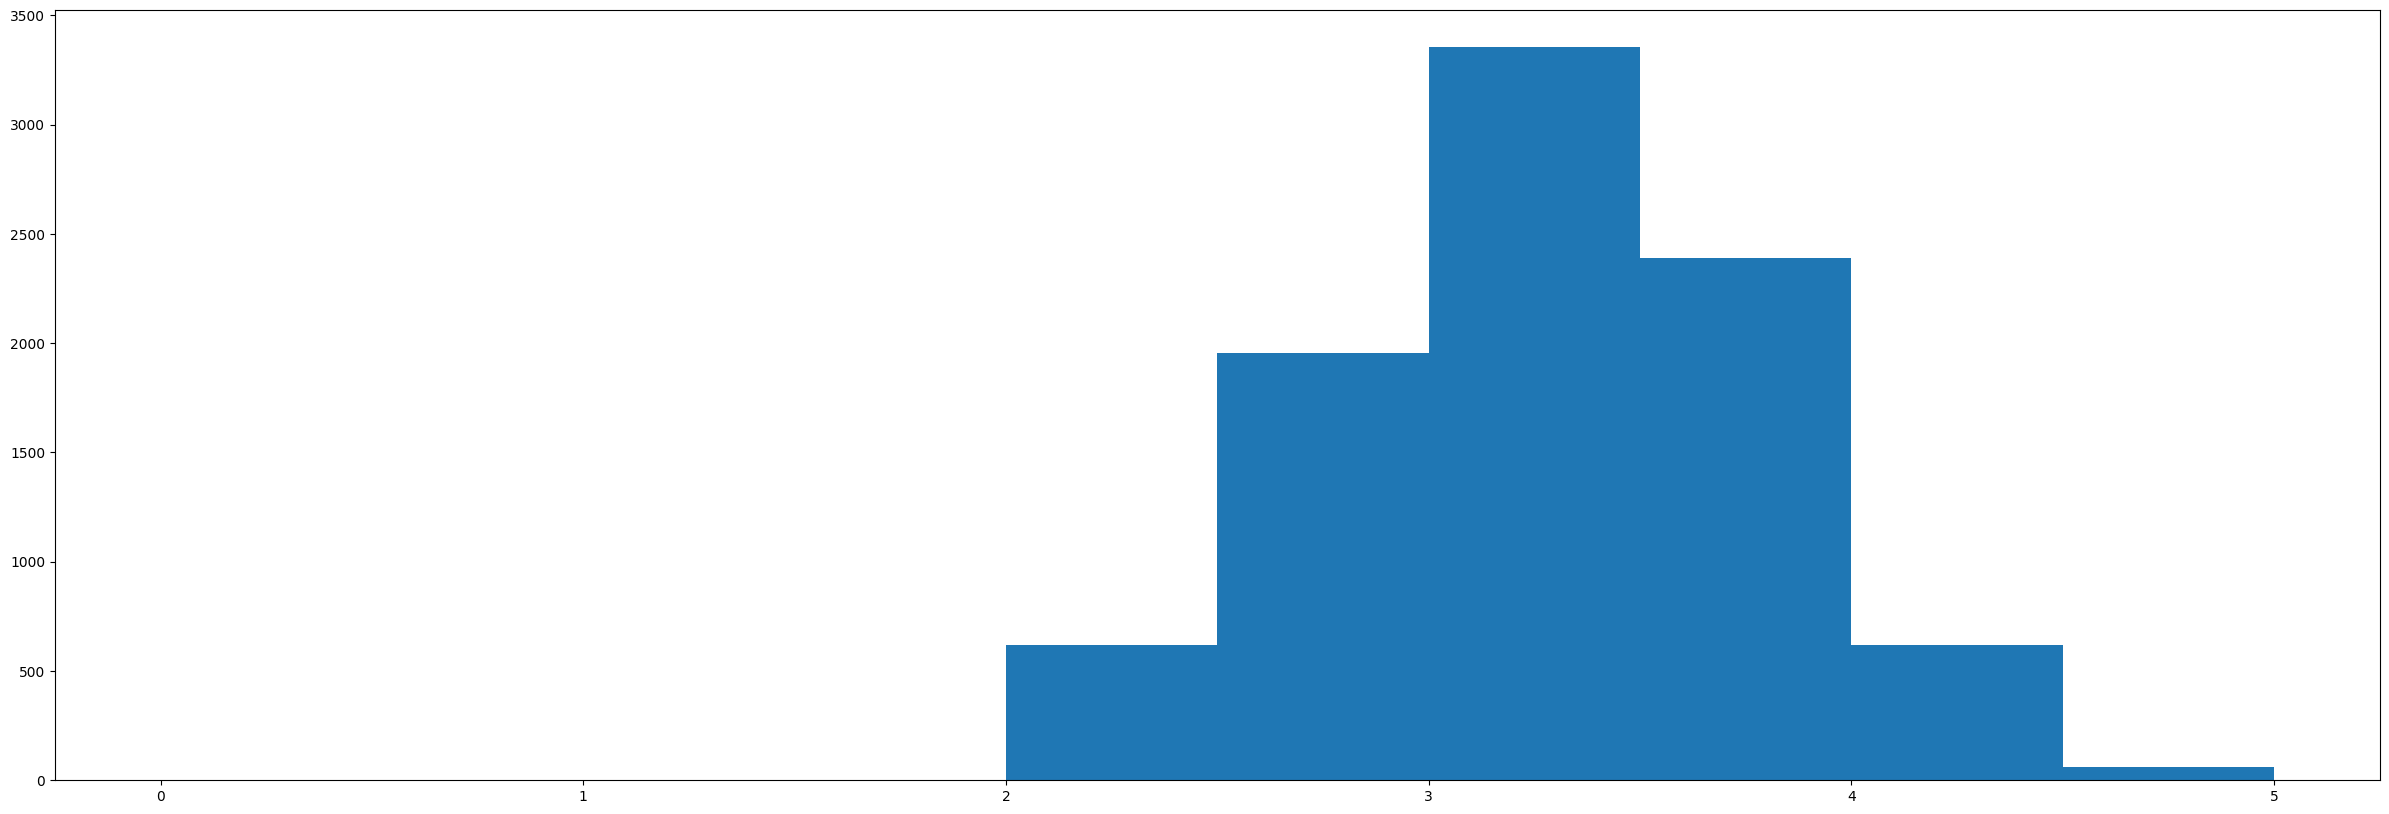

Epoch: 300, Loss: 0.9628, Train: 0.9316, Val: 0.9276, Test: 0.9318


In [14]:
model = Model(layer_name="SAGE", hidden_channels=32, data=data, encoder_num_layers=3,
              decoder_num_layers=5, encoder_dropout=0.1, decoder_dropout=0.1, encoder_skip_connections=1)
train_test(model, train_data=train_data, test_data=test_data,
           val_data=val_data, logging_step=5, epochs=300, use_weighted_loss=False, lr=0.02)

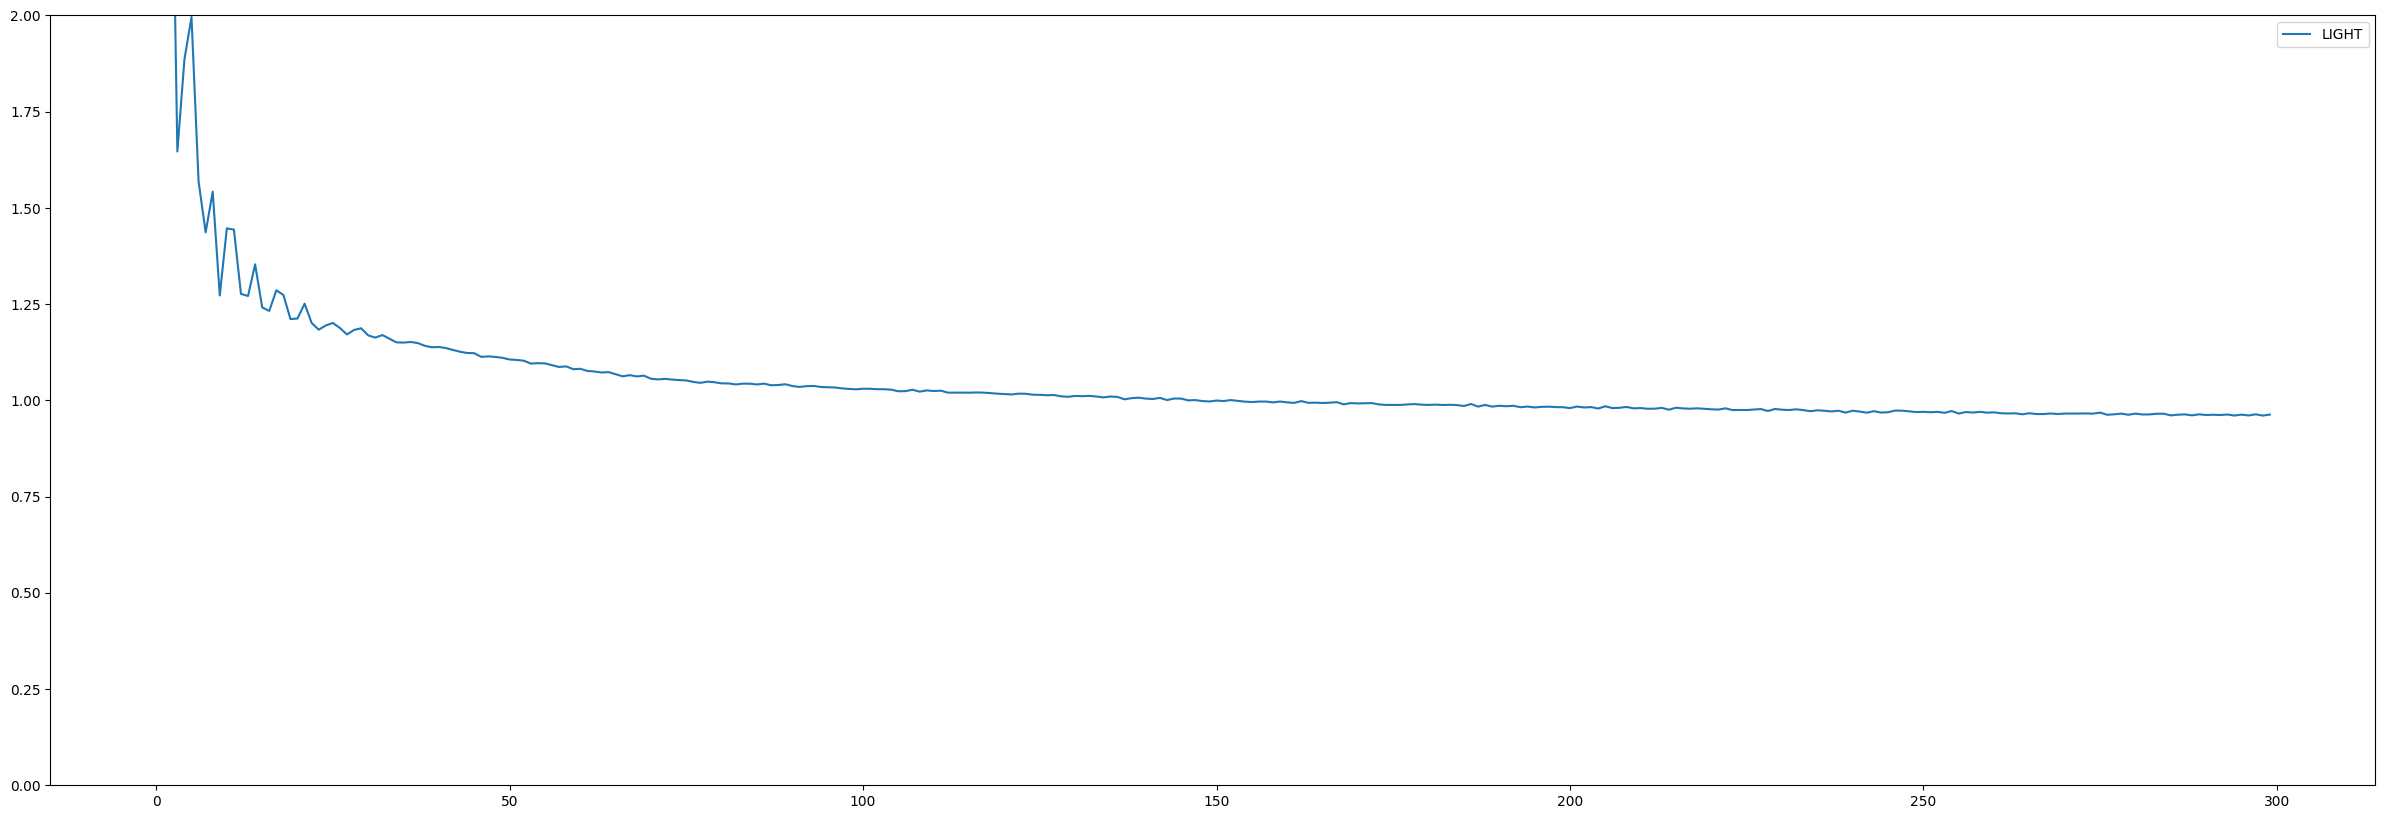

In [15]:
plot_loss(losses_, ylim=2)

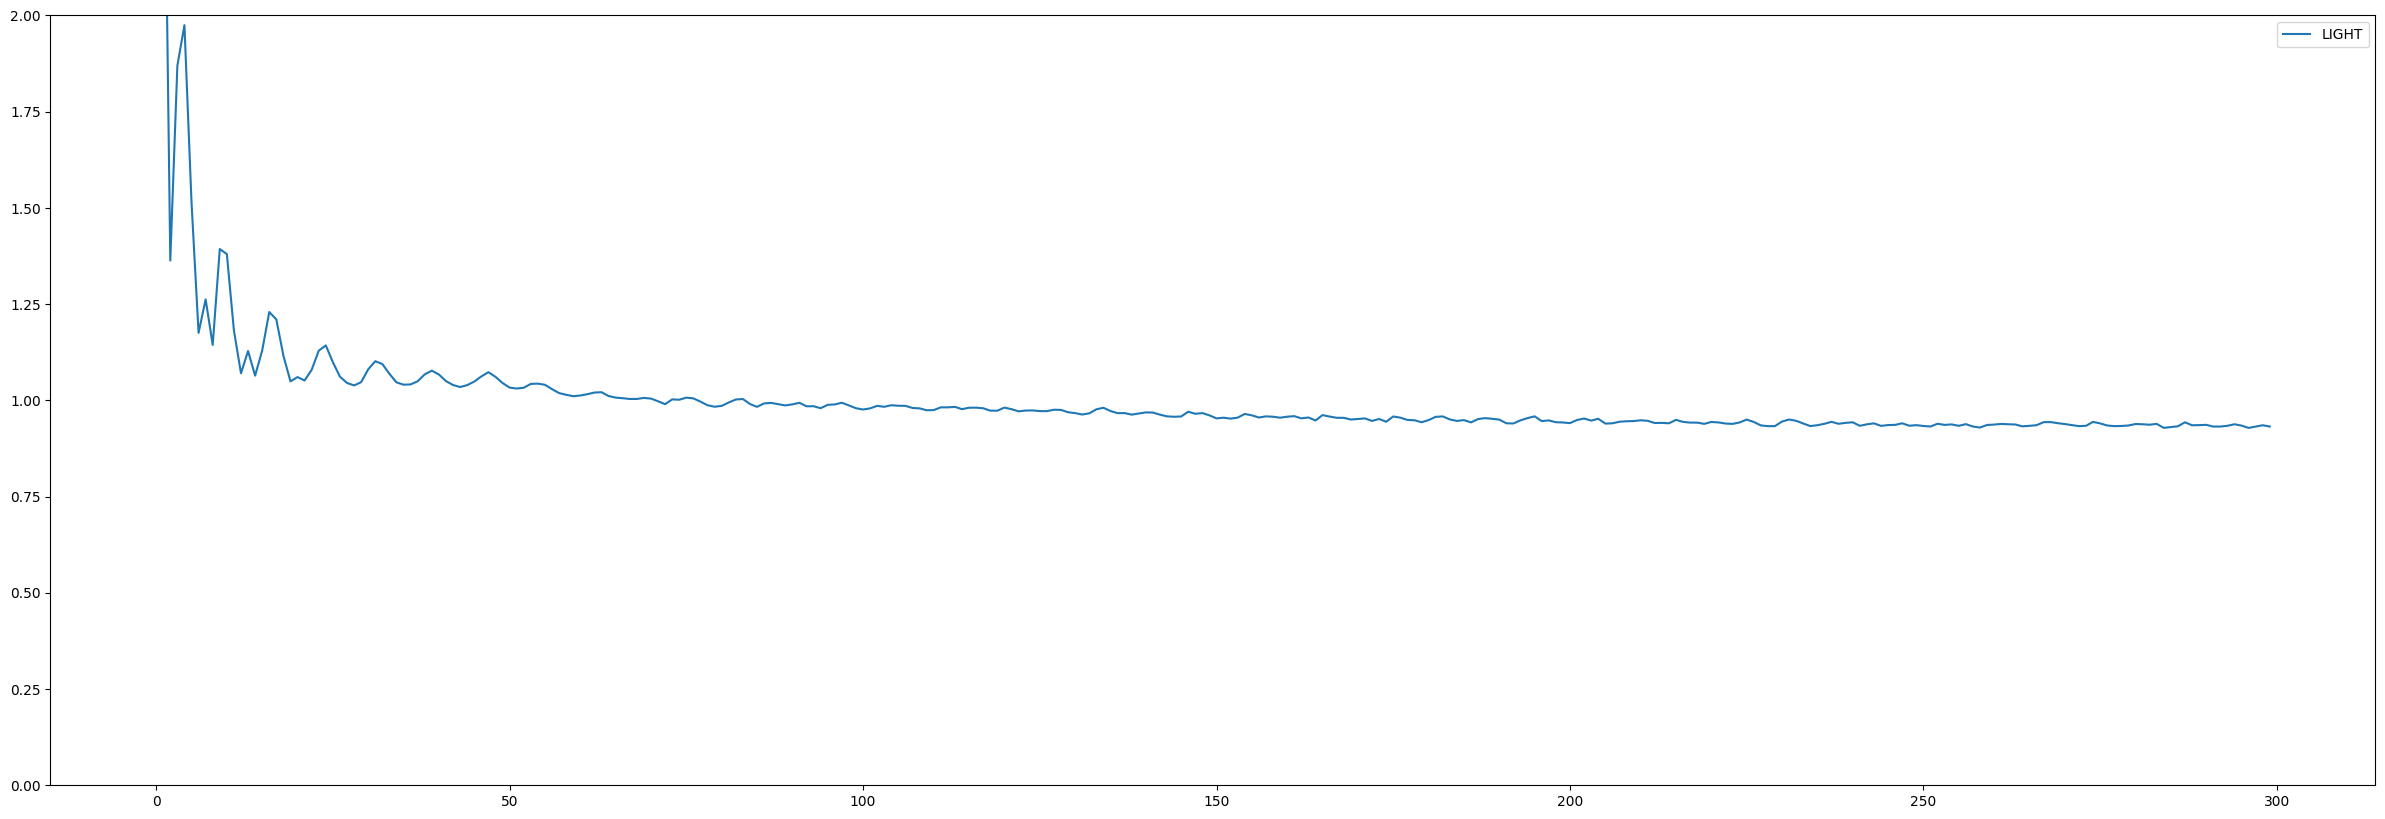

In [16]:
plot_test(losses_, ylim=2)